I restructure a bit of the code here and also some of the data. The researchers have not been consistent in the enumeration of the peptides neither the domains so its kinda difficult to structure it all together. 

**UPDATE**:

There was lots of redundant code that I had written for demonstration purposes. The code written henceforth is cleaner and more modular(I hope) 

In [1]:
import os 
os.chdir('E:\Ecole\Year 3\Projet 3A')
import pandas as pd
import numpy as np 

class Domain:
    
    def __init__(self, name):
        self.name = name
        self.thresholds = None
        self.thetas = None

class Peptide:
    
    def __init__(self, name):
        self.name = name
        self.sequence = None
        self.sequence_bis = None ##Sequence bis are the last five amino acids
        self.energy_ground = 0.0 ##Anticipating the calculation of a ground state energy for the peptide
        
class Data:
    
    def __init__(self):
        temp_df = pd.read_excel('Data_PDZ/MDSM_01_stiffler_bis.xls')
        self.aminoacids = [acid.encode('utf-8') for acid in list(temp_df.columns[:20])]
        self.df = temp_df.T
        self.domains = [Domain(domain.encode('utf-8')) for domain in list(self.df.columns)]
        self.domain_names = [domain.name for domain in self.domains]
        self.pep_seqs = []
        self.pep_names = []
        with open('Data_PDZ/peptides.free') as f:
            for line in f:
                x = line.split()
                self.pep_seqs.append(x[1])
                self.pep_names.append(x[0])
        self.peptides = [Peptide(name) for name in self.pep_names]
        
    def create_domains(self):
        for domain in self.domains:
            domain.thetas = self.df[domain.name][:100]
            domain.thetas = np.asarray(domain.thetas)
            domain.thetas = domain.thetas.reshape(5,20)
            domain.thresholds = np.asarray(self.df[domain.name][100:])   
    
    def create_peptides(self):
        for i in range(len(self.pep_seqs)):
            self.peptides[i].sequence = self.pep_seqs[i]
            self.peptides[i].sequence_bis = list(self.pep_seqs[i])[5:]        

In [2]:
PDZ_Data = Data()
PDZ_Data.create_domains()
PDZ_Data.create_peptides()

Now we have created the preliminary data with the binding energy values and the peptide sequences. The last thing left to do is to get the data from the interaction matrix for each of the domain. 

We also write some convenience functions like the log and sigmoid functions 

In [3]:
fp_interaction_matrix = pd.read_excel('Data_PDZ/fp_interaction_matrix.xlsx')
for column in fp_interaction_matrix.columns:
    fp_interaction_matrix.loc[fp_interaction_matrix[column] == 0.0, column] = -1.0
fp_interaction_matrix = fp_interaction_matrix.rename(columns=lambda x: str(x).replace(" ", ""))

In [4]:
## Sigmoid Function
def sigmoid(x, a=1):
    return 1.0/(1+np.exp(-1.0*a*x))
## Log(1+exp(-x)) 
## We take care of numerical stability for values of x < 0
def log_modified(x):
    if x > 0:
        return np.log(1+np.exp(-x))
    else:
        return -x + np.log(1+np.exp(x))
    
## Convenience functions to convert between letter sequences and indexed sequences. 
## The index for each amino acid is computed using the enumeration presented in the file "MDSM_01_stiffler_bis.xls" 
def convert2seq(seq_int):
    return [PDZ_Data.aminoacids[i] for i in seq_int]
def convert2int(seq_pep):
    return [PDZ_Data.aminoacids.index(pep) for pep in seq_pep]

In [5]:
## Unlike the previous code, where we had two different versions of evaluate_score function, here we have just one. 
## To enter the sequence of a known peptide use convert2int(peptide name) 
def eval_score(domain, sequence):
    score = 0.0
    for i in range(5):
        score += domain.thetas[i,sequence[i]]
    return score - domain.thresholds[0]

In [6]:
## Similarly for the energy evaluation we simply use the single version which use the sequence directly 
## The sequence argument will be useful when making mutations starting from the basic peptide sequence 
def eval_energy(peptide, sequence, verbose=0):
    score_natural = 0.0
    energies = []
    for i in range(len(PDZ_Data.domain_names)): 
        temp = eval_score(PDZ_Data.domains[i], sequence)
        alpha = fp_interaction_matrix[peptide.name][i]
        if alpha > 0:
            alpha = +1.0
        score = temp*alpha
        temp2 = log_modified(score)
        energies.append({'Energy': temp2, 'alpha': alpha, 'score': temp})
        score_natural += temp2 
    if verbose == 0:
        return score_natural
    else:
        return score_natural, energies

Let us take a particular example and illustrate the use of these basic functions on them. We shall use the protein *Caspr2*

In [7]:
ix = PDZ_Data.pep_names.index('Caspr2')
print ix
pep_demo = PDZ_Data.peptides[ix]
print pep_demo.name
print pep_demo.sequence
print pep_demo.sequence_bis

4
Caspr2
IDESKKEWLI
['K', 'E', 'W', 'L', 'I']


In [8]:
print eval_energy(pep_demo, convert2int(pep_demo.sequence_bis))
score, energies = eval_energy(pep_demo, convert2int(pep_demo.sequence_bis), verbose=1)

10.2327578819


In [9]:
neg = []
pos = [] 
for i in range(len(energies)):
    if energies[i]['alpha'] == -1.0:
        neg.append({'data':energies[i], 'name': PDZ_Data.domain_names[i], 'index' : i+2})
    else:
        pos.append({'data':energies[i], 'name': PDZ_Data.domain_names[i], 'index' : i+2})
for item in pos:
    print item

{'index': 2, 'data': {'alpha': 1.0, 'Energy': 0.58841515662593658, 'score': 0.22172999999999998}, 'name': 'Cipp (03/10)'}
{'index': 8, 'data': {'alpha': 1.0, 'Energy': 0.69316718075994543, 'score': -4.0000000000262048e-05}, 'name': 'Dlgh3 (1/1)'}
{'index': 19, 'data': {'alpha': 1.0, 'Energy': 2.5693183193875501e-05, 'score': 10.569272000000002}, 'name': 'HtrA3 (1/1)'}
{'index': 33, 'data': {'alpha': 1.0, 'Energy': 0.6931021815724453, 'score': 9.0000000000145519e-05}, 'name': 'Mpp7 (1/1)'}
{'index': 43, 'data': {'alpha': 1.0, 'Energy': 0.69316718075994543, 'score': -4.0000000000262048e-05}, 'name': 'PAR-3 (3/3)'}


In [10]:
## We calculate the natural energies for each of the peptides 
for pep in PDZ_Data.peptides:
    pep.energy_ground = eval_energy(pep, convert2int(pep.sequence_bis))

In [11]:
## Sanity Check 
print PDZ_Data.peptides[ix].energy_ground

10.2327578819



## Simulation 
Now we shall start with the real Monte Carlo step. Our algorithm is based on the famous Metropolis algorithm. We start with a given peptide and its sequence. To each peptide is associated a particular energy(which we calculated above). We expect that under mutations of the sequence, this energy will change. Depending on whether the energy changes or not after a point mutation, we shall accept or reject the mutation. 

Let us first start off by writing some convenience functions to make point mutations

**UPDATE**:

After some problems with the data, mainly to do with the way the data was indexed by the researchers, we are finally in a position to retrieve something meaningful out of the data. 

For an initial run, the acceptance rule for the mutations was rather simple: If the energy reduced we would accept the mutation, otherwise not. Surprisingly, with such a rule, no new mutations which conserve the original binding pairs, are allowed. Further exploration is needed at this stage to completely deconstruct this finding.

To facilitate further analysis, I compute the energies and the scores for each of the peptide-PDZ pairs. These energies will serve as a reference for further mutations. 

To make a mutation we need two numbers, one a number between 0 and 4 which will tell us the position to be mutated and a number between 0 and 19 which will tell us the amino acid to put in that position. We can do this easily by making two calls to the randomint function in numpy. 

In [12]:
y = np.random.randint(5)
z = np.random.randint(20)
print y, z

0 2


This is a basic run where we introduce mutations and see whether the energy actually reduces or not. The base energy is 8.178291

We now run the Metropolis Hastings algorithm for our data set. If the energy decreases then it is a favorable mutation and we accept the mutation, otherwise we reject the mutation

In [15]:
test_peptide = PDZ_Data.peptides[57]
print test_peptide.name
print test_peptide.energy_ground

AcvR1
8.1782910361


In [16]:
print " Uniform {} Test {}".format(np.random.uniform(), 2)

 Uniform 0.38313776258 Test 2


In [170]:
def run_mc(nb_runs, peptide, temp=0, nb_cycles=10, plot=False, verbose=True):
    import matplotlib.pyplot as plt
    sims = []
    print "Name of Peptide {}".format(peptide.name)
    print "Base Energy {}".format(peptide.energy_ground)
    print "Base Sequence {}".format(peptide.sequence_bis)
    base_seq = convert2int(peptide.sequence_bis)
    for j in range (nb_cycles):
        print "\n Cycle number : {}\n".format(j+1)
        sim_results = []
        mutated_sequences = []
        mutated_energies = []
        for_plot = []
        mut_seq = base_seq
        mut_energy = peptide.energy_ground
        for i in range(nb_runs):
            y = np.random.randint(5)
            z = np.random.randint(19)
            ## Remove if the amino acid change is the same as before 
            if z >= mut_seq[y]:
                z = z+1                
            temp_seq = mut_seq
            print "Last sequence seen {}".format(mut_seq)
            print "Sequence after mutation {}".format(temp_seq)
            temp_seq[y] = z
            temp_energy = eval_energy(peptide, temp_seq)
    #if temp == 0:
     #  if temp_energy < mut_energy:
    #mut_energy = temp_energy
    #mut_seq = temp_seq
                        #sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Accepted': 1})
                        #print "Accepted {} {} {} ".format(temp_seq, temp_energy, convert2seq(temp_seq))
                    #else:
                        #sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Accepted': 0})  
                #else:
            ratio = np.exp(-temp*(temp_energy-mut_energy))
            prob_trans = min(1, ratio)
            x = np.random.uniform()
            if x < prob_trans:
                mut_energy = temp_energy
                mut_seq = temp_seq
                if verbose:
                    print "Run number: {}\n".format(i)
                    print "Uniform {} Ratio {} Prob_Trans {} ".format(x,ratio,prob_trans)
                    print "Accepted {} {} {} {} \n".format(temp_seq, temp_energy, convert2seq(temp_seq), convert2seq(mut_seq))
                sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Accepted': 1})
                for_plot.append(temp_energy)
            else:
                print "Run number {} Uniform {} Ratio {} Prob_Trans {} ".format(i, x,ratio,prob_trans)
                print "Rejected {} {} {} {}\n".format(temp_seq, temp_energy, convert2seq(temp_seq), convert2seq(mut_seq))
                sim_results.append({'Sequence': temp_seq, 'Energy': temp_energy, 'Accepted': 0})  

                ##print "Rejected {} {}".format(temp_seq, temp_energy)
            mutated_sequences.append(temp_seq)
            mutated_energies.append(temp_energy)
        print "Lowest Energy {} Sequence {}\n".format(np.min(mutated_energies), convert2seq(mutated_sequences[np.argmin(mutated_energies)]))
        if plot == True:
            plt.figure(j)            
            plt.axhline(y = peptide.energy_ground, hold = None, c = 'r', linewidth=0.5)
            if len(for_plot) == 1:
                plt.axhline(y = for_plot[0], hold=None, c = 'b', linewidth = 1.5)
                plt.plot(for_plot)
                plt.show()
        sims.append({'Results' : sim_results, 'Mutated sequences': mutated_sequences, 'Mutated Energies': mutated_energies}) 

    return sims

Here we perform mutations for the given peptide and only accept those mutations which lead to a reduction in the energy. Here the inverse temperature $\beta$ is infinite (or $T=0$)

In [32]:
results = run_mc(100, test_peptide)


 Cycle number : 1

Accepted [11, 16, 10, 18, 14] 6.65560710528 ['N', 'R', 'T', 'D', 'C'] 
Accepted [16, 17, 6, 18, 12] 1.44898291458 ['R', 'H', 'P', 'D', 'Q'] 
Accepted [16, 17, 6, 18, 5] 1.02989141805 ['R', 'H', 'P', 'D', 'M'] 

 Cycle number : 2

Accepted [3, 19, 4, 1, 15] 4.31746186881 ['L', 'E', 'I', 'A', 'K'] 
Accepted [3, 19, 15, 1, 15] 3.60813399749 ['L', 'E', 'K', 'A', 'K'] 
Accepted [3, 10, 15, 1, 15] 3.44158450157 ['L', 'T', 'K', 'A', 'K'] 
Accepted [3, 1, 15, 1, 15] 2.48514668817 ['L', 'A', 'K', 'A', 'K'] 

 Cycle number : 3

Accepted [9, 1, 4, 5, 9] 6.26835589215 ['S', 'A', 'I', 'M', 'S'] 
Accepted [9, 1, 4, 5, 15] 6.18247360924 ['S', 'A', 'I', 'M', 'K'] 
Accepted [9, 1, 0, 5, 15] 3.83118907759 ['S', 'A', 'G', 'M', 'K'] 
Accepted [15, 1, 15, 12, 14] 2.80608570073 ['K', 'A', 'K', 'Q', 'C'] 
Accepted [8, 19, 12, 9, 15] 2.36774360313 ['W', 'E', 'Q', 'S', 'K'] 

 Cycle number : 4

Accepted [6, 19, 19, 15, 1] 2.49064152902 ['P', 'E', 'E', 'K', 'A'] 

 Cycle number : 5

Accepted

We shall now run the simulation with a rejection probability proportional to $e^{-\beta(E_{new} - E_{old})}$ where $\beta$ is the inverse temperature and $E_{new}$ and $E_{old}$ are the energies after and before the mutation. 

In [33]:
results_2 = run_mc(100, test_peptide, temp=1.0, nb_cycles=1)


 Cycle number : 1

Run number: 2

Uniform 0.166396099846 Ratio 39.242240388 Prob_Trans 1 
Accepted [15, 6, 10, 18, 14] 4.50853730854 ['K', 'P', 'T', 'D', 'C'] 

Run number: 27

Uniform 0.31489971446 Ratio 2.50758533259 Prob_Trans 1 
Accepted [11, 11, 5, 14, 15] 3.58921703732 ['N', 'N', 'M', 'C', 'K'] 

Run number: 29

Uniform 0.366720151128 Ratio 1.35675690995 Prob_Trans 1 
Accepted [1, 11, 5, 14, 15] 3.28411981035 ['A', 'N', 'M', 'C', 'K'] 

Run number: 77

Uniform 0.469839643936 Ratio 2.86214981816 Prob_Trans 1 
Accepted [9, 19, 3, 9, 13] 2.23254678322 ['S', 'E', 'L', 'S', 'Y'] 



In [52]:
results2_bis = run_mc(1000, test_peptide, temp=1.0, nb_cycles = 1)


 Cycle number : 1

Run number: 0

Uniform 0.163128630578 Ratio 1.64459220467 Prob_Trans 1 
Accepted [3, 15, 10, 18, 12] 7.68079858251 ['L', 'K', 'T', 'D', 'Q'] 

Run number: 1

Uniform 0.733302854524 Ratio 1.0 Prob_Trans 1 
Accepted [3, 15, 10, 18, 12] 7.68079858251 ['L', 'K', 'T', 'D', 'Q'] 

Run number: 18

Uniform 0.193272070181 Ratio 0.611399762368 Prob_Trans 0.611399762368 
Accepted [3, 1, 3, 7, 19] 8.1728028407 ['L', 'A', 'L', 'F', 'E'] 

Run number: 21

Uniform 0.746535706347 Ratio 0.850163087174 Prob_Trans 0.850163087174 
Accepted [3, 5, 6, 16, 19] 8.33512992134 ['L', 'M', 'P', 'R', 'E'] 

Run number: 22

Uniform 0.696547812921 Ratio 112.760007447 Prob_Trans 1 
Accepted [16, 5, 6, 16, 19] 3.60986818905 ['R', 'M', 'P', 'R', 'E'] 

Run number: 43

Uniform 0.264360701999 Ratio 0.956428166687 Prob_Trans 0.956428166687 
Accepted [4, 17, 14, 12, 15] 3.65441778214 ['I', 'H', 'C', 'Q', 'K'] 

Run number: 44

Uniform 0.046744225518 Ratio 0.593795803064 Prob_Trans 0.593795803064 
Accept

Let us now consider a peptide which according to the FP Interaction Matrix binds to a lot many domains and see how its behavior is different from that of the peptide *AcvR1*. For the next demo, we shall consider *Cnksr2*

In [34]:
test_peptide2 = PDZ_Data.peptides[PDZ_Data.pep_names.index('Cnksr2')]
print test_peptide2.name
print test_peptide2.energy_ground
print test_peptide2.sequence_bis

Cnksr2
6.91618770844
['I', 'E', 'T', 'H', 'V']


In [41]:
results_3 = run_mc(1000, test_peptide2)


 Cycle number : 1


 Cycle number : 2


 Cycle number : 3


 Cycle number : 4


 Cycle number : 5


 Cycle number : 6


 Cycle number : 7


 Cycle number : 8


 Cycle number : 9


 Cycle number : 10



In [42]:
results_4 = run_mc(1000, test_peptide2, temp=1.0, nb_cycles=10)


 Cycle number : 1


 Cycle number : 2


 Cycle number : 3


 Cycle number : 4


 Cycle number : 5


 Cycle number : 6


 Cycle number : 7


 Cycle number : 8


 Cycle number : 9


 Cycle number : 10



### Observation

Quite interesting that in neither of the cases ($T=0$ or $T=1.0$), does there exist a mutation which would reduce the energy of the peptide. Can we conclude that a peptide such as *Cnksr2* already has a sequence already highly optimised. 

Here we see that the energy is close to 6. Let us consider a peptide which has a lower energy and see whether its sequence has been completely optimized or not. 

In [43]:
test_peptide3 = PDZ_Data.peptides[7]
print test_peptide3.name
print test_peptide3.energy_ground
print test_peptide3.sequence_bis

c-KIT
1.75989867909
['V', 'H', 'E', 'D', 'A']


In [45]:
results5 = run_mc(1000, test_peptide3)


 Cycle number : 1

Accepted [15, 1, 6, 14, 16] 1.73799844023 ['K', 'A', 'P', 'C', 'R'] 
Accepted [14, 6, 12, 1, 0] 1.50007999599 ['C', 'P', 'Q', 'A', 'G'] 
Accepted [15, 6, 5, 18, 17] 1.32208076125 ['K', 'P', 'M', 'D', 'H'] 
Accepted [8, 19, 6, 0, 16] 1.28674393368 ['W', 'E', 'P', 'G', 'R'] 

 Cycle number : 2

Accepted [15, 1, 0, 14, 6] 1.41863648794 ['K', 'A', 'G', 'C', 'P'] 
Accepted [16, 19, 17, 14, 5] 1.34354419115 ['R', 'E', 'H', 'C', 'M'] 
Accepted [1, 0, 16, 18, 2] 1.22749771693 ['A', 'G', 'R', 'D', 'V'] 

 Cycle number : 3

Accepted [6, 14, 0, 18, 6] 1.53576193154 ['P', 'C', 'G', 'D', 'P'] 
Accepted [6, 6, 16, 14, 2] 1.39976006589 ['P', 'P', 'R', 'C', 'V'] 

 Cycle number : 4

Accepted [9, 19, 12, 0, 10] 1.49012946035 ['S', 'E', 'Q', 'G', 'T'] 
Accepted [9, 19, 12, 0, 14] 1.38530876771 ['S', 'E', 'Q', 'G', 'C'] 

 Cycle number : 5

Accepted [15, 18, 4, 18, 13] 1.22881739285 ['K', 'D', 'I', 'D', 'Y'] 
Accepted [15, 17, 2, 18, 18] 1.2055680256 ['K', 'H', 'V', 'D', 'D'] 

 Cycle

In [50]:
results6 = run_mc(100, test_peptide3, temp=1.0, nb_cycles=1)


 Cycle number : 1

Run number: 65

Uniform 0.00255458796685 Ratio 0.00455167505647 Prob_Trans 0.00455167505647 
Accepted [1, 6, 12, 16, 12] 7.15215864858 ['A', 'P', 'Q', 'R', 'Q'] 

Run number: 66

Uniform 0.304753834197 Ratio 1.38376337551 Prob_Trans 1 
Accepted [1, 6, 18, 16, 12] 6.82735177746 ['A', 'P', 'D', 'R', 'Q'] 

Run number: 67

Uniform 0.77256317204 Ratio 1.45846224148 Prob_Trans 1 
Accepted [1, 6, 18, 2, 12] 6.44996915606 ['A', 'P', 'D', 'V', 'Q'] 

Run number: 68

Uniform 0.0332078140071 Ratio 3.75654957273 Prob_Trans 1 
Accepted [1, 6, 18, 2, 7] 5.1264682868 ['A', 'P', 'D', 'V', 'F'] 

Run number: 69

Uniform 0.877412086627 Ratio 5.75158140165 Prob_Trans 1 
Accepted [1, 6, 6, 2, 7] 3.37699344343 ['A', 'P', 'P', 'V', 'F'] 

Run number: 70

Uniform 0.163382794108 Ratio 1.17442230268 Prob_Trans 1 
Accepted [1, 18, 6, 2, 7] 3.21621707403 ['A', 'D', 'P', 'V', 'F'] 

Run number: 71

Uniform 0.0750633594662 Ratio 0.844591437387 Prob_Trans 0.844591437387 
Accepted [1, 18, 3, 2, 

### Observation

Apparently not! There still seems to be some kind of lee-way present in the sequence of the peptide *c-KIT* that it does allow certain mutations to take place without disturbing the interaction matrix. 

**Things to do for tomorrow**:  

1. Perform runs for all peptides. 
2. Calculate statistics for each of the positions (what amino acids present in what positions)
3. Save the least energy computed and then compare the sequence generated with the actual sequence. 
4. Visualize the variation of the energies in two cases $T=0$ and $T=1.0$ **DONE**


Name of Peptide c-KIT
Base Energy 1.75989867909
Base Sequence ['V', 'H', 'E', 'D', 'A']

 Cycle number : 1

Lowest Energy 1.33372988141 Sequence ['A', 'Y', 'L', 'P', 'W']



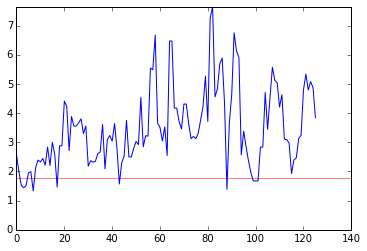


 Cycle number : 2

Lowest Energy 1.49964606685 Sequence ['E', 'A', 'F', 'Y', 'F']



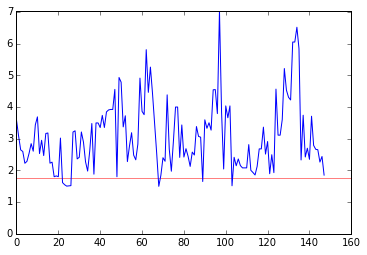


 Cycle number : 3

Lowest Energy 0.922910473965 Sequence ['I', 'I', 'W', 'W', 'H']



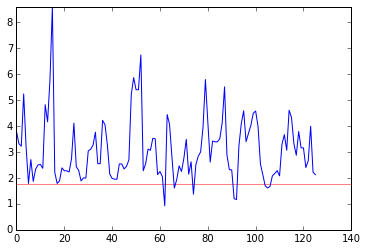


 Cycle number : 4

Lowest Energy 1.28109976334 Sequence ['N', 'L', 'V', 'F', 'W']



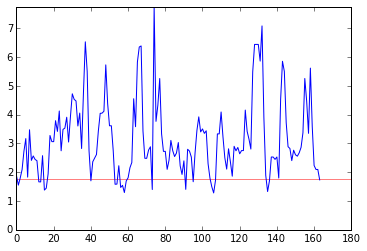


 Cycle number : 5

Lowest Energy 1.18689673592 Sequence ['D', 'G', 'Y', 'H', 'E']



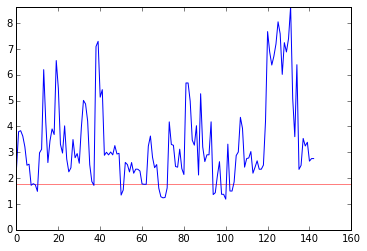

In [127]:
results6_bis = run_mc(1000,test_peptide3, temp=1.0, nb_cycles=5, plot=True,verbose = False)

Name of Peptide PKC
Base Energy 5.96758475963
Base Sequence ['L', 'Q', 'S', 'A', 'V']

 Cycle number : 1

Lowest Energy 15.9271304506 Sequence ['S', 'W', 'R', 'M', 'V']



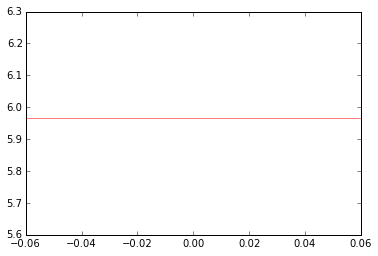


 Cycle number : 2

Lowest Energy 31.4462453389 Sequence ['R', 'R', 'L', 'R', 'R']



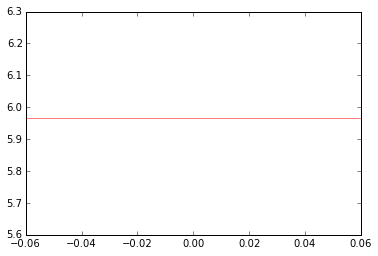


 Cycle number : 3

Lowest Energy 23.7188589154 Sequence ['M', 'E', 'P', 'S', 'V']



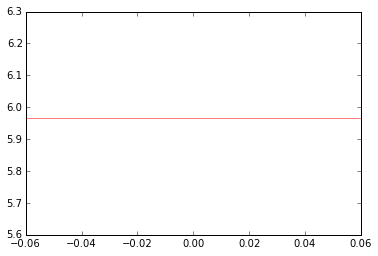


 Cycle number : 4

Lowest Energy 15.2943911212 Sequence ['D', 'M', 'S', 'N', 'R']



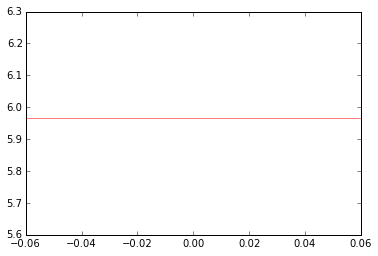


 Cycle number : 5

Lowest Energy 37.5359951383 Sequence ['S', 'K', 'Q', 'G', 'T']



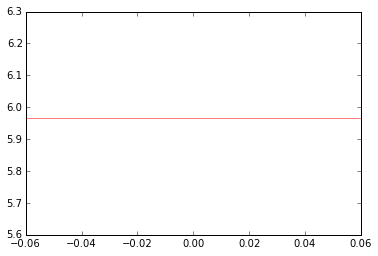

In [132]:
results_random = run_mc(1000,PDZ_Data.peptides[46], temp=1.0, nb_cycles = 5, plot=True, verbose = False)

Interesting, another peptide which doesnt like its sequence being changed at all. Lets try to do this for all the peptides in the database and trace the variation of energy for each of them.

Name of Peptide AN2
Base Energy 32.7714922253
Base Sequence ['G', 'Q', 'Y', 'W', 'V']

 Cycle number : 1

Lowest Energy 1.93084580842 Sequence ['Q', 'M', 'C', 'R', 'L']



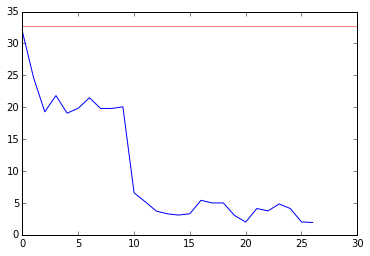

Name of Peptide APC
Base Energy 108.837975035
Base Sequence ['L', 'V', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 1.56533539304 Sequence ['R', 'M', 'N', 'G', 'T']



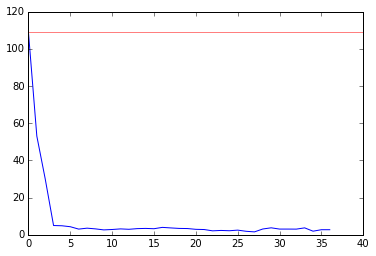

Name of Peptide Aquaporin4
Base Energy 34.688018304
Base Sequence ['V', 'L', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 12.1064561359 Sequence ['A', 'C', 'A', 'I', 'S']



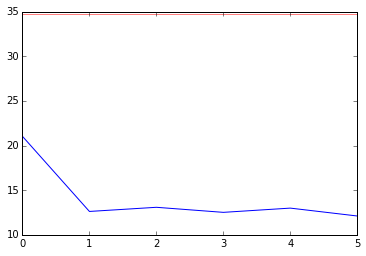

Name of Peptide ASIC2
Base Energy 2.58576358448
Base Sequence ['E', 'E', 'I', 'A', 'C']

 Cycle number : 1

Lowest Energy 1.33080201435 Sequence ['N', 'V', 'I', 'A', 'S']



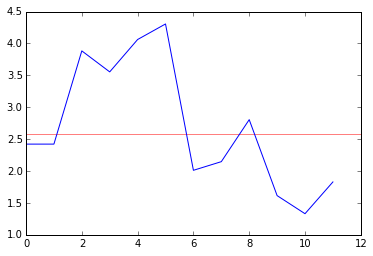

Name of Peptide Caspr2
Base Energy 10.2327578819
Base Sequence ['K', 'E', 'W', 'L', 'I']

 Cycle number : 1

Lowest Energy 13.1126180839 Sequence ['L', 'R', 'M', 'W', 'E']



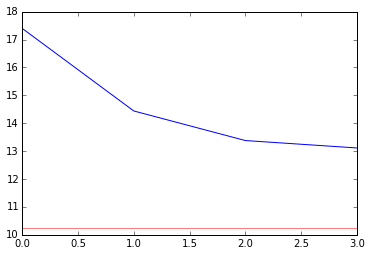

Name of Peptide Cav2.2
Base Energy 7.8158107556
Base Sequence ['Q', 'D', 'H', 'W', 'C']

 Cycle number : 1

Lowest Energy 3.26484746857 Sequence ['K', 'G', 'T', 'E', 'M']



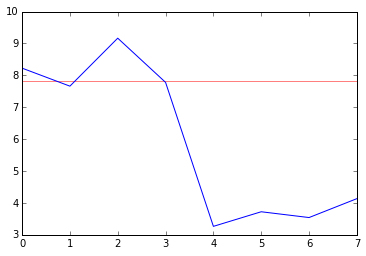

Name of Peptide Cftr
Base Energy 10.1187576025
Base Sequence ['Q', 'E', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 28.9448589443 Sequence ['L', 'T', 'D', 'H', 'E']



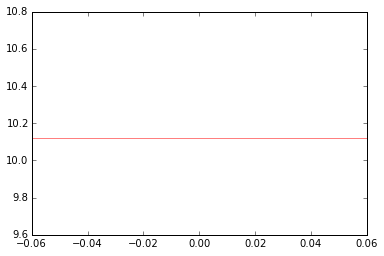

Name of Peptide c-KIT
Base Energy 1.75989867909
Base Sequence ['V', 'H', 'E', 'D', 'A']

 Cycle number : 1

Lowest Energy 1.52976754571 Sequence ['I', 'R', 'L', 'S', 'A']



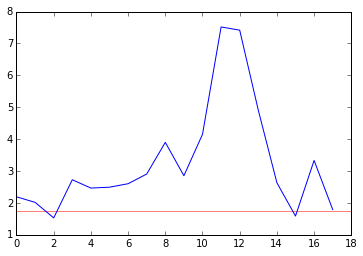

Name of Peptide Claudin1
Base Energy 24.338085902
Base Sequence ['G', 'K', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 3.34025229416 Sequence ['R', 'M', 'C', 'M', 'T']



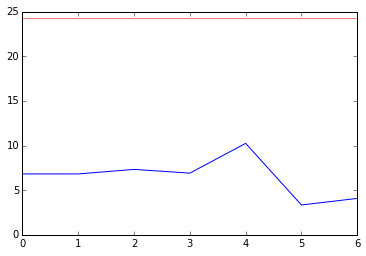

Name of Peptide Cnksr2
Base Energy 6.91618770844
Base Sequence ['I', 'E', 'T', 'H', 'V']

 Cycle number : 1

Lowest Energy 41.9978784153 Sequence ['M', 'W', 'R', 'A', 'M']



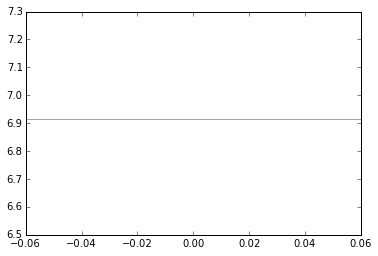

Name of Peptide Connexin43
Base Energy 5.88006436035
Base Sequence ['D', 'D', 'L', 'E', 'I']

 Cycle number : 1

Lowest Energy 5.94630781691 Sequence ['S', 'A', 'C', 'D', 'G']



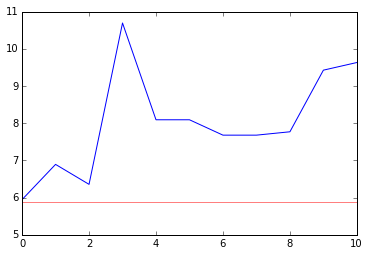

Name of Peptide CRIPT
Base Energy 15.9107823407
Base Sequence ['K', 'Q', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 57.4657854934 Sequence ['H', 'K', 'Y', 'K', 'E']



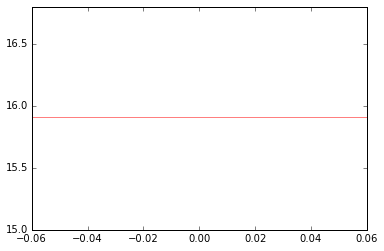

Name of Peptide CtBP1
Base Energy 25.6643013809
Base Sequence ['T', 'S', 'D', 'Q', 'L']

 Cycle number : 1

Lowest Energy 1.4219877456 Sequence ['T', 'I', 'A', 'I', 'K']



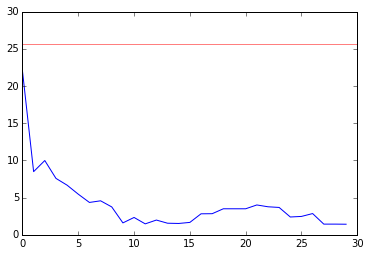

Name of Peptide Dlgap123
Base Energy 7.07795685126
Base Sequence ['A', 'Q', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 10.1602243757 Sequence ['P', 'Y', 'L', 'Y', 'G']



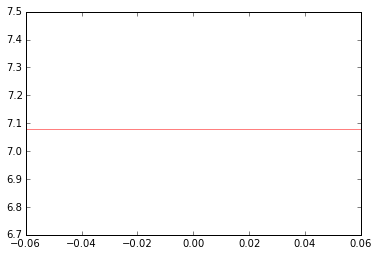

Name of Peptide EphA71
Base Energy 2.55142344213
Base Sequence ['T', 'G', 'I', 'Q', 'V']

 Cycle number : 1

Lowest Energy 4.50292774989 Sequence ['I', 'P', 'G', 'A', 'A']



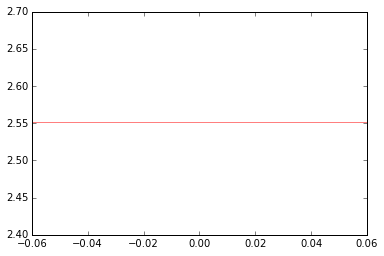

Name of Peptide EphB2
Base Energy 11.4576849544
Base Sequence ['Q', 'S', 'V', 'E', 'V']

 Cycle number : 1

Lowest Energy 5.10692228202 Sequence ['H', 'Q', 'D', 'W', 'M']



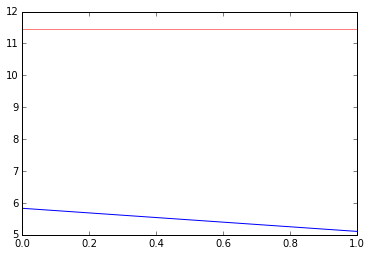

Name of Peptide EphrinB12
Base Energy 1.6607904112
Base Sequence ['I', 'Y', 'Y', 'K', 'V']

 Cycle number : 1

Lowest Energy 1.79777591833 Sequence ['K', 'K', 'I', 'C', 'T']



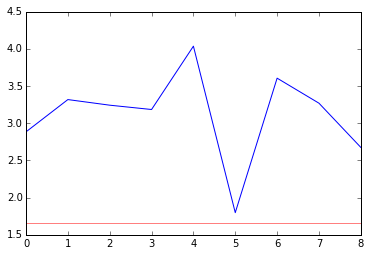

Name of Peptide ErbB4
Base Energy 4.5055182776
Base Sequence ['T', 'A', 'E', 'M', 'F']

 Cycle number : 1

Lowest Energy 4.5055182776 Sequence ['S', 'Q', 'W', 'W', 'S']



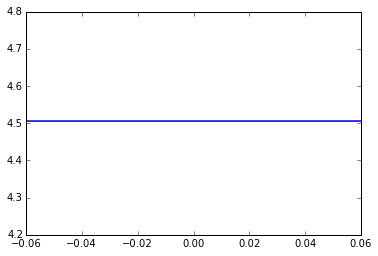

Name of Peptide Frizzled
Base Energy 28.4843578527
Base Sequence ['G', 'E', 'T', 'T', 'V']

 Cycle number : 1

Lowest Energy 19.3468320217 Sequence ['H', 'D', 'R', 'D', 'G']



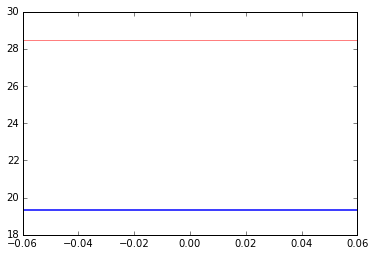

Name of Peptide GluR1
Base Energy 7.08075331182
Base Sequence ['G', 'A', 'T', 'G', 'L']

 Cycle number : 1

Lowest Energy 3.97549732999 Sequence ['W', 'I', 'G', 'N', 'D']



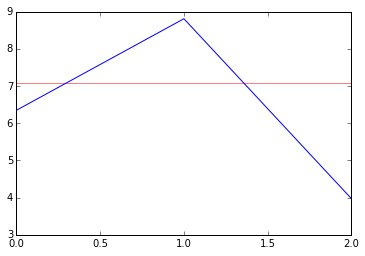

Name of Peptide GluR2_1
Base Energy 8.96655307331
Base Sequence ['E', 'S', 'V', 'K', 'I']

 Cycle number : 1

Lowest Energy 1.4457311591 Sequence ['Q', 'E', 'I', 'P', 'T']



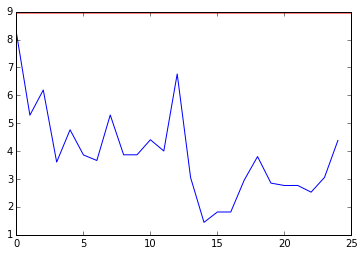

Name of Peptide GluR5_1
Base Energy 28.5435975345
Base Sequence ['K', 'E', 'T', 'V', 'A']

 Cycle number : 1

Lowest Energy 12.8714767768 Sequence ['M', 'E', 'L', 'P', 'S']



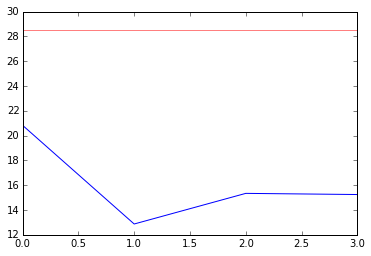

Name of Peptide GlycphrinC
Base Energy 55.5078676101
Base Sequence ['K', 'E', 'Y', 'F', 'I']

 Cycle number : 1

Lowest Energy 5.40728067977 Sequence ['D', 'K', 'R', 'P', 'Y']



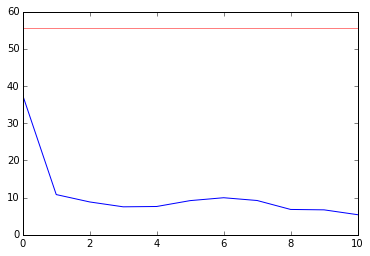

Name of Peptide GRK6
Base Energy 18.068508857
Base Sequence ['L', 'P', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 23.6363884644 Sequence ['I', 'L', 'V', 'Y', 'N']



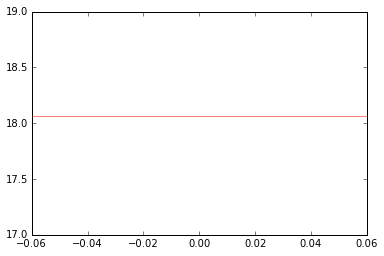

Name of Peptide Htr2c
Base Energy 5.87031674462
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 5.87031674462 Sequence ['F', 'P', 'W', 'F', 'Y']



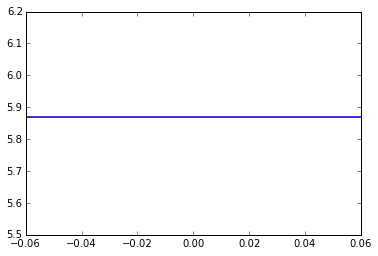

Name of Peptide JAM-1
Base Energy 6.36765080863
Base Sequence ['S', 'S', 'F', 'L', 'V']

 Cycle number : 1

Lowest Energy 2.32212684988 Sequence ['L', 'M', 'F', 'D', 'E']



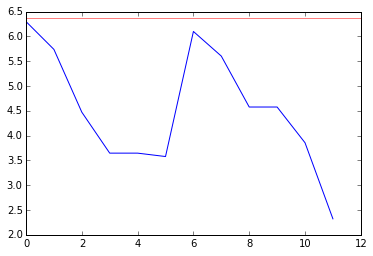

Name of Peptide KIF17
Base Energy 4.01838283588
Base Sequence ['G', 'G', 'E', 'P', 'L']

 Cycle number : 1

Lowest Energy 1.81226911503 Sequence ['Y', 'W', 'Q', 'S', 'S']



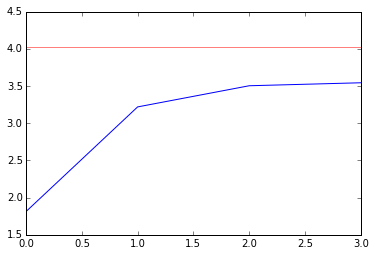

Name of Peptide KIF1B
Base Energy 26.4271991025
Base Sequence ['R', 'E', 'T', 'T', 'V']

 Cycle number : 1

Lowest Energy 24.3106989605 Sequence ['I', 'M', 'S', 'G', 'I']



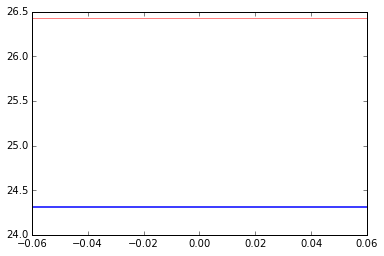

Name of Peptide Kir2.1
Base Energy 28.5088245181
Base Sequence ['R', 'E', 'S', 'E', 'I']

 Cycle number : 1

Lowest Energy 15.8655994671 Sequence ['P', 'C', 'E', 'F', 'V']



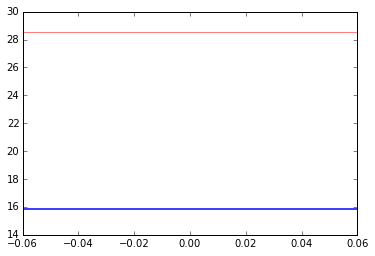

Name of Peptide Kv1.4
Base Energy 49.9055472783
Base Sequence ['V', 'E', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 17.5685838694 Sequence ['T', 'D', 'M', 'V', 'H']



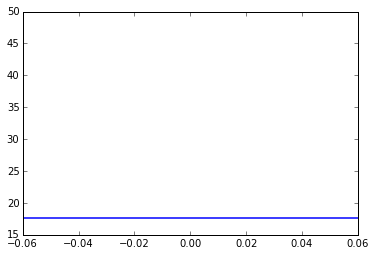

Name of Peptide Lgltminase
Base Energy 4.54834097666
Base Sequence ['L', 'E', 'S', 'M', 'V']

 Cycle number : 1

Lowest Energy 4.40649824577 Sequence ['Q', 'M', 'P', 'C', 'E']



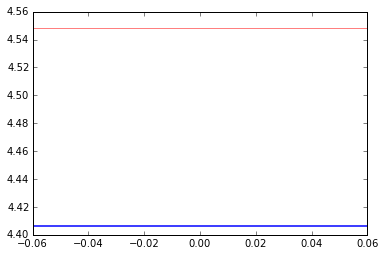

Name of Peptide Liprin2
Base Energy 7.84514190615
Base Sequence ['R', 'T', 'Y', 'S', 'C']

 Cycle number : 1

Lowest Energy 2.03986285922 Sequence ['G', 'P', 'E', 'C', 'M']



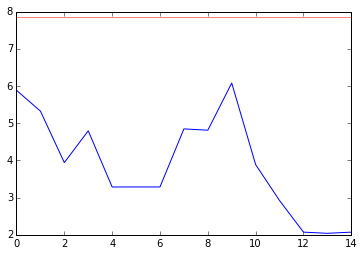

Name of Peptide Megalin
Base Energy 6.7113293881
Base Sequence ['E', 'D', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 15.9623816888 Sequence ['W', 'A', 'F', 'T', 'A']



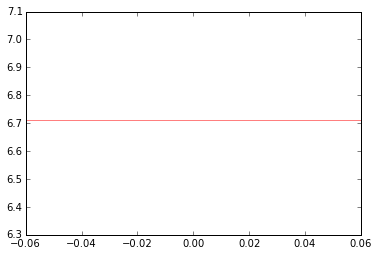

Name of Peptide Mel1a/b
Base Energy 17.76549867
Base Sequence ['K', 'V', 'D', 'S', 'V']

 Cycle number : 1

Lowest Energy 15.7192104259 Sequence ['Q', 'P', 'S', 'W', 'L']



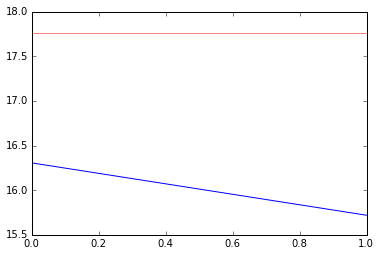

Name of Peptide mGluR3
Base Energy 10.059792039
Base Sequence ['T', 'T', 'S', 'S', 'L']

 Cycle number : 1

Lowest Energy 10.0368928247 Sequence ['A', 'P', 'T', 'R', 'R']



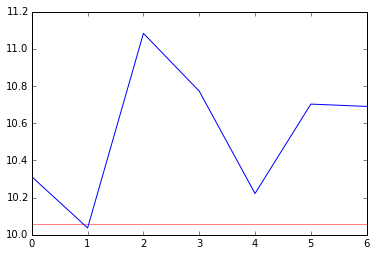

Name of Peptide ctransprtr
Base Energy 3.70916853858
Base Sequence ['N', 'A', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 30.8697636542 Sequence ['M', 'V', 'P', 'I', 'T']



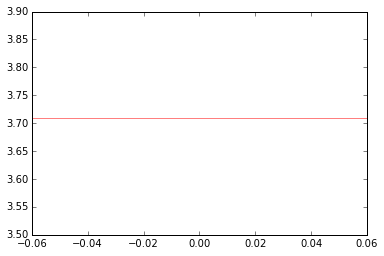

Name of Peptide Nav1.4
Base Energy 18.1065927851
Base Sequence ['K', 'E', 'S', 'L', 'V']

 Cycle number : 1

Lowest Energy 35.6297506766 Sequence ['G', 'P', 'I', 'Y', 'A']



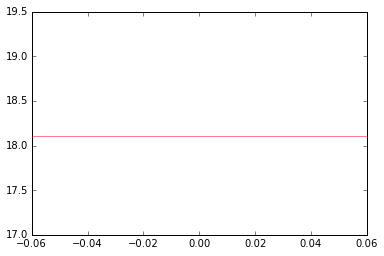

Name of Peptide Nav1.5
Base Energy 19.5874496371
Base Sequence ['R', 'E', 'S', 'I', 'V']

 Cycle number : 1

Lowest Energy 19.8545004931 Sequence ['W', 'Y', 'L', 'E', 'T']



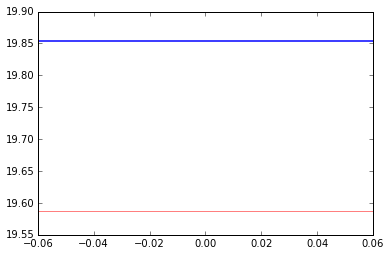

Name of Peptide Neurxin1/2
Base Energy 34.7545858124
Base Sequence ['K', 'E', 'Y', 'Y', 'V']

 Cycle number : 1

Lowest Energy 19.3590222863 Sequence ['V', 'N', 'S', 'F', 'H']



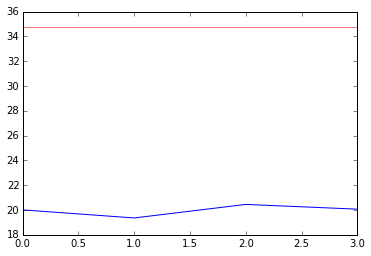

Name of Peptide NMDAR2A
Base Energy 24.0655913503
Base Sequence ['I', 'E', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 4.04040846598 Sequence ['C', 'E', 'W', 'D', 'R']



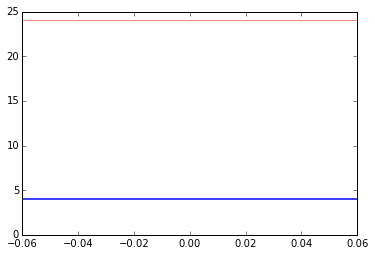

Name of Peptide NMDAR2B
Base Energy 17.5025963503
Base Sequence ['I', 'E', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 18.4258606026 Sequence ['I', 'R', 'G', 'H', 'I']



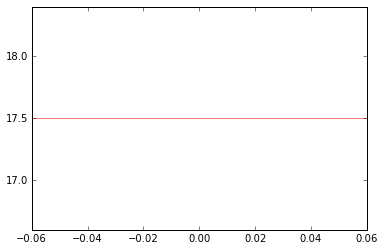

Name of Peptide P2Y1
Base Energy 28.625230555
Base Sequence ['G', 'D', 'T', 'S', 'L']

 Cycle number : 1

Lowest Energy 39.6212608007 Sequence ['R', 'V', 'T', 'P', 'P']



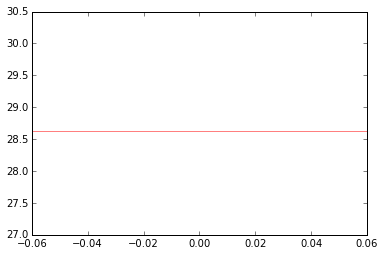

Name of Peptide Parkin
Base Energy 2.06541536473
Base Sequence ['H', 'W', 'F', 'D', 'V']

 Cycle number : 1

Lowest Energy 1.12447580088 Sequence ['S', 'I', 'M', 'Y', 'N']



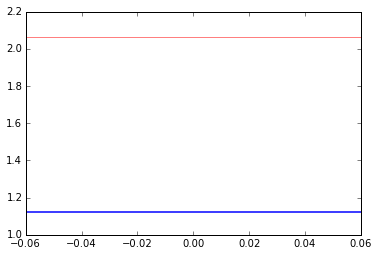

Name of Peptide PDGFR
Base Energy 14.6647382588
Base Sequence ['E', 'D', 'S', 'F', 'L']

 Cycle number : 1

Lowest Energy 1.84340267909 Sequence ['P', 'V', 'H', 'V', 'P']



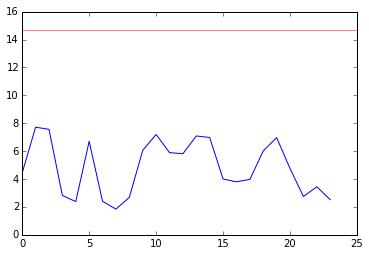

Name of Peptide PFK-M
Base Energy 15.2354145009
Base Sequence ['G', 'E', 'A', 'A', 'V']

 Cycle number : 1

Lowest Energy 1.35284921989 Sequence ['N', 'D', 'M', 'W', 'T']



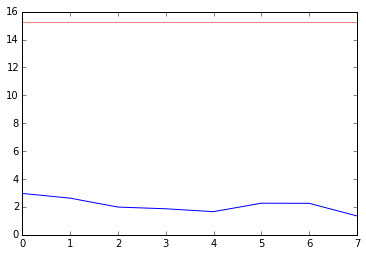

Name of Peptide PIX
Base Energy 27.0731044414
Base Sequence ['D', 'E', 'T', 'N', 'L']

 Cycle number : 1

Lowest Energy 18.5211034988 Sequence ['T', 'L', 'Y', 'W', 'V']



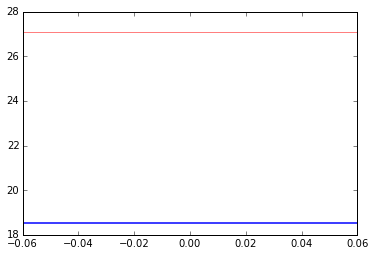

Name of Peptide PKC
Base Energy 5.96758475963
Base Sequence ['L', 'Q', 'S', 'A', 'V']

 Cycle number : 1

Lowest Energy 7.40018410413 Sequence ['I', 'T', 'P', 'S', 'K']



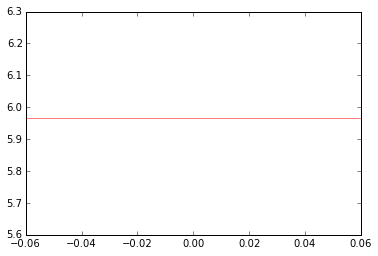

Name of Peptide PMCA1
Base Energy 30.2193108669
Base Sequence ['L', 'E', 'T', 'S', 'L']

 Cycle number : 1

Lowest Energy 28.3061803462 Sequence ['K', 'P', 'C', 'D', 'L']



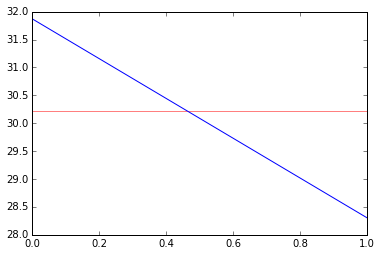

Name of Peptide Ril
Base Energy 31.9187527305
Base Sequence ['K', 'V', 'E', 'L', 'V']

 Cycle number : 1

Lowest Energy 20.8719776282 Sequence ['Q', 'H', 'R', 'I', 'D']



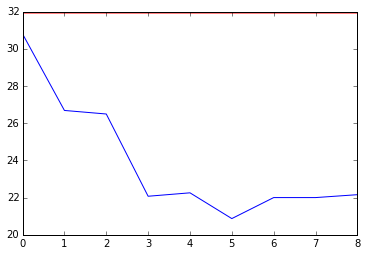

Name of Peptide Sapk3
Base Energy 25.7589244175
Base Sequence ['K', 'E', 'T', 'A', 'L']

 Cycle number : 1

Lowest Energy 16.9919545629 Sequence ['F', 'M', 'A', 'P', 'D']



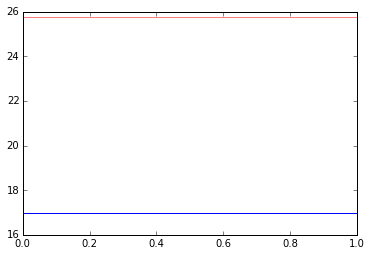

Name of Peptide SSTR2
Base Energy 8.04013252582
Base Sequence ['I', 'I', 'A', 'W', 'V']

 Cycle number : 1

Lowest Energy 17.7172171509 Sequence ['A', 'A', 'E', 'T', 'K']



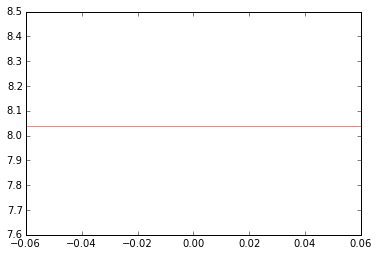

Name of Peptide Stargazin
Base Energy 19.2404872197
Base Sequence ['R', 'T', 'T', 'P', 'V']

 Cycle number : 1

Lowest Energy 3.37496797205 Sequence ['D', 'S', 'P', 'A', 'R']



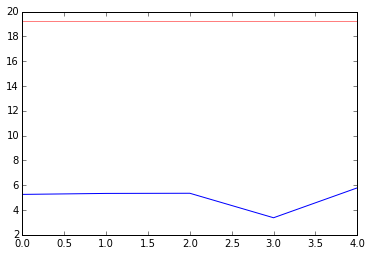

Name of Peptide Syndecan1
Base Energy 20.1300898057
Base Sequence ['E', 'E', 'F', 'Y', 'A']

 Cycle number : 1

Lowest Energy 1.4963057036 Sequence ['F', 'S', 'L', 'C', 'Q']



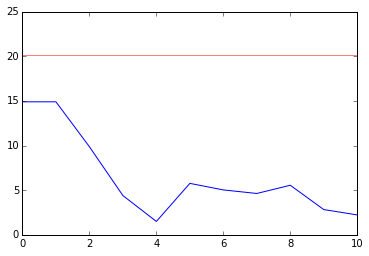

Name of Peptide Syndecan2
Base Energy 36.8856289754
Base Sequence ['K', 'E', 'F', 'Y', 'A']

 Cycle number : 1

Lowest Energy 7.41174821859 Sequence ['W', 'W', 'V', 'K', 'T']



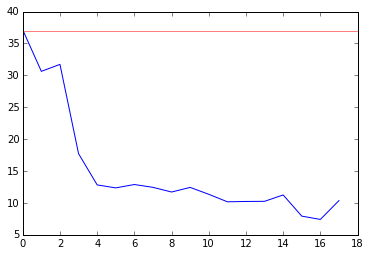

Name of Peptide TAZ
Base Energy 17.1937505167
Base Sequence ['F', 'L', 'T', 'W', 'L']

 Cycle number : 1

Lowest Energy 7.62776434469 Sequence ['W', 'H', 'V', 'M', 'R']



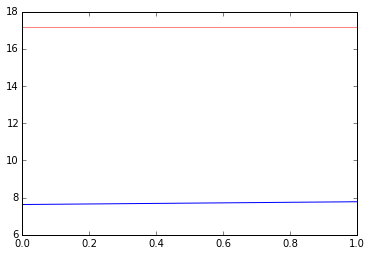

Name of Peptide Trip6
Base Energy 21.3116037858
Base Sequence ['V', 'T', 'T', 'D', 'C']

 Cycle number : 1

Lowest Energy 2.23278455555 Sequence ['S', 'H', 'G', 'Y', 'K']



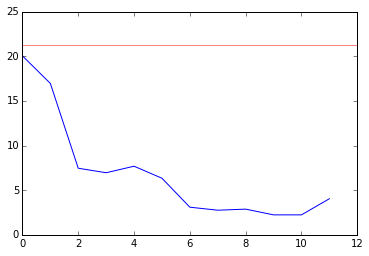

Name of Peptide TRPC4
Base Energy 3.49309391044
Base Sequence ['V', 'T', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 3.49309391044 Sequence ['W', 'G', 'F', 'C', 'G']



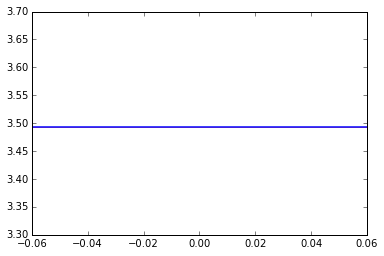

Name of Peptide AcvR1
Base Energy 8.1782910361
Base Sequence ['L', 'K', 'T', 'D', 'C']

 Cycle number : 1

Lowest Energy 1.94337477584 Sequence ['S', 'N', 'N', 'P', 'E']



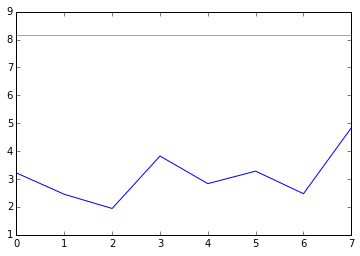

Name of Peptide AcvR2
Base Energy 28.2894100244
Base Sequence ['K', 'E', 'S', 'S', 'L']

 Cycle number : 1

Lowest Energy 19.8343448534 Sequence ['H', 'E', 'L', 'M', 'D']



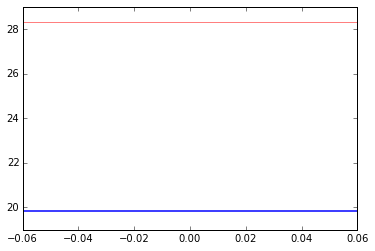

Name of Peptide AcvR2b
Base Energy 36.0467473257
Base Sequence ['K', 'E', 'S', 'S', 'I']

 Cycle number : 1

Lowest Energy 16.706724531 Sequence ['I', 'L', 'P', 'Q', 'E']



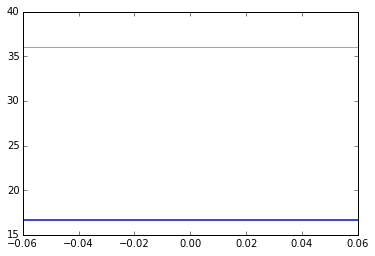

Name of Peptide Cacna1a
Base Energy 17.1905846257
Base Sequence ['E', 'D', 'D', 'W', 'C']

 Cycle number : 1

Lowest Energy 2.65006666063 Sequence ['P', 'R', 'C', 'N', 'P']



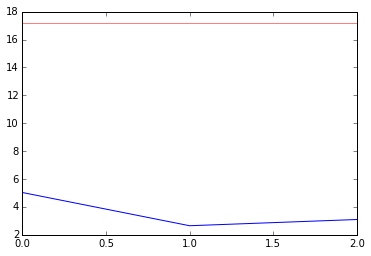

Name of Peptide Cav1.2
Base Energy 54.0718184806
Base Sequence ['Y', 'V', 'S', 'N', 'L']

 Cycle number : 1

Lowest Energy 7.66248704041 Sequence ['P', 'M', 'Y', 'C', 'D']



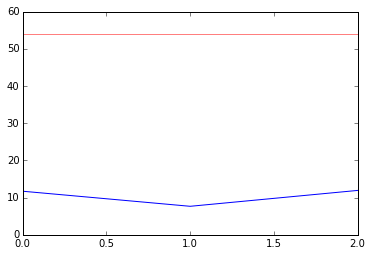

Name of Peptide Cav2.3
Base Energy 4.74582296906
Base Sequence ['E', 'D', 'D', 'K', 'C']

 Cycle number : 1

Lowest Energy 1.32277583553 Sequence ['Y', 'P', 'Y', 'W', 'F']



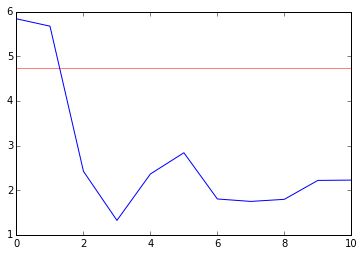

Name of Peptide Cav3.2
Base Energy 2.13818288188
Base Sequence ['G', 'D', 'E', 'P', 'V']

 Cycle number : 1

Lowest Energy 1.96950447028 Sequence ['N', 'W', 'V', 'D', 'D']



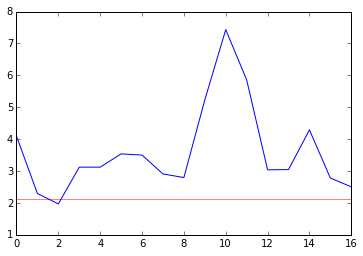

Name of Peptide ITPR3
Base Energy 3.90395331342
Base Sequence ['N', 'C', 'M', 'S', 'R']

 Cycle number : 1

Lowest Energy 1.72611391437 Sequence ['F', 'D', 'K', 'Q', 'T']



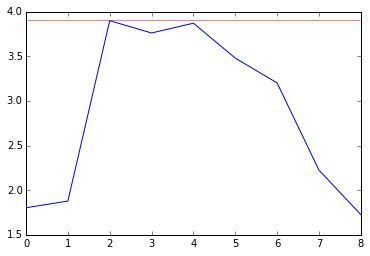

Name of Peptide RYR2
Base Energy 4.81261114343
Base Sequence ['E', 'D', 'Q', 'L', 'N']

 Cycle number : 1

Lowest Energy 2.12906151814 Sequence ['M', 'H', 'K', 'A', 'V']



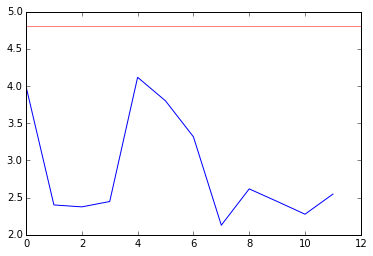

Name of Peptide SERCA1
Base Energy 13.7805269613
Base Sequence ['N', 'Y', 'L', 'E', 'G']

 Cycle number : 1

Lowest Energy 1.87070224808 Sequence ['K', 'P', 'N', 'F', 'Y']



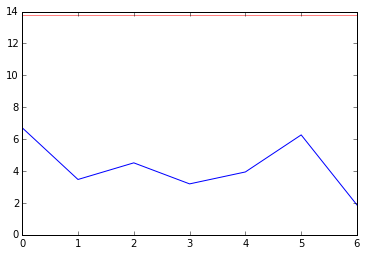

Name of Peptide SERCA2A
Base Energy 5.04661264325
Base Sequence ['P', 'A', 'I', 'L', 'E']

 Cycle number : 1

Lowest Energy 1.45962558585 Sequence ['K', 'T', 'W', 'L', 'N']



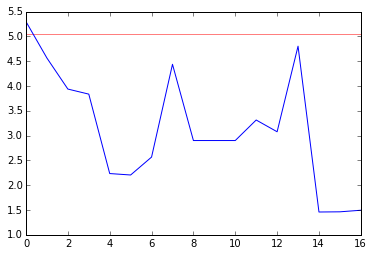

Name of Peptide SERCA3
Base Energy 6.2704518053
Base Sequence ['V', 'W', 'P', 'S', 'D']

 Cycle number : 1

Lowest Energy 1.98683168455 Sequence ['C', 'R', 'A', 'L', 'K']



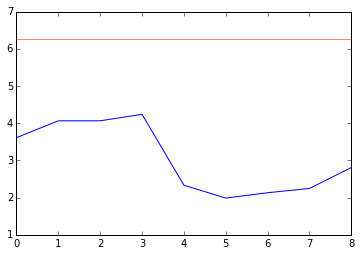

Name of Peptide TPC1
Base Energy 8.92322025265
Base Sequence ['S', 'Q', 'T', 'V', 'T']

 Cycle number : 1

Lowest Energy 2.22911515302 Sequence ['E', 'C', 'F', 'R', 'Y']



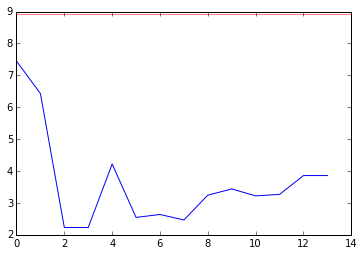

Name of Peptide Claudin2
Base Energy 11.3170000173
Base Sequence ['L', 'T', 'G', 'Y', 'V']

 Cycle number : 1

Lowest Energy 5.48732305896 Sequence ['I', 'E', 'Y', 'C', 'W']



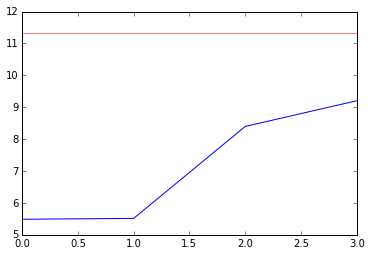

Name of Peptide Claudin3
Base Energy 7.17366012465
Base Sequence ['R', 'K', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.58284784732 Sequence ['H', 'Y', 'Y', 'H', 'I']



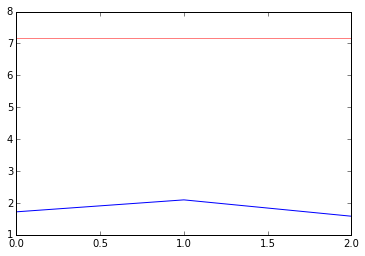

Name of Peptide Claudin4
Base Energy 9.66498096644
Base Sequence ['A', 'S', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.97202951254 Sequence ['I', 'A', 'M', 'H', 'E']



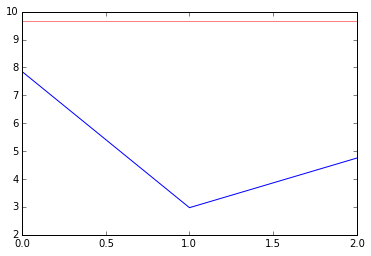

Name of Peptide Claudin5
Base Energy 69.1904204791
Base Sequence ['K', 'K', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 11.9763482532 Sequence ['Y', 'F', 'N', 'R', 'V']



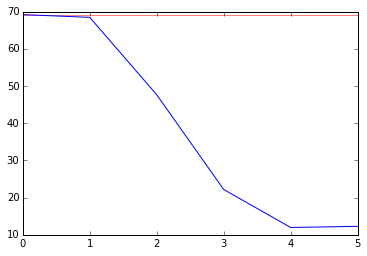

Name of Peptide Claudin6
Base Energy 52.2853897426
Base Sequence ['T', 'K', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 4.95854651781 Sequence ['Q', 'R', 'V', 'V', 'M']



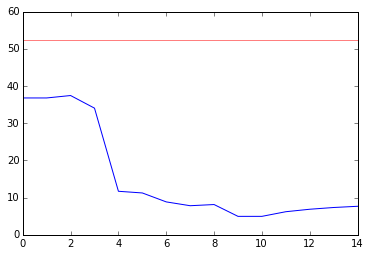

Name of Peptide Claudin7
Base Energy 14.8914186154
Base Sequence ['S', 'K', 'E', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.72921970357 Sequence ['I', 'H', 'K', 'D', 'W']



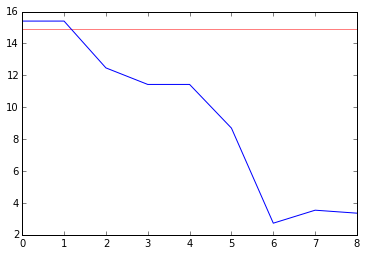

Name of Peptide Claudin8
Base Energy 7.60195464094
Base Sequence ['K', 'S', 'Q', 'Y', 'V']

 Cycle number : 1

Lowest Energy 14.2543140047 Sequence ['Q', 'H', 'F', 'D', 'V']



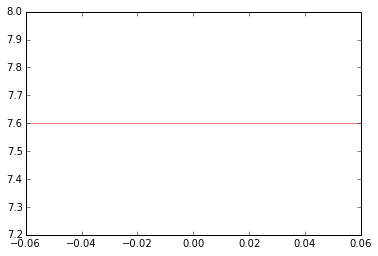

Name of Peptide Claudin9
Base Energy 13.0920258928
Base Sequence ['K', 'R', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 9.98368390301 Sequence ['I', 'S', 'R', 'C', 'L']



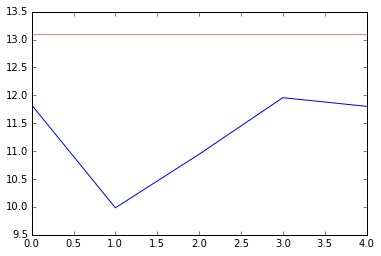

Name of Peptide Claudin10
Base Energy 20.0984636691
Base Sequence ['K', 'N', 'A', 'Y', 'V']

 Cycle number : 1

Lowest Energy 9.66639777284 Sequence ['C', 'F', 'L', 'A', 'N']



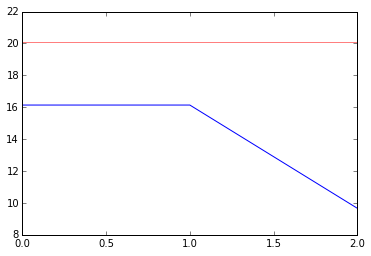

Name of Peptide Claudin11
Base Energy 19.3286831196
Base Sequence ['K', 'S', 'A', 'H', 'V']

 Cycle number : 1

Lowest Energy 3.2304075077 Sequence ['V', 'G', 'T', 'L', 'L']



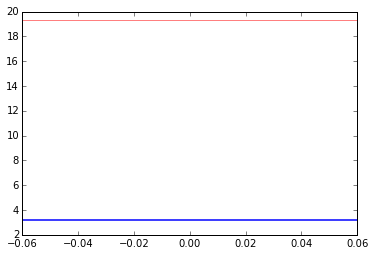

Name of Peptide Claudin13
Base Energy 5.36008828371
Base Sequence ['D', 'T', 'L', 'D', 'V']

 Cycle number : 1

Lowest Energy 1.89137786897 Sequence ['W', 'T', 'C', 'E', 'W']



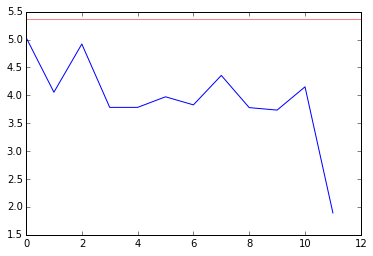

Name of Peptide Claudin14
Base Energy 1.69869817987
Base Sequence ['L', 'N', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.74259413184 Sequence ['D', 'K', 'V', 'W', 'I']



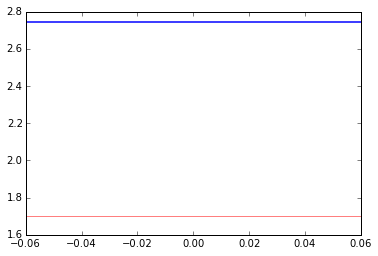

Name of Peptide Claudin15
Base Energy 20.0984636691
Base Sequence ['K', 'N', 'A', 'Y', 'V']

 Cycle number : 1

Lowest Energy 12.0114498014 Sequence ['W', 'K', 'H', 'T', 'Y']



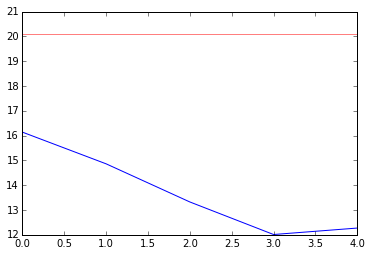

Name of Peptide Claudin16
Base Energy 33.1307825301
Base Sequence ['V', 'D', 'T', 'R', 'V']

 Cycle number : 1

Lowest Energy 3.94328556716 Sequence ['Q', 'M', 'I', 'C', 'P']



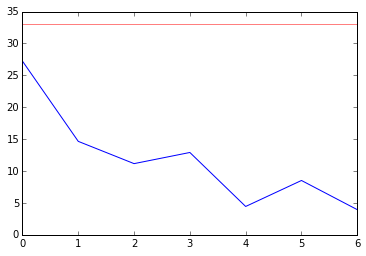

Name of Peptide Claudin18
Base Energy 29.3482977089
Base Sequence ['K', 'Y', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 4.88718278641 Sequence ['S', 'F', 'N', 'E', 'L']



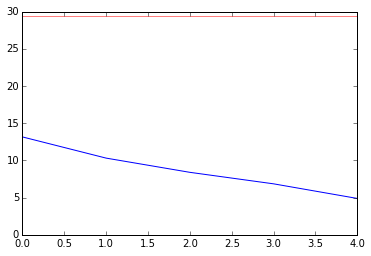

Name of Peptide Claudin19
Base Energy 4.89381545106
Base Sequence ['A', 'R', 'E', 'Y', 'V']

 Cycle number : 1

Lowest Energy 4.42459099779 Sequence ['N', 'S', 'S', 'Q', 'C']



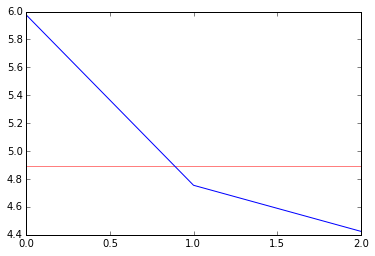

Name of Peptide Claudin22
Base Energy 2.30310124649
Base Sequence ['A', 'N', 'P', 'E', 'I']

 Cycle number : 1

Lowest Energy 1.72940149476 Sequence ['N', 'P', 'S', 'L', 'L']



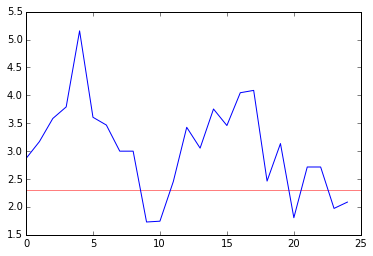

Name of Peptide Claudin23
Base Energy 2.47978086236
Base Sequence ['C', 'D', 'S', 'D', 'L']

 Cycle number : 1

Lowest Energy 3.17126837385 Sequence ['L', 'E', 'A', 'W', 'H']



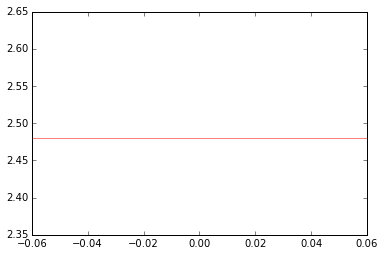

Name of Peptide EphrinB3
Base Energy 1.6607904112
Base Sequence ['I', 'Y', 'Y', 'K', 'V']

 Cycle number : 1

Lowest Energy 1.91451561933 Sequence ['S', 'C', 'F', 'F', 'H']



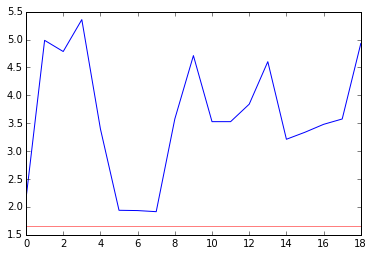

Name of Peptide GluR2_2
Base Energy 8.59842602681
Base Sequence ['V', 'T', 'D', 'L', 'S']

 Cycle number : 1

Lowest Energy 1.57809155828 Sequence ['I', 'E', 'N', 'W', 'T']



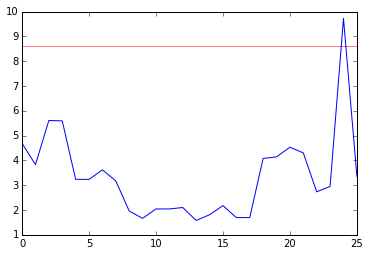

Name of Peptide GluR2_3
Base Energy 6.26261640287
Base Sequence ['L', 'G', 'W', 'V', 'E']

 Cycle number : 1

Lowest Energy 1.67899481233 Sequence ['H', 'N', 'I', 'I', 'I']



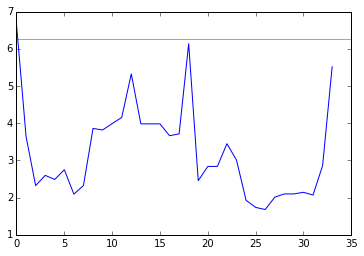

Name of Peptide GluR3
Base Energy 20.4335030733
Base Sequence ['E', 'S', 'V', 'K', 'I']

 Cycle number : 1

Lowest Energy 1.76621096986 Sequence ['T', 'G', 'Q', 'C', 'I']



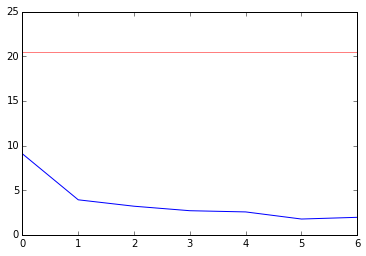

Name of Peptide GluR5_2
Base Energy 31.6788017701
Base Sequence ['S', 'V', 'H', 'T', 'V']

 Cycle number : 1

Lowest Energy 2.75039427493 Sequence ['E', 'D', 'N', 'G', 'Q']



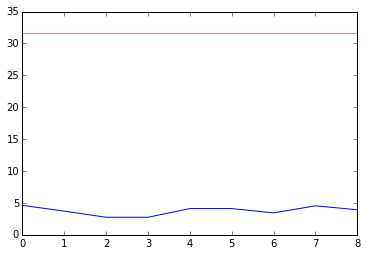

Name of Peptide GluRdelta1
Base Energy 30.759492334
Base Sequence ['H', 'G', 'T', 'S', 'I']

 Cycle number : 1

Lowest Energy 14.6489648017 Sequence ['V', 'H', 'Q', 'R', 'A']



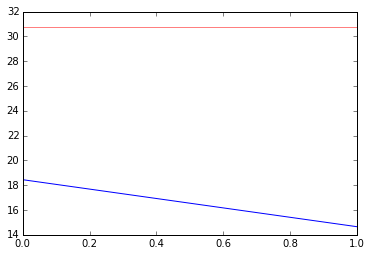

Name of Peptide GluRdelta2
Base Energy 23.7971790916
Base Sequence ['R', 'G', 'T', 'S', 'I']

 Cycle number : 1

Lowest Energy 8.30695822391 Sequence ['F', 'K', 'P', 'I', 'P']



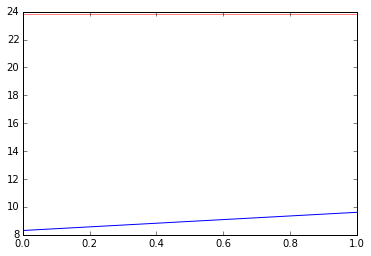

Name of Peptide KA-2
Base Energy 12.6744224267
Base Sequence ['L', 'T', 'E', 'H', 'E']

 Cycle number : 1

Lowest Energy 1.85785480716 Sequence ['K', 'I', 'W', 'N', 'I']



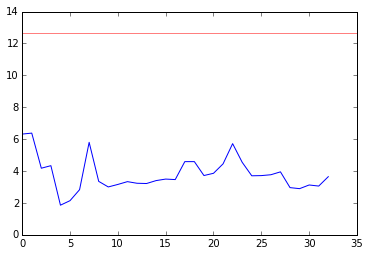

Name of Peptide mGluR1
Base Energy 15.8797011742
Base Sequence ['S', 'S', 'S', 'T', 'L']

 Cycle number : 1

Lowest Energy 6.31003847199 Sequence ['D', 'Q', 'D', 'Q', 'E']



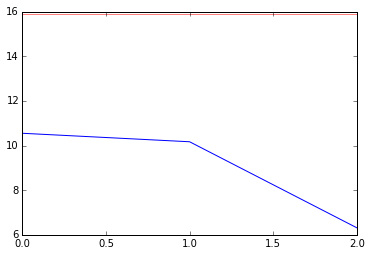

Name of Peptide NMDAR1
Base Energy 1.99695789843
Base Sequence ['R', 'H', 'R', 'E', 'S']

 Cycle number : 1

Lowest Energy 1.17648285088 Sequence ['N', 'N', 'D', 'I', 'D']



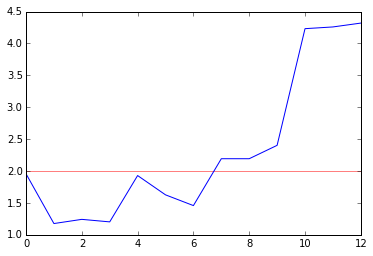

Name of Peptide NMDAR2C
Base Energy 29.899606913
Base Sequence ['L', 'E', 'S', 'E', 'V']

 Cycle number : 1

Lowest Energy 47.9724094817 Sequence ['E', 'R', 'P', 'T', 'N']



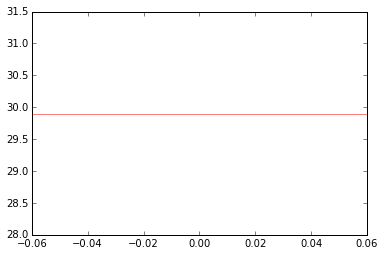

Name of Peptide NMDAR2D
Base Energy 22.839446913
Base Sequence ['L', 'E', 'S', 'E', 'V']

 Cycle number : 1

Lowest Energy 26.4920103279 Sequence ['F', 'A', 'W', 'M', 'K']



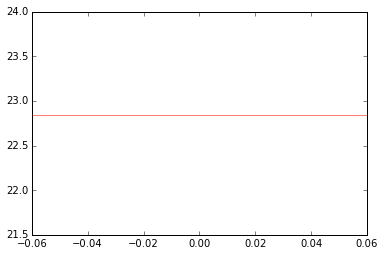

In [135]:
for i in range(100):
    results = run_mc(100, PDZ_Data.peptides[i], temp=1.0,nb_cycles = 1, plot=True, verbose=False)

Name of Peptide AN2
Base Energy 32.7714922253
Base Sequence ['G', 'Q', 'Y', 'W', 'V']

 Cycle number : 1

Lowest Energy 1.99717678 Sequence ['K', 'P', 'C', 'E', 'D']



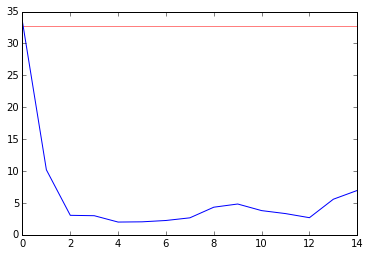

Name of Peptide APC
Base Energy 108.837975035
Base Sequence ['L', 'V', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 1.10590353039 Sequence ['W', 'N', 'M', 'M', 'P']



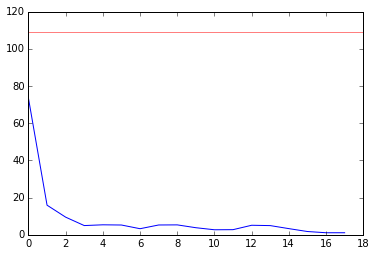

Name of Peptide Aquaporin4
Base Energy 34.688018304
Base Sequence ['V', 'L', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 6.81115004576 Sequence ['E', 'S', 'H', 'M', 'C']



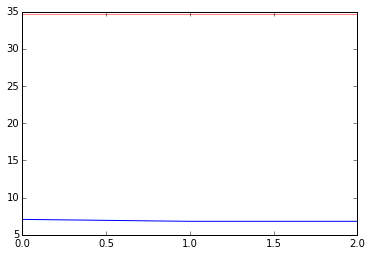

Name of Peptide ASIC2
Base Energy 2.58576358448
Base Sequence ['E', 'E', 'I', 'A', 'C']

 Cycle number : 1

Lowest Energy 1.43876231533 Sequence ['R', 'V', 'M', 'D', 'K']



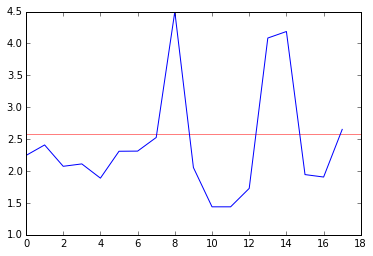

Name of Peptide Caspr2
Base Energy 10.2327578819
Base Sequence ['K', 'E', 'W', 'L', 'I']

 Cycle number : 1

Lowest Energy 5.39664537693 Sequence ['E', 'P', 'K', 'M', 'R']



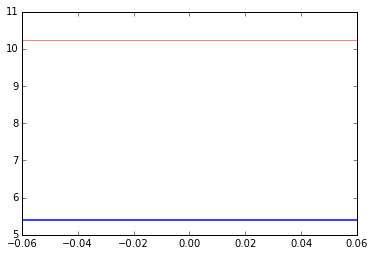

Name of Peptide Cav2.2
Base Energy 7.8158107556
Base Sequence ['Q', 'D', 'H', 'W', 'C']

 Cycle number : 1

Lowest Energy 1.95671771474 Sequence ['S', 'L', 'G', 'A', 'E']



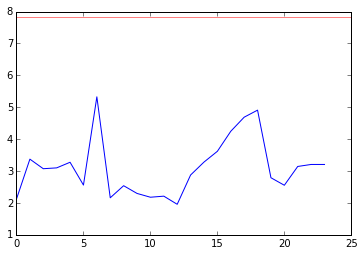

Name of Peptide Cftr
Base Energy 10.1187576025
Base Sequence ['Q', 'E', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 15.7318230602 Sequence ['C', 'H', 'H', 'V', 'G']



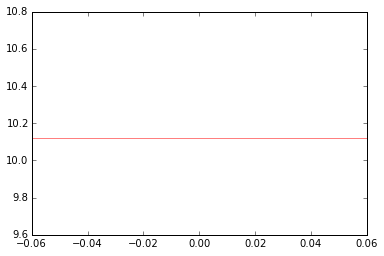

Name of Peptide c-KIT
Base Energy 1.75989867909
Base Sequence ['V', 'H', 'E', 'D', 'A']

 Cycle number : 1

Lowest Energy 1.26651007459 Sequence ['C', 'T', 'V', 'Y', 'I']



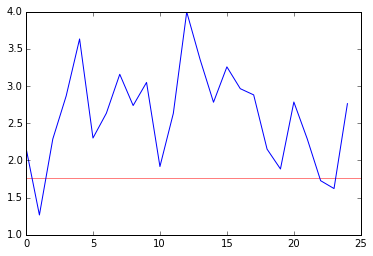

Name of Peptide Claudin1
Base Energy 24.338085902
Base Sequence ['G', 'K', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 3.82029663103 Sequence ['V', 'A', 'S', 'T', 'W']



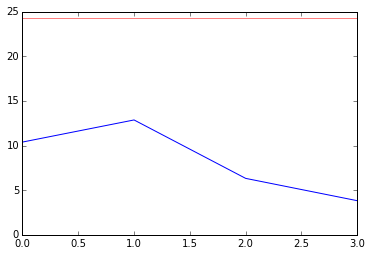

Name of Peptide Cnksr2
Base Energy 6.91618770844
Base Sequence ['I', 'E', 'T', 'H', 'V']

 Cycle number : 1

Lowest Energy 29.9925758044 Sequence ['F', 'H', 'H', 'D', 'Q']



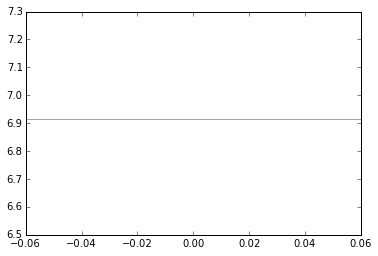

Name of Peptide Connexin43
Base Energy 5.88006436035
Base Sequence ['D', 'D', 'L', 'E', 'I']

 Cycle number : 1

Lowest Energy 4.43271616812 Sequence ['K', 'W', 'W', 'N', 'M']



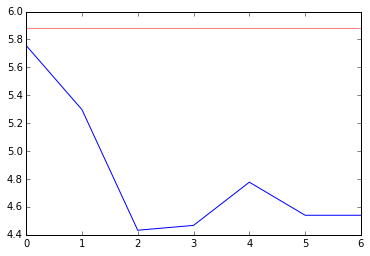

Name of Peptide CRIPT
Base Energy 15.9107823407
Base Sequence ['K', 'Q', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 38.9595417931 Sequence ['F', 'Q', 'M', 'P', 'V']



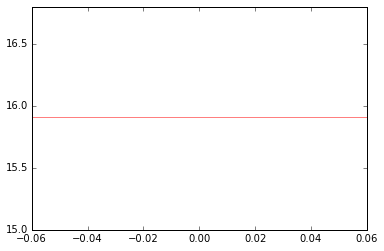

Name of Peptide CtBP1
Base Energy 25.6643013809
Base Sequence ['T', 'S', 'D', 'Q', 'L']

 Cycle number : 1

Lowest Energy 1.57642465987 Sequence ['I', 'F', 'C', 'T', 'Y']



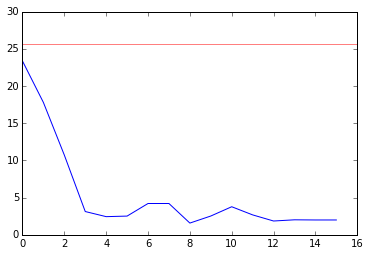

Name of Peptide Dlgap123
Base Energy 7.07795685126
Base Sequence ['A', 'Q', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 12.3316235373 Sequence ['E', 'Q', 'F', 'G', 'K']



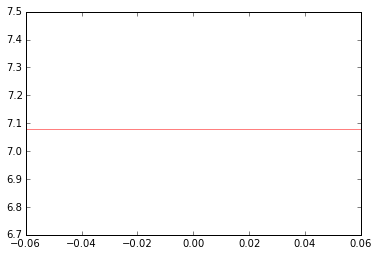

Name of Peptide EphA71
Base Energy 2.55142344213
Base Sequence ['T', 'G', 'I', 'Q', 'V']

 Cycle number : 1

Lowest Energy 11.2943996171 Sequence ['G', 'N', 'E', 'E', 'F']



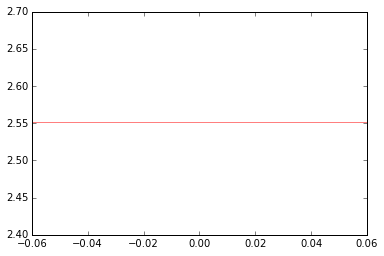

Name of Peptide EphB2
Base Energy 11.4576849544
Base Sequence ['Q', 'S', 'V', 'E', 'V']

 Cycle number : 1

Lowest Energy 5.54817564364 Sequence ['F', 'T', 'I', 'R', 'E']



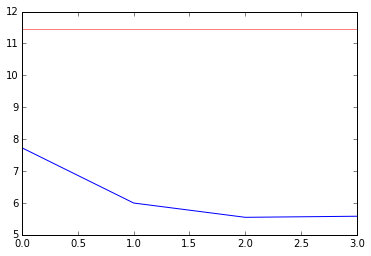

Name of Peptide EphrinB12
Base Energy 1.6607904112
Base Sequence ['I', 'Y', 'Y', 'K', 'V']

 Cycle number : 1

Lowest Energy 1.74039252208 Sequence ['S', 'V', 'M', 'V', 'F']



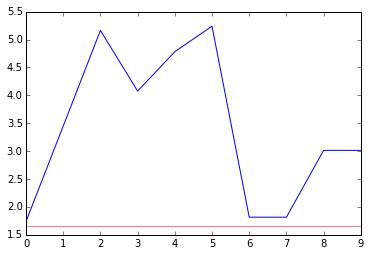

Name of Peptide ErbB4
Base Energy 4.5055182776
Base Sequence ['T', 'A', 'E', 'M', 'F']

 Cycle number : 1

Lowest Energy 2.65534463093 Sequence ['I', 'C', 'S', 'G', 'A']



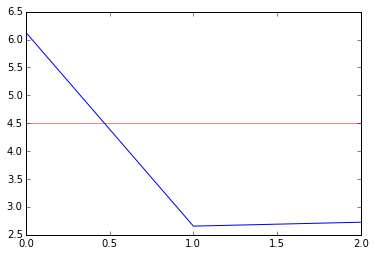

Name of Peptide Frizzled
Base Energy 28.4843578527
Base Sequence ['G', 'E', 'T', 'T', 'V']

 Cycle number : 1

Lowest Energy 21.6549659397 Sequence ['G', 'H', 'C', 'Q', 'N']



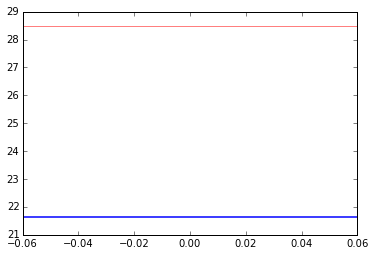

Name of Peptide GluR1
Base Energy 7.08075331182
Base Sequence ['G', 'A', 'T', 'G', 'L']

 Cycle number : 1

Lowest Energy 3.13040465725 Sequence ['G', 'D', 'P', 'M', 'D']



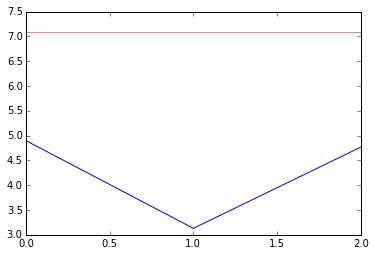

Name of Peptide GluR2_1
Base Energy 8.96655307331
Base Sequence ['E', 'S', 'V', 'K', 'I']

 Cycle number : 1

Lowest Energy 1.64956492346 Sequence ['I', 'Y', 'F', 'I', 'F']



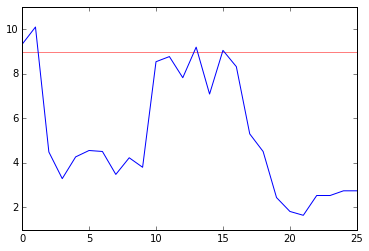

Name of Peptide GluR5_1
Base Energy 28.5435975345
Base Sequence ['K', 'E', 'T', 'V', 'A']

 Cycle number : 1

Lowest Energy 9.23502795147 Sequence ['T', 'H', 'Y', 'V', 'E']



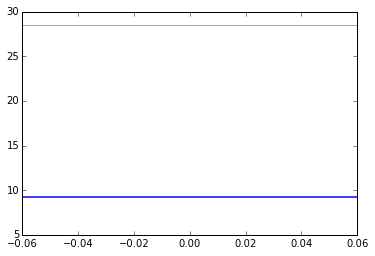

Name of Peptide GlycphrinC
Base Energy 55.5078676101
Base Sequence ['K', 'E', 'Y', 'F', 'I']

 Cycle number : 1

Lowest Energy 5.61848913659 Sequence ['T', 'D', 'K', 'S', 'T']



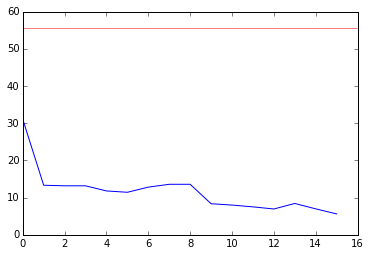

Name of Peptide GRK6
Base Energy 18.068508857
Base Sequence ['L', 'P', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 18.2425558312 Sequence ['S', 'L', 'V', 'S', 'R']



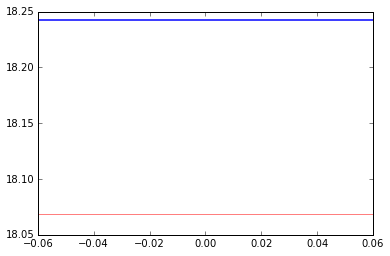

Name of Peptide Htr2c
Base Energy 5.87031674462
Base Sequence ['R', 'I', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 6.05955007818 Sequence ['V', 'Q', 'Q', 'R', 'F']



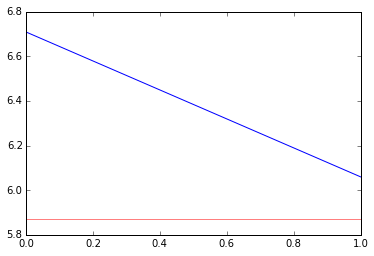

Name of Peptide JAM-1
Base Energy 6.36765080863
Base Sequence ['S', 'S', 'F', 'L', 'V']

 Cycle number : 1

Lowest Energy 1.74077351405 Sequence ['F', 'L', 'Q', 'L', 'C']



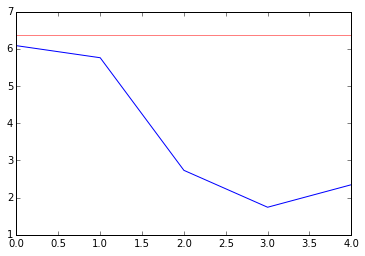

Name of Peptide KIF17
Base Energy 4.01838283588
Base Sequence ['G', 'G', 'E', 'P', 'L']

 Cycle number : 1

Lowest Energy 2.18327973747 Sequence ['A', 'K', 'E', 'L', 'P']



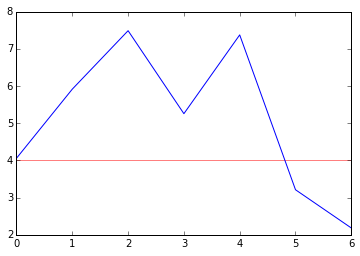

Name of Peptide KIF1B
Base Energy 26.4271991025
Base Sequence ['R', 'E', 'T', 'T', 'V']

 Cycle number : 1

Lowest Energy 6.18270827335 Sequence ['I', 'R', 'H', 'C', 'Y']



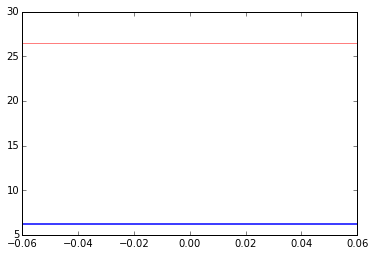

Name of Peptide Kir2.1
Base Energy 28.5088245181
Base Sequence ['R', 'E', 'S', 'E', 'I']

 Cycle number : 1

Lowest Energy 13.5057509382 Sequence ['F', 'P', 'F', 'S', 'S']



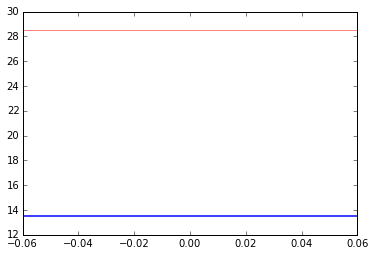

Name of Peptide Kv1.4
Base Energy 49.9055472783
Base Sequence ['V', 'E', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 24.7603120467 Sequence ['K', 'I', 'C', 'W', 'Q']



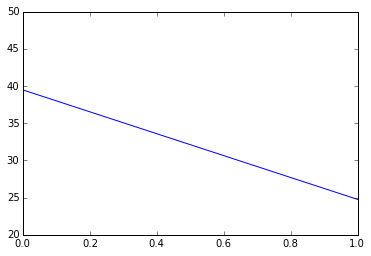

Name of Peptide Lgltminase
Base Energy 4.54834097666
Base Sequence ['L', 'E', 'S', 'M', 'V']

 Cycle number : 1

Lowest Energy 15.0835140925 Sequence ['T', 'C', 'I', 'M', 'V']



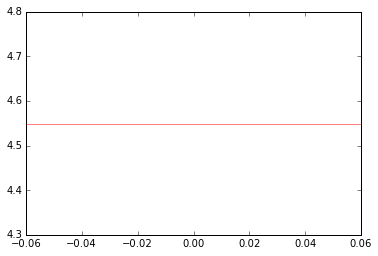

Name of Peptide Liprin2
Base Energy 7.84514190615
Base Sequence ['R', 'T', 'Y', 'S', 'C']

 Cycle number : 1

Lowest Energy 1.44169156928 Sequence ['W', 'H', 'G', 'I', 'E']



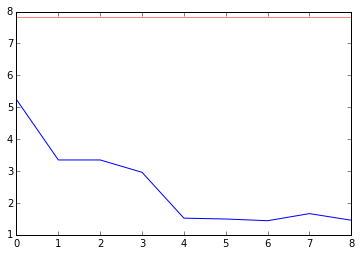

Name of Peptide Megalin
Base Energy 6.7113293881
Base Sequence ['E', 'D', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 14.4832103696 Sequence ['N', 'E', 'R', 'C', 'V']



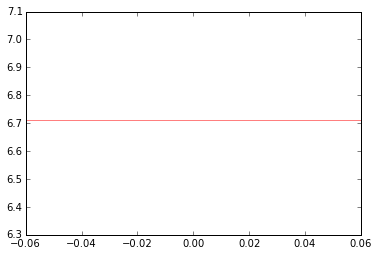

Name of Peptide Mel1a/b
Base Energy 17.76549867
Base Sequence ['K', 'V', 'D', 'S', 'V']

 Cycle number : 1

Lowest Energy 3.08132186664 Sequence ['T', 'M', 'A', 'N', 'E']



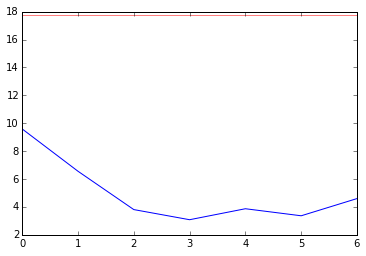

Name of Peptide mGluR3
Base Energy 10.059792039
Base Sequence ['T', 'T', 'S', 'S', 'L']

 Cycle number : 1

Lowest Energy 11.801110062 Sequence ['Y', 'D', 'G', 'G', 'P']



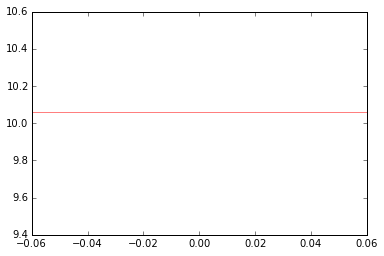

Name of Peptide ctransprtr
Base Energy 3.70916853858
Base Sequence ['N', 'A', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 19.2102301534 Sequence ['G', 'N', 'H', 'M', 'R']



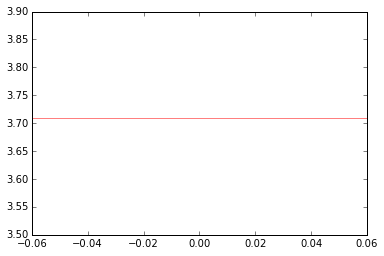

Name of Peptide Nav1.4
Base Energy 18.1065927851
Base Sequence ['K', 'E', 'S', 'L', 'V']

 Cycle number : 1

Lowest Energy 51.8739637361 Sequence ['T', 'D', 'E', 'W', 'Y']



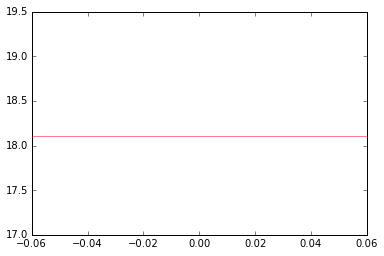

Name of Peptide Nav1.5
Base Energy 19.5874496371
Base Sequence ['R', 'E', 'S', 'I', 'V']

 Cycle number : 1

Lowest Energy 19.1557311344 Sequence ['W', 'W', 'V', 'E', 'K']



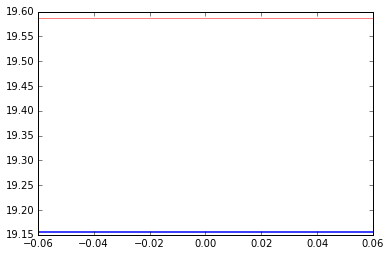

Name of Peptide Neurxin1/2
Base Energy 34.7545858124
Base Sequence ['K', 'E', 'Y', 'Y', 'V']

 Cycle number : 1

Lowest Energy 17.5685299259 Sequence ['N', 'H', 'F', 'H', 'V']



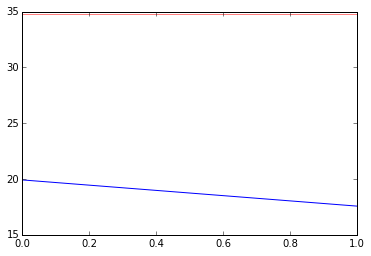

Name of Peptide NMDAR2A
Base Energy 24.0655913503
Base Sequence ['I', 'E', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 12.7553519612 Sequence ['K', 'D', 'D', 'N', 'W']



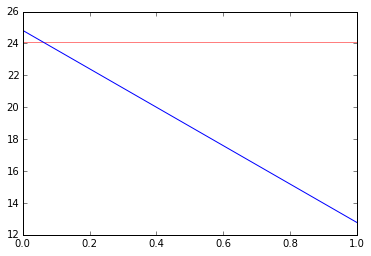

Name of Peptide NMDAR2B
Base Energy 17.5025963503
Base Sequence ['I', 'E', 'S', 'D', 'V']

 Cycle number : 1

Lowest Energy 22.7017574387 Sequence ['I', 'Q', 'T', 'E', 'V']



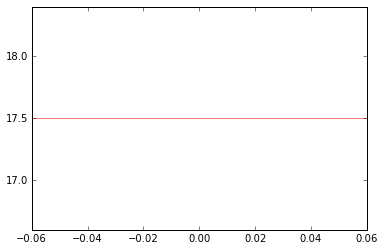

Name of Peptide P2Y1
Base Energy 28.625230555
Base Sequence ['G', 'D', 'T', 'S', 'L']

 Cycle number : 1

Lowest Energy 27.9794031381 Sequence ['F', 'C', 'K', 'T', 'G']



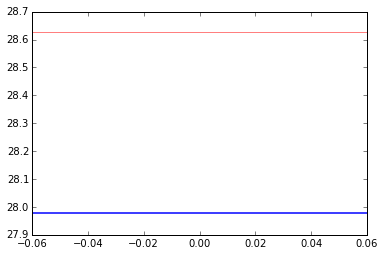

Name of Peptide Parkin
Base Energy 2.06541536473
Base Sequence ['H', 'W', 'F', 'D', 'V']

 Cycle number : 1

Lowest Energy 7.33066869472 Sequence ['G', 'Q', 'K', 'I', 'N']



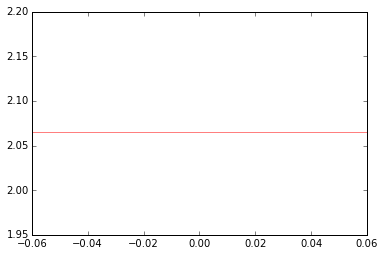

Name of Peptide PDGFR
Base Energy 14.6647382588
Base Sequence ['E', 'D', 'S', 'F', 'L']

 Cycle number : 1

Lowest Energy 2.55754159938 Sequence ['V', 'W', 'Y', 'I', 'K']



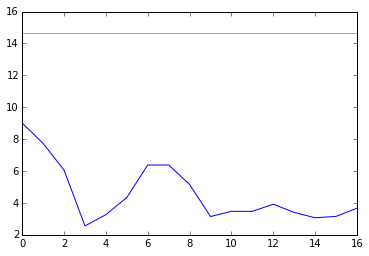

Name of Peptide PFK-M
Base Energy 15.2354145009
Base Sequence ['G', 'E', 'A', 'A', 'V']

 Cycle number : 1

Lowest Energy 1.75527027683 Sequence ['L', 'E', 'V', 'H', 'L']



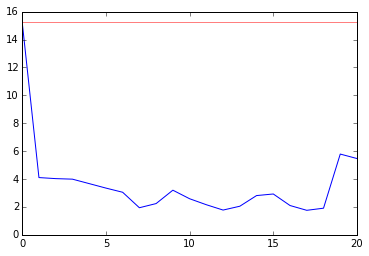

Name of Peptide PIX
Base Energy 27.0731044414
Base Sequence ['D', 'E', 'T', 'N', 'L']

 Cycle number : 1

Lowest Energy 13.9751864717 Sequence ['W', 'E', 'N', 'A', 'Y']



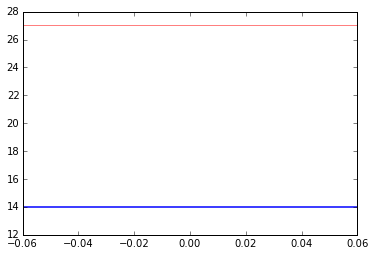

Name of Peptide PKC
Base Energy 5.96758475963
Base Sequence ['L', 'Q', 'S', 'A', 'V']

 Cycle number : 1

Lowest Energy 24.7474949443 Sequence ['R', 'W', 'S', 'N', 'V']



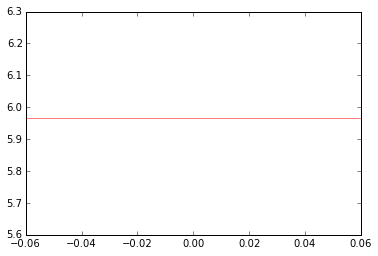

Name of Peptide PMCA1
Base Energy 30.2193108669
Base Sequence ['L', 'E', 'T', 'S', 'L']

 Cycle number : 1

Lowest Energy 33.8608409719 Sequence ['E', 'K', 'W', 'C', 'L']



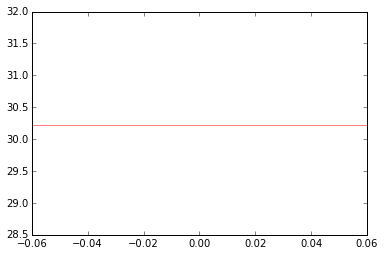

Name of Peptide Ril
Base Energy 31.9187527305
Base Sequence ['K', 'V', 'E', 'L', 'V']

 Cycle number : 1

Lowest Energy 17.1389159967 Sequence ['C', 'D', 'V', 'P', 'M']



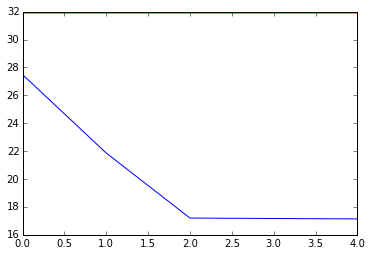

Name of Peptide Sapk3
Base Energy 25.7589244175
Base Sequence ['K', 'E', 'T', 'A', 'L']

 Cycle number : 1

Lowest Energy 42.3761990507 Sequence ['I', 'I', 'V', 'S', 'I']



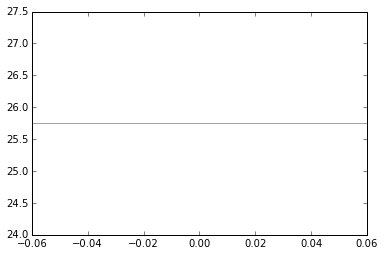

Name of Peptide SSTR2
Base Energy 8.04013252582
Base Sequence ['I', 'I', 'A', 'W', 'V']

 Cycle number : 1

Lowest Energy 14.1873268492 Sequence ['N', 'P', 'F', 'L', 'A']



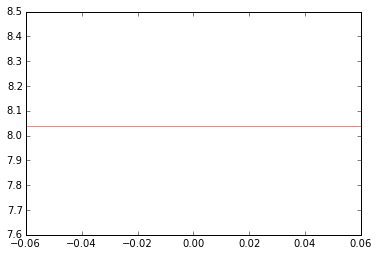

Name of Peptide Stargazin
Base Energy 19.2404872197
Base Sequence ['R', 'T', 'T', 'P', 'V']

 Cycle number : 1

Lowest Energy 4.24532697099 Sequence ['K', 'Q', 'S', 'G', 'G']



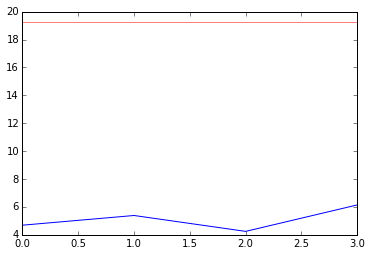

Name of Peptide Syndecan1
Base Energy 20.1300898057
Base Sequence ['E', 'E', 'F', 'Y', 'A']

 Cycle number : 1

Lowest Energy 4.99924781589 Sequence ['R', 'D', 'S', 'I', 'V']



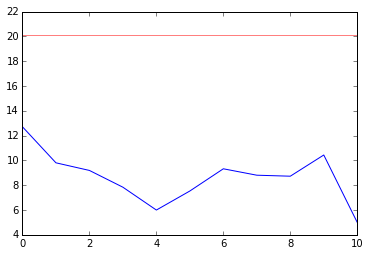

Name of Peptide Syndecan2
Base Energy 36.8856289754
Base Sequence ['K', 'E', 'F', 'Y', 'A']

 Cycle number : 1

Lowest Energy 7.51254871485 Sequence ['L', 'R', 'K', 'I', 'S']



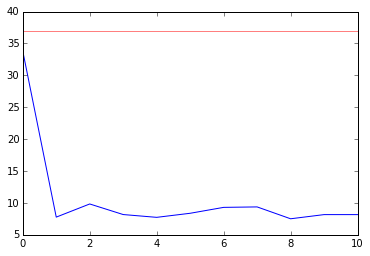

Name of Peptide TAZ
Base Energy 17.1937505167
Base Sequence ['F', 'L', 'T', 'W', 'L']

 Cycle number : 1

Lowest Energy 46.7546451908 Sequence ['H', 'P', 'W', 'T', 'E']



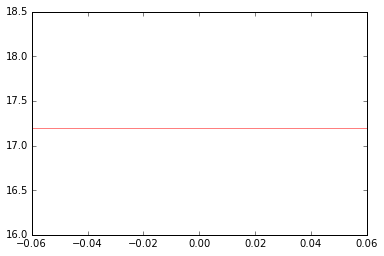

Name of Peptide Trip6
Base Energy 21.3116037858
Base Sequence ['V', 'T', 'T', 'D', 'C']

 Cycle number : 1

Lowest Energy 1.44592121162 Sequence ['G', 'R', 'H', 'E', 'F']



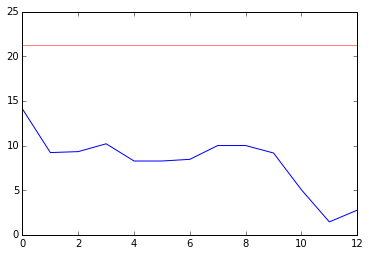

Name of Peptide TRPC4
Base Energy 3.49309391044
Base Sequence ['V', 'T', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 2.31783541564 Sequence ['M', 'C', 'C', 'Y', 'S']



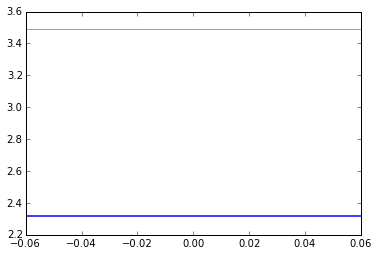

Name of Peptide AcvR1
Base Energy 8.1782910361
Base Sequence ['L', 'K', 'T', 'D', 'C']

 Cycle number : 1

Lowest Energy 2.51915834133 Sequence ['L', 'R', 'N', 'R', 'I']



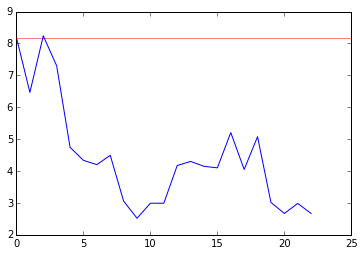

Name of Peptide AcvR2
Base Energy 28.2894100244
Base Sequence ['K', 'E', 'S', 'S', 'L']

 Cycle number : 1

Lowest Energy 17.3308264855 Sequence ['I', 'R', 'L', 'D', 'W']



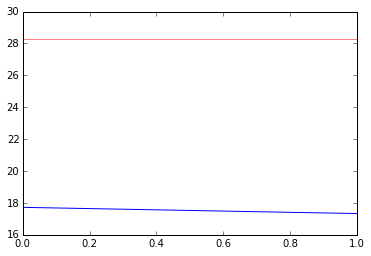

Name of Peptide AcvR2b
Base Energy 36.0467473257
Base Sequence ['K', 'E', 'S', 'S', 'I']

 Cycle number : 1

Lowest Energy 32.6714610412 Sequence ['D', 'R', 'T', 'D', 'K']



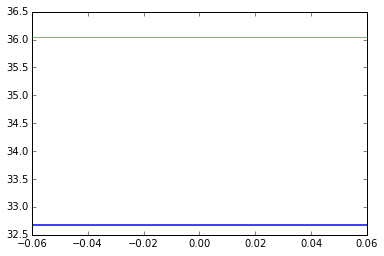

Name of Peptide Cacna1a
Base Energy 17.1905846257
Base Sequence ['E', 'D', 'D', 'W', 'C']

 Cycle number : 1

Lowest Energy 4.76403857944 Sequence ['R', 'T', 'P', 'D', 'D']



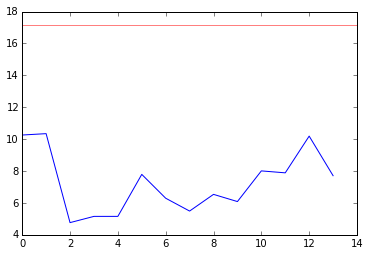

Name of Peptide Cav1.2
Base Energy 54.0718184806
Base Sequence ['Y', 'V', 'S', 'N', 'L']

 Cycle number : 1

Lowest Energy 11.0082806261 Sequence ['Y', 'A', 'N', 'C', 'A']



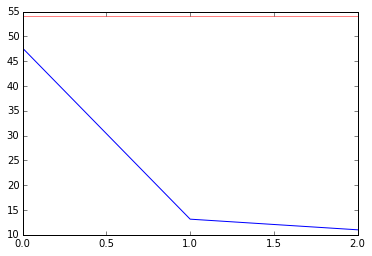

Name of Peptide Cav2.3
Base Energy 4.74582296906
Base Sequence ['E', 'D', 'D', 'K', 'C']

 Cycle number : 1

Lowest Energy 1.58868735323 Sequence ['P', 'G', 'G', 'V', 'M']



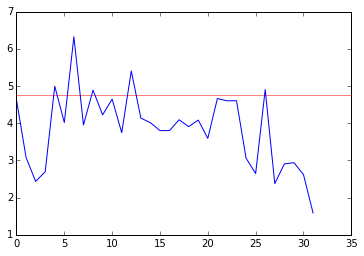

Name of Peptide Cav3.2
Base Energy 2.13818288188
Base Sequence ['G', 'D', 'E', 'P', 'V']

 Cycle number : 1

Lowest Energy 1.67312744156 Sequence ['H', 'A', 'S', 'M', 'H']



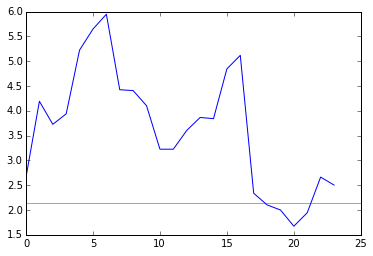

Name of Peptide ITPR3
Base Energy 3.90395331342
Base Sequence ['N', 'C', 'M', 'S', 'R']

 Cycle number : 1

Lowest Energy 1.79984848318 Sequence ['L', 'L', 'G', 'I', 'T']



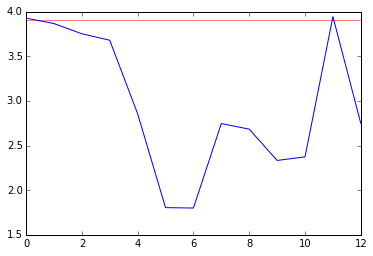

Name of Peptide RYR2
Base Energy 4.81261114343
Base Sequence ['E', 'D', 'Q', 'L', 'N']

 Cycle number : 1

Lowest Energy 2.64925158507 Sequence ['F', 'Y', 'Y', 'H', 'V']



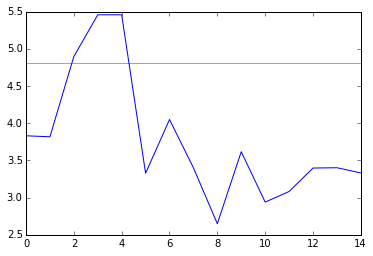

Name of Peptide SERCA1
Base Energy 13.7805269613
Base Sequence ['N', 'Y', 'L', 'E', 'G']

 Cycle number : 1

Lowest Energy 1.08906278782 Sequence ['P', 'S', 'E', 'Y', 'P']



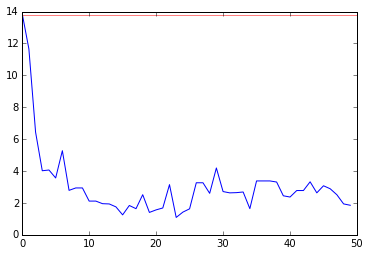

Name of Peptide SERCA2A
Base Energy 5.04661264325
Base Sequence ['P', 'A', 'I', 'L', 'E']

 Cycle number : 1

Lowest Energy 1.93769856556 Sequence ['K', 'N', 'A', 'P', 'T']



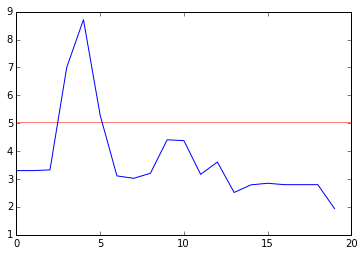

Name of Peptide SERCA3
Base Energy 6.2704518053
Base Sequence ['V', 'W', 'P', 'S', 'D']

 Cycle number : 1

Lowest Energy 1.0449163645 Sequence ['H', 'E', 'M', 'T', 'L']



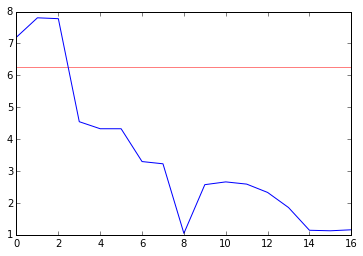

Name of Peptide TPC1
Base Energy 8.92322025265
Base Sequence ['S', 'Q', 'T', 'V', 'T']

 Cycle number : 1

Lowest Energy 2.09083247676 Sequence ['D', 'L', 'V', 'M', 'K']



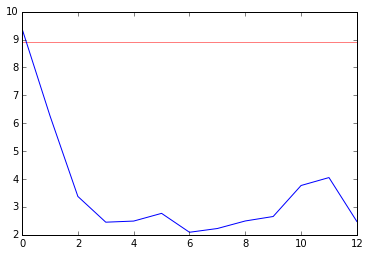

Name of Peptide Claudin2
Base Energy 11.3170000173
Base Sequence ['L', 'T', 'G', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.65713062569 Sequence ['D', 'V', 'C', 'E', 'Q']



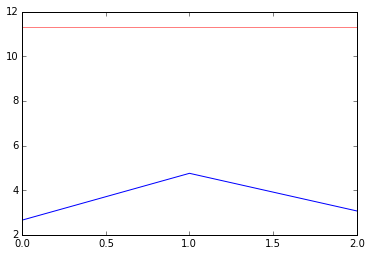

Name of Peptide Claudin3
Base Energy 7.17366012465
Base Sequence ['R', 'K', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 7.56267424922 Sequence ['H', 'M', 'M', 'N', 'I']



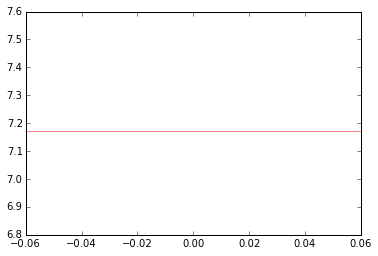

Name of Peptide Claudin4
Base Energy 9.66498096644
Base Sequence ['A', 'S', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 4.3770381185 Sequence ['I', 'L', 'H', 'M', 'L']



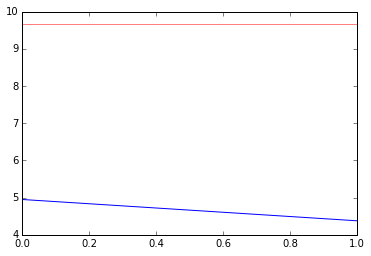

Name of Peptide Claudin5
Base Energy 69.1904204791
Base Sequence ['K', 'K', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 7.00561632218 Sequence ['V', 'I', 'D', 'T', 'M']



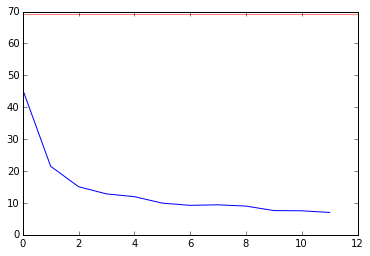

Name of Peptide Claudin6
Base Energy 52.2853897426
Base Sequence ['T', 'K', 'N', 'Y', 'V']

 Cycle number : 1

Lowest Energy 2.67411487229 Sequence ['T', 'N', 'Y', 'R', 'H']



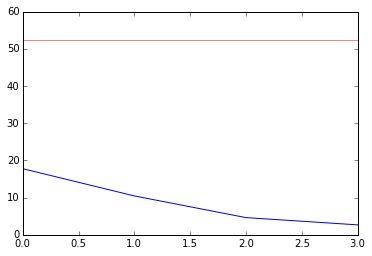

Name of Peptide Claudin7
Base Energy 14.8914186154
Base Sequence ['S', 'K', 'E', 'Y', 'V']

 Cycle number : 1

Lowest Energy 4.6079688587 Sequence ['M', 'I', 'R', 'Y', 'A']



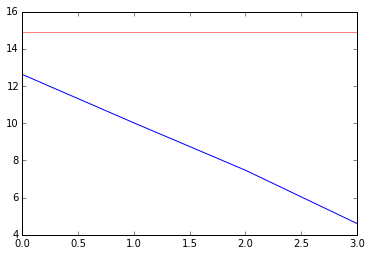

Name of Peptide Claudin8
Base Energy 7.60195464094
Base Sequence ['K', 'S', 'Q', 'Y', 'V']

 Cycle number : 1

Lowest Energy 7.76373374217 Sequence ['H', 'P', 'E', 'W', 'A']



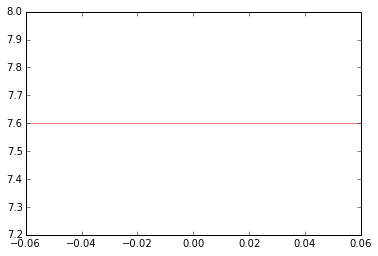

Name of Peptide Claudin9
Base Energy 13.0920258928
Base Sequence ['K', 'R', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 1.9681887596 Sequence ['I', 'C', 'D', 'K', 'Q']



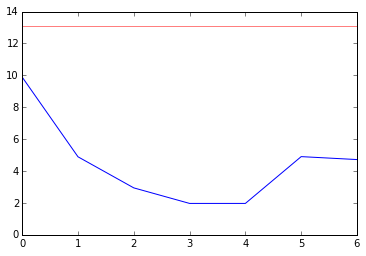

Name of Peptide Claudin10
Base Energy 20.0984636691
Base Sequence ['K', 'N', 'A', 'Y', 'V']

 Cycle number : 1

Lowest Energy 6.73023550141 Sequence ['W', 'R', 'M', 'C', 'L']



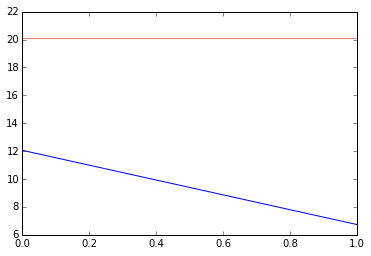

Name of Peptide Claudin11
Base Energy 19.3286831196
Base Sequence ['K', 'S', 'A', 'H', 'V']

 Cycle number : 1

Lowest Energy 9.65836028883 Sequence ['P', 'Y', 'K', 'K', 'L']



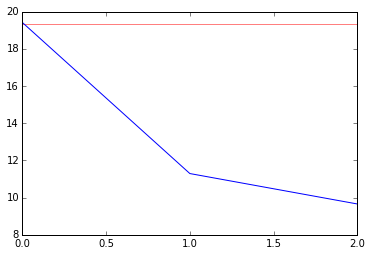

Name of Peptide Claudin13
Base Energy 5.36008828371
Base Sequence ['D', 'T', 'L', 'D', 'V']

 Cycle number : 1

Lowest Energy 1.55603729866 Sequence ['M', 'N', 'Y', 'H', 'H']



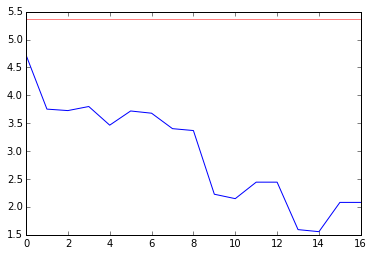

Name of Peptide Claudin14
Base Energy 1.69869817987
Base Sequence ['L', 'N', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 3.35490721381 Sequence ['V', 'Q', 'R', 'I', 'R']



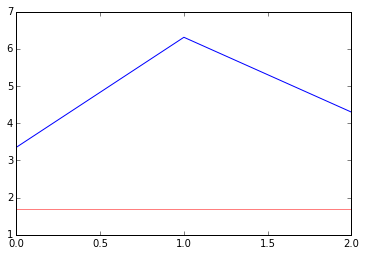

Name of Peptide Claudin15
Base Energy 20.0984636691
Base Sequence ['K', 'N', 'A', 'Y', 'V']

 Cycle number : 1

Lowest Energy 4.61954330206 Sequence ['L', 'A', 'C', 'K', 'T']



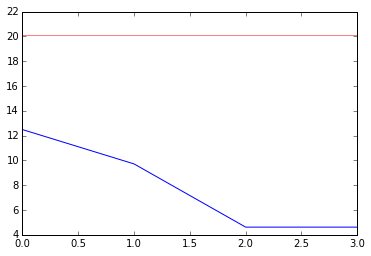

Name of Peptide Claudin16
Base Energy 33.1307825301
Base Sequence ['V', 'D', 'T', 'R', 'V']

 Cycle number : 1

Lowest Energy 13.2699284432 Sequence ['D', 'P', 'A', 'L', 'L']



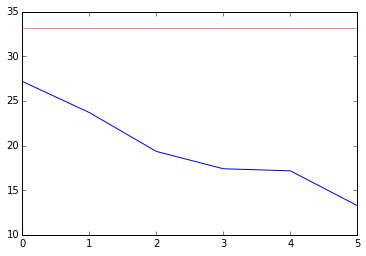

Name of Peptide Claudin18
Base Energy 29.3482977089
Base Sequence ['K', 'Y', 'D', 'Y', 'V']

 Cycle number : 1

Lowest Energy 4.83501586306 Sequence ['A', 'L', 'L', 'A', 'G']



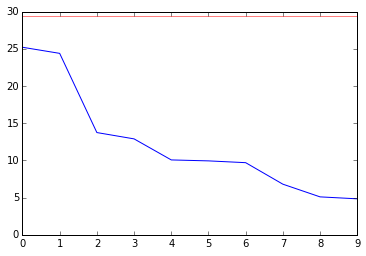

Name of Peptide Claudin19
Base Energy 4.89381545106
Base Sequence ['A', 'R', 'E', 'Y', 'V']

 Cycle number : 1

Lowest Energy 3.04202260489 Sequence ['E', 'A', 'E', 'K', 'S']



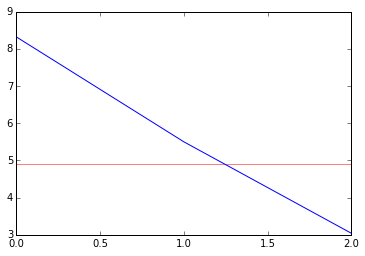

Name of Peptide Claudin22
Base Energy 2.30310124649
Base Sequence ['A', 'N', 'P', 'E', 'I']

 Cycle number : 1

Lowest Energy 1.62970333877 Sequence ['N', 'G', 'G', 'V', 'E']



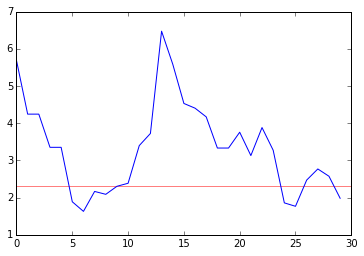

Name of Peptide Claudin23
Base Energy 2.47978086236
Base Sequence ['C', 'D', 'S', 'D', 'L']

 Cycle number : 1

Lowest Energy 1.83590278331 Sequence ['L', 'G', 'L', 'F', 'A']



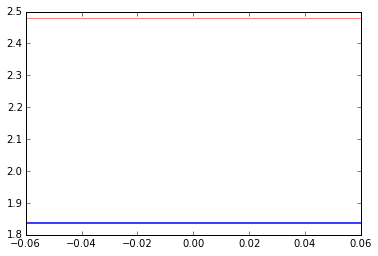

Name of Peptide EphrinB3
Base Energy 1.6607904112
Base Sequence ['I', 'Y', 'Y', 'K', 'V']

 Cycle number : 1

Lowest Energy 1.98469272175 Sequence ['E', 'A', 'L', 'W', 'T']



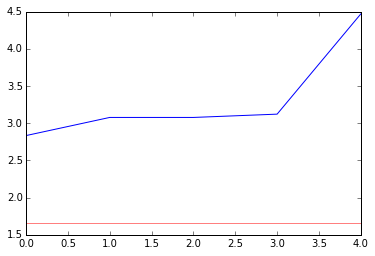

Name of Peptide GluR2_2
Base Energy 8.59842602681
Base Sequence ['V', 'T', 'D', 'L', 'S']

 Cycle number : 1

Lowest Energy 1.51341594158 Sequence ['M', 'P', 'A', 'N', 'Y']



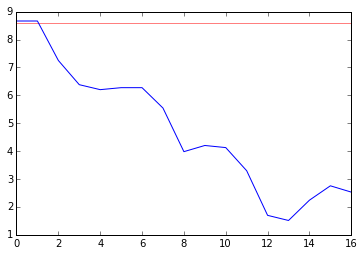

Name of Peptide GluR2_3
Base Energy 6.26261640287
Base Sequence ['L', 'G', 'W', 'V', 'E']

 Cycle number : 1

Lowest Energy 2.54795628773 Sequence ['R', 'G', 'C', 'S', 'F']



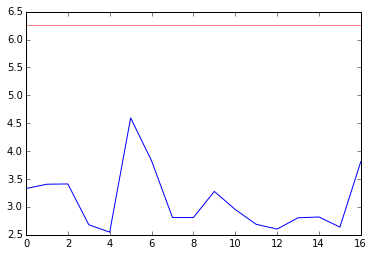

Name of Peptide GluR3
Base Energy 20.4335030733
Base Sequence ['E', 'S', 'V', 'K', 'I']

 Cycle number : 1

Lowest Energy 2.37663762014 Sequence ['N', 'D', 'T', 'Q', 'A']



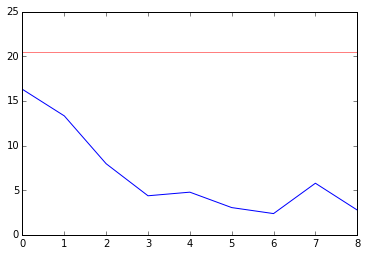

Name of Peptide GluR5_2
Base Energy 31.6788017701
Base Sequence ['S', 'V', 'H', 'T', 'V']

 Cycle number : 1

Lowest Energy 1.81932252894 Sequence ['W', 'R', 'D', 'E', 'A']



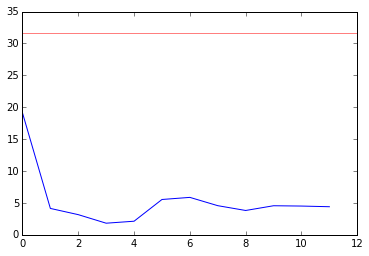

Name of Peptide GluRdelta1
Base Energy 30.759492334
Base Sequence ['H', 'G', 'T', 'S', 'I']

 Cycle number : 1

Lowest Energy 16.5765182615 Sequence ['D', 'Y', 'Y', 'W', 'V']



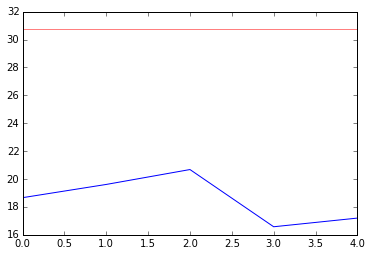

Name of Peptide GluRdelta2
Base Energy 23.7971790916
Base Sequence ['R', 'G', 'T', 'S', 'I']

 Cycle number : 1

Lowest Energy 4.45363354609 Sequence ['M', 'N', 'P', 'G', 'P']



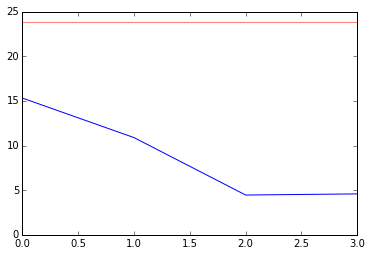

Name of Peptide KA-2
Base Energy 12.6744224267
Base Sequence ['L', 'T', 'E', 'H', 'E']

 Cycle number : 1

Lowest Energy 2.17433086999 Sequence ['L', 'M', 'Q', 'A', 'Y']



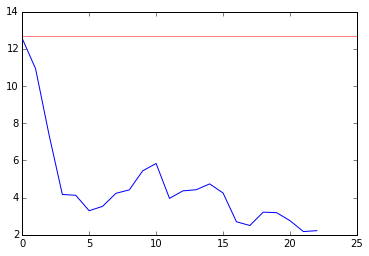

Name of Peptide mGluR1
Base Energy 15.8797011742
Base Sequence ['S', 'S', 'S', 'T', 'L']

 Cycle number : 1

Lowest Energy 3.91953881181 Sequence ['F', 'F', 'K', 'I', 'A']



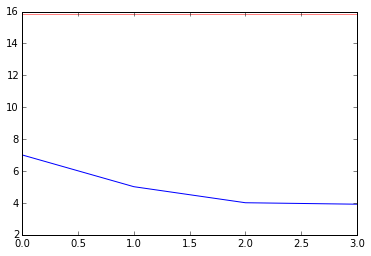

Name of Peptide NMDAR1
Base Energy 1.99695789843
Base Sequence ['R', 'H', 'R', 'E', 'S']

 Cycle number : 1

Lowest Energy 2.30803012219 Sequence ['I', 'E', 'S', 'G', 'L']



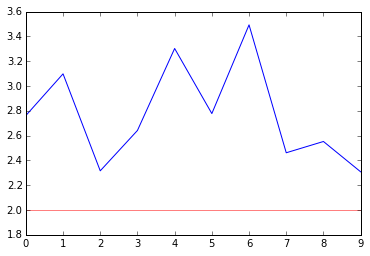

Name of Peptide NMDAR2C
Base Energy 29.899606913
Base Sequence ['L', 'E', 'S', 'E', 'V']

 Cycle number : 1

Lowest Energy 11.8827130609 Sequence ['L', 'V', 'W', 'D', 'S']



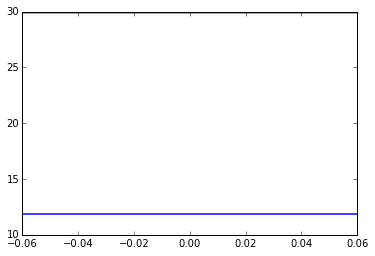

Name of Peptide NMDAR2D
Base Energy 22.839446913
Base Sequence ['L', 'E', 'S', 'E', 'V']

 Cycle number : 1

Lowest Energy 12.2174649763 Sequence ['Y', 'D', 'I', 'R', 'Y']



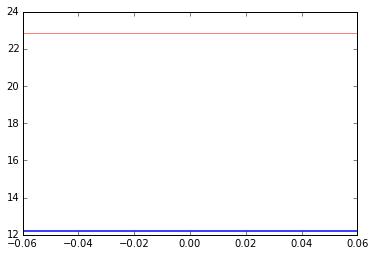

Name of Peptide NMDAR3B
Base Energy 3.36347448554
Base Sequence ['A', 'P', 'A', 'E', 'S']

 Cycle number : 1

Lowest Energy 2.22856716681 Sequence ['M', 'V', 'A', 'W', 'I']



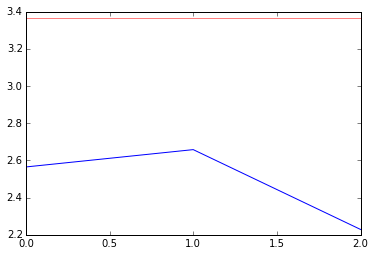

Name of Peptide Nuroligin1
Base Energy 12.2288089523
Base Sequence ['Y', 'K', 'R', 'C', 'E']

 Cycle number : 1

Lowest Energy 1.45034491218 Sequence ['W', 'S', 'C', 'W', 'I']



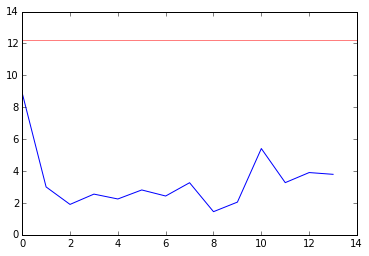

Name of Peptide Nuroligin2
Base Energy 17.9974531125
Base Sequence ['S', 'T', 'T', 'R', 'V']

 Cycle number : 1

Lowest Energy 3.01937030208 Sequence ['H', 'L', 'K', 'W', 'S']



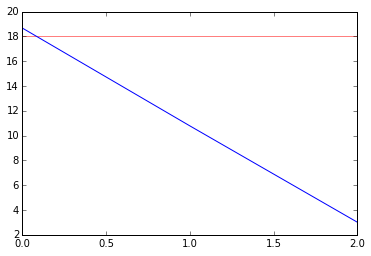

Name of Peptide Nuroligin3
Base Energy 5.32349049893
Base Sequence ['P', 'T', 'D', 'L', 'F']

 Cycle number : 1

Lowest Energy 1.88204987432 Sequence ['F', 'N', 'V', 'C', 'Q']



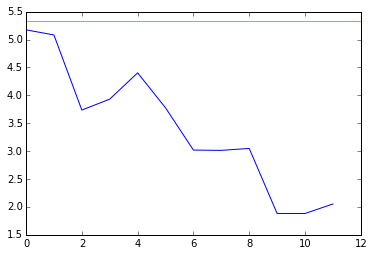

Name of Peptide Caspr4
Base Energy 30.6896720937
Base Sequence ['K', 'E', 'Y', 'F', 'F']

 Cycle number : 1

Lowest Energy 16.1306031991 Sequence ['W', 'D', 'W', 'A', 'Q']



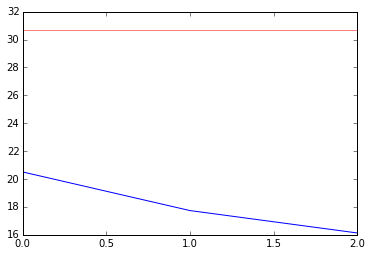

Name of Peptide Neurexin3
Base Energy 58.8228348124
Base Sequence ['K', 'E', 'Y', 'Y', 'V']

 Cycle number : 1

Lowest Energy 18.8190696078 Sequence ['A', 'A', 'E', 'K', 'H']



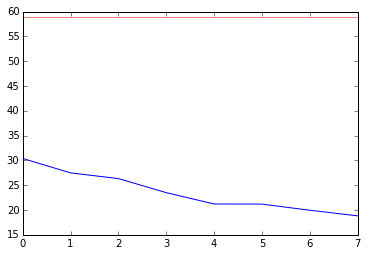

Name of Peptide Neurexin4
Base Energy 4.01358055511
Base Sequence ['E', 'S', 'R', 'S', 'E']

 Cycle number : 1

Lowest Energy 2.70093843967 Sequence ['L', 'R', 'R', 'Q', 'P']



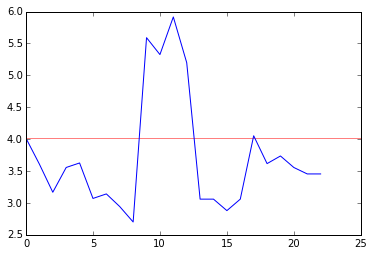

Name of Peptide CNGA2
Base Energy 2.40743083986
Base Sequence ['P', 'A', 'V', 'A', 'E']

 Cycle number : 1

Lowest Energy 1.72736413702 Sequence ['C', 'P', 'F', 'H', 'M']



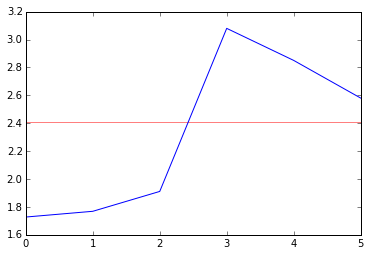

Name of Peptide CNGA3
Base Energy 4.35629541192
Base Sequence ['A', 'S', 'K', 'T', 'D']

 Cycle number : 1

Lowest Energy 1.47622509538 Sequence ['W', 'Q', 'T', 'C', 'F']



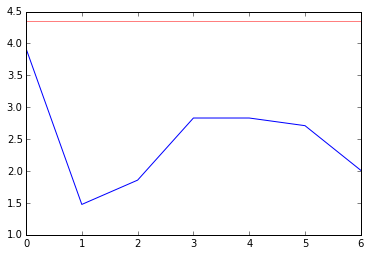

Name of Peptide KCNAB2
Base Energy 18.0435733761
Base Sequence ['K', 'D', 'Y', 'R', 'S']

 Cycle number : 1

Lowest Energy 2.131158832 Sequence ['W', 'C', 'G', 'L', 'G']



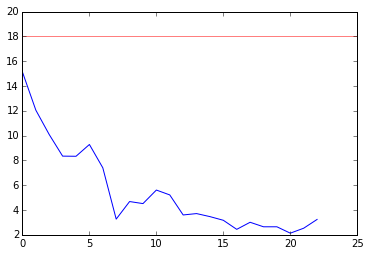

Name of Peptide KCNE1
Base Energy 9.2223302792
Base Sequence ['L', 'K', 'P', 'L', 'S']

 Cycle number : 1

Lowest Energy 1.46204685125 Sequence ['Y', 'A', 'L', 'D', 'T']



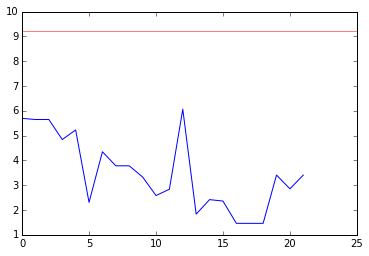

Name of Peptide KCNE4_1
Base Energy 15.9009957792
Base Sequence ['L', 'V', 'S', 'I', 'C']

 Cycle number : 1

Lowest Energy 14.6784345272 Sequence ['P', 'K', 'I', 'S', 'T']



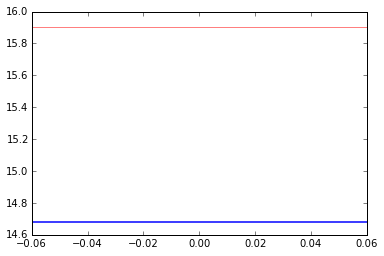

Name of Peptide KCNE4_2
Base Energy 2.06595170156
Base Sequence ['I', 'H', 'Q', 'N', 'S']

 Cycle number : 1

Lowest Energy 2.39700672506 Sequence ['V', 'T', 'N', 'L', 'F']



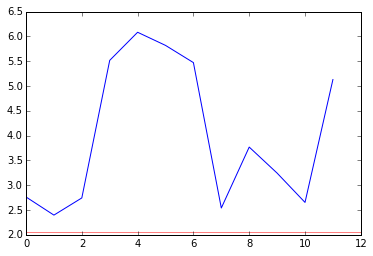

Name of Peptide KCNH1
Base Energy 6.18186639765
Base Sequence ['I', 'F', 'G', 'A', 'S']

 Cycle number : 1

Lowest Energy 1.68535646528 Sequence ['P', 'I', 'S', 'H', 'S']



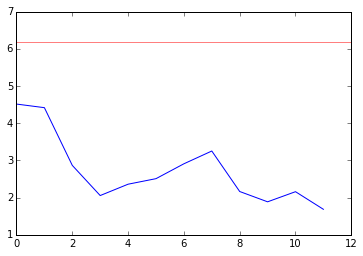

Name of Peptide KCNK3
Base Energy 49.5586585855
Base Sequence ['R', 'R', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 2.76427058219 Sequence ['K', 'F', 'W', 'E', 'S']



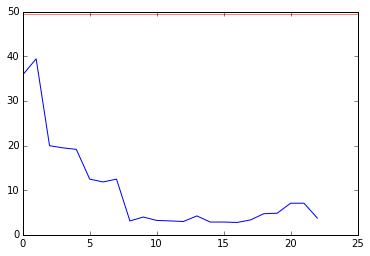

Name of Peptide KCNK4_1
Base Energy 11.3226351038
Base Sequence ['K', 'A', 'M', 'A', 'I']

 Cycle number : 1

Lowest Energy 1.51349135249 Sequence ['N', 'M', 'L', 'C', 'M']



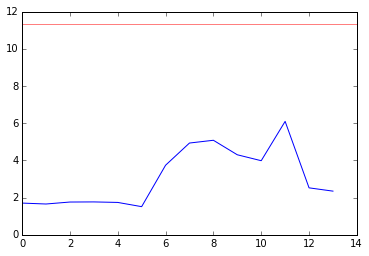

Name of Peptide KCNK4_2
Base Energy 7.31694597677
Base Sequence ['K', 'A', 'V', 'P', 'V']

 Cycle number : 1

Lowest Energy 1.73771749355 Sequence ['W', 'F', 'W', 'R', 'M']



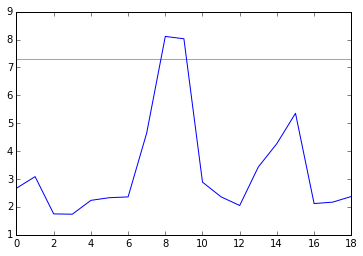

Name of Peptide KCNK5
Base Energy 3.13513099391
Base Sequence ['N', 'P', 'R', 'G', 'T']

 Cycle number : 1

Lowest Energy 2.90596125572 Sequence ['H', 'R', 'L', 'M', 'K']



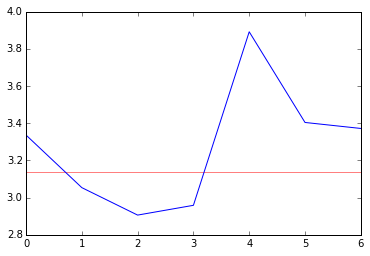

Name of Peptide KCNK6
Base Energy 2.84641615851
Base Sequence ['A', 'P', 'R', 'S', 'A']

 Cycle number : 1

Lowest Energy 4.23761795585 Sequence ['K', 'C', 'D', 'Y', 'C']



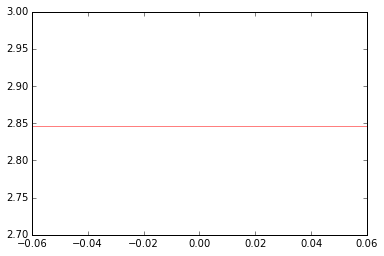

Name of Peptide KCNK7
Base Energy 8.87759422891
Base Sequence ['P', 'T', 'T', 'P', 'A']

 Cycle number : 1

Lowest Energy 1.26031483098 Sequence ['L', 'W', 'F', 'M', 'W']



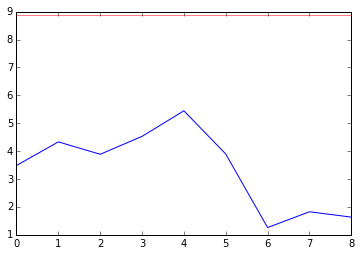

Name of Peptide KCNQ2
Base Energy 11.7892273577
Base Sequence ['V', 'T', 'S', 'Q', 'L']

 Cycle number : 1

Lowest Energy 1.97505925311 Sequence ['P', 'R', 'S', 'L', 'Q']



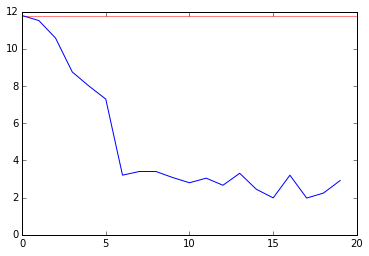

Name of Peptide KCNQ3
Base Energy 3.51115603645
Base Sequence ['S', 'N', 'K', 'P', 'T']

 Cycle number : 1

Lowest Energy 1.19637579281 Sequence ['P', 'V', 'W', 'M', 'H']



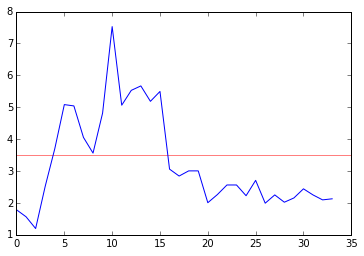

Name of Peptide Kir2.2
Base Energy 28.5088245181
Base Sequence ['R', 'E', 'S', 'E', 'I']

 Cycle number : 1

Lowest Energy 7.60395663155 Sequence ['L', 'H', 'K', 'K', 'A']



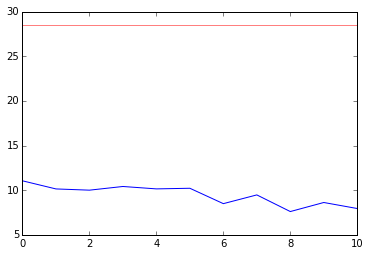

Name of Peptide Kir3.1
Base Energy 12.2859982745
Base Sequence ['S', 'D', 'R', 'F', 'T']

 Cycle number : 1

Lowest Energy 2.28884172353 Sequence ['L', 'C', 'T', 'G', 'N']



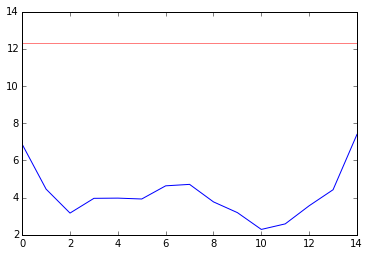

Name of Peptide Kir3.2_1
Base Energy 4.26660335563
Base Sequence ['A', 'T', 'G', 'Q', 'F']

 Cycle number : 1

Lowest Energy 3.21658796157 Sequence ['F', 'F', 'Y', 'D', 'F']



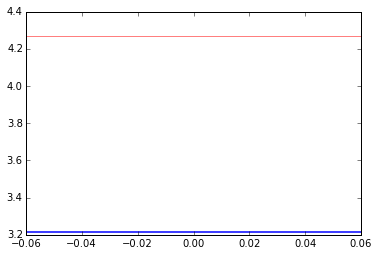

Name of Peptide Kir3.2_2
Base Energy 13.9810575588
Base Sequence ['N', 'E', 'S', 'K', 'V']

 Cycle number : 1

Lowest Energy 13.2522549918 Sequence ['R', 'H', 'Y', 'I', 'A']



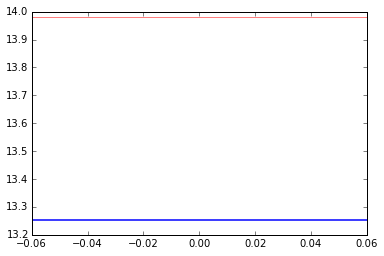

Name of Peptide Kir3.2_3
Base Energy 1.69536422253
Base Sequence ['T', 'E', 'R', 'N', 'G']

 Cycle number : 1

Lowest Energy 1.30975791597 Sequence ['C', 'Y', 'Y', 'C', 'V']



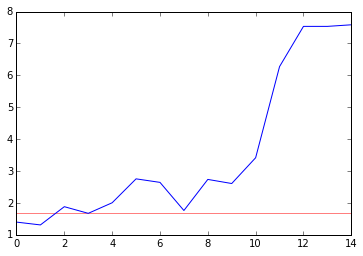

Name of Peptide Kir3.3
Base Energy 19.5663537291
Base Sequence ['S', 'E', 'S', 'K', 'V']

 Cycle number : 1

Lowest Energy 2.64120279699 Sequence ['I', 'W', 'C', 'P', 'E']



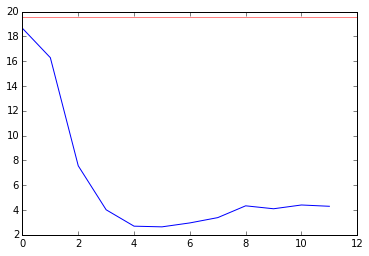

Name of Peptide Kir3.4
Base Energy 13.4005530879
Base Sequence ['T', 'R', 'G', 'S', 'M']

 Cycle number : 1

Lowest Energy 1.89867646257 Sequence ['Y', 'Y', 'K', 'P', 'S']



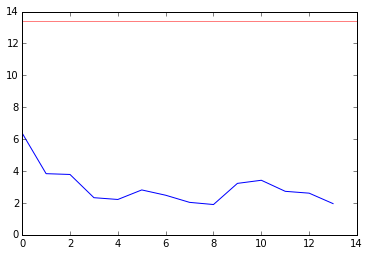

Name of Peptide Kir4.1
Base Energy 8.40031322706
Base Sequence ['R', 'I', 'S', 'N', 'V']

 Cycle number : 1

Lowest Energy 8.99777274619 Sequence ['L', 'K', 'M', 'W', 'G']



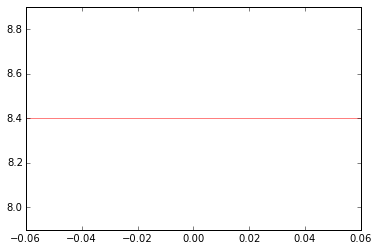

Name of Peptide Kir4.2
Base Energy 16.8040004786
Base Sequence ['Q', 'Q', 'S', 'N', 'V']

 Cycle number : 1

Lowest Energy 4.79371610486 Sequence ['T', 'S', 'F', 'L', 'G']



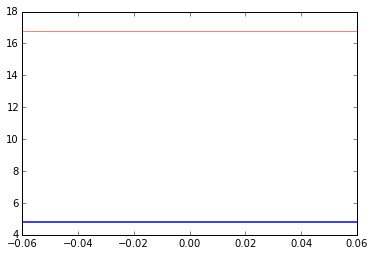

Name of Peptide Kir5.1
Base Energy 34.2847075124
Base Sequence ['M', 'E', 'S', 'Q', 'M']

 Cycle number : 1

Lowest Energy 1.53037607684 Sequence ['R', 'A', 'W', 'K', 'E']



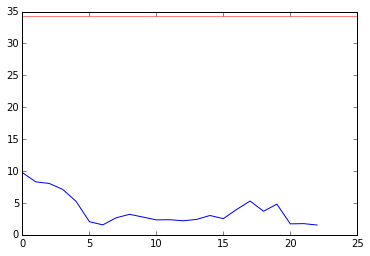

Name of Peptide Kir6.1
Base Energy 3.60183439172
Base Sequence ['C', 'P', 'S', 'E', 'S']

 Cycle number : 1

Lowest Energy 1.92103757868 Sequence ['G', 'F', 'R', 'A', 'Q']



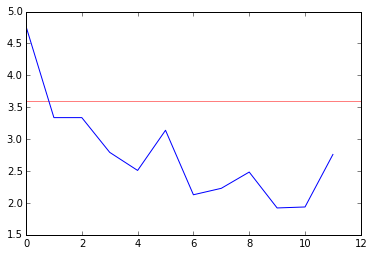

Name of Peptide Kir6.2
Base Energy 6.25762005234
Base Sequence ['P', 'D', 'S', 'L', 'S']

 Cycle number : 1

Lowest Energy 1.5845077087 Sequence ['G', 'C', 'M', 'K', 'I']



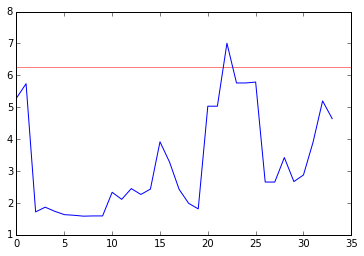

Name of Peptide Kv1.1
Base Energy 65.5208452336
Base Sequence ['L', 'L', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 14.651764925 Sequence ['T', 'Y', 'K', 'R', 'N']



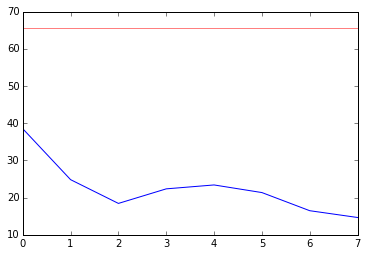

Name of Peptide Kv1.2
Base Energy 104.671429206
Base Sequence ['M', 'L', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 4.11151549476 Sequence ['C', 'N', 'H', 'V', 'D']



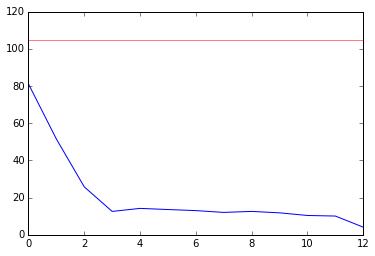

Name of Peptide Kv1.3
Base Energy 24.7435125126
Base Sequence ['I', 'F', 'T', 'D', 'V']

 Cycle number : 1

Lowest Energy 25.0670877335 Sequence ['Q', 'D', 'F', 'H', 'N']



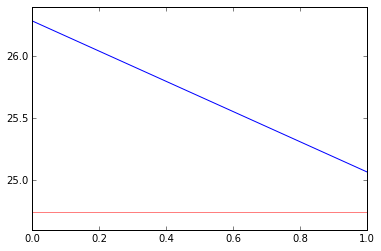

Name of Peptide Kv1.5
Base Energy 68.8594422475
Base Sequence ['R', 'E', 'T', 'D', 'L']

 Cycle number : 1

Lowest Energy 21.7057298561 Sequence ['G', 'C', 'R', 'H', 'L']



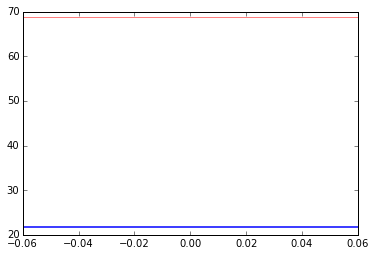

Name of Peptide Kv1.6
Base Energy 84.7184117939
Base Sequence ['M', 'L', 'T', 'E', 'V']

 Cycle number : 1

Lowest Energy 26.2538589755 Sequence ['L', 'N', 'G', 'S', 'C']



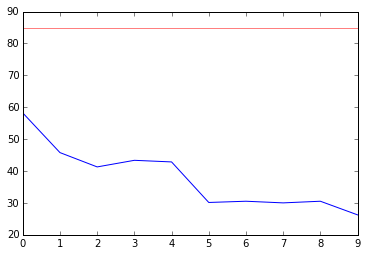

Name of Peptide Kv1.7
Base Energy 9.69282989865
Base Sequence ['M', 'V', 'T', 'E', 'V']

 Cycle number : 1

Lowest Energy 15.7789032829 Sequence ['G', 'Q', 'I', 'Y', 'N']



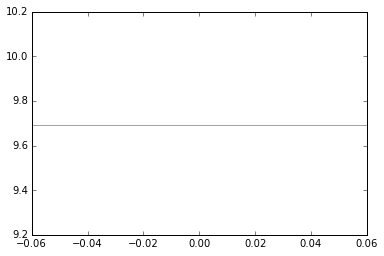

Name of Peptide Kv2.1
Base Energy 1.32396971665
Base Sequence ['R', 'D', 'Q', 'S', 'I']

 Cycle number : 1

Lowest Energy 2.01708720095 Sequence ['P', 'M', 'A', 'C', 'W']



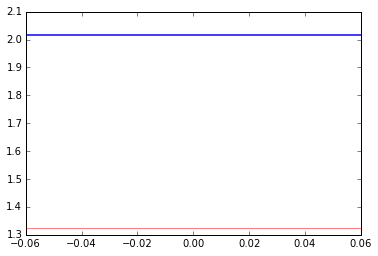

Name of Peptide Kv3.1
Base Energy 2.1503025057
Base Sequence ['R', 'G', 'M', 'S', 'I']

 Cycle number : 1

Lowest Energy 2.58994779036 Sequence ['C', 'F', 'N', 'T', 'N']



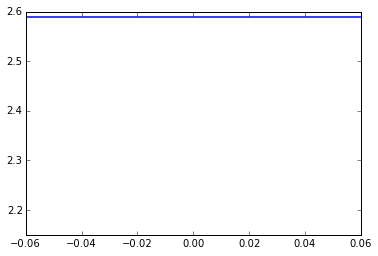

Name of Peptide Kv3.3_1
Base Energy 9.87045522656
Base Sequence ['L', 'P', 'S', 'I', 'L']

 Cycle number : 1

Lowest Energy 1.18982763088 Sequence ['H', 'E', 'C', 'I', 'L']



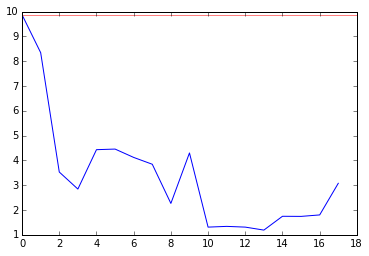

Name of Peptide Kv3.3_2
Base Energy 31.0460163321
Base Sequence ['S', 'E', 'T', 'Q', 'V']

 Cycle number : 1

Lowest Energy 37.1861999029 Sequence ['Y', 'V', 'V', 'P', 'Q']



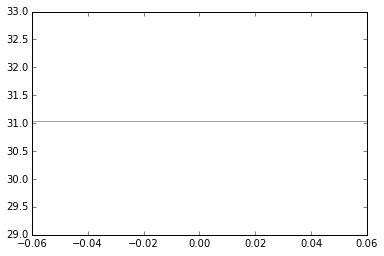

Name of Peptide Kv4.1
Base Energy 13.5896281787
Base Sequence ['K', 'I', 'S', 'S', 'L']

 Cycle number : 1

Lowest Energy 6.8179011521 Sequence ['Y', 'D', 'D', 'M', 'A']



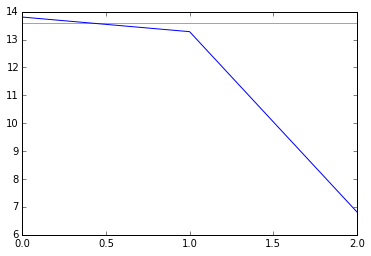

Name of Peptide Kv4.2
Base Energy 33.0314598618
Base Sequence ['R', 'V', 'S', 'A', 'L']

 Cycle number : 1

Lowest Energy 20.4634002771 Sequence ['N', 'Y', 'C', 'M', 'I']



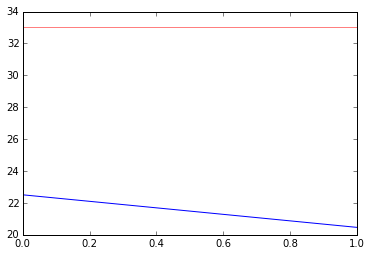

Name of Peptide Kv6.3
Base Energy 4.45383189455
Base Sequence ['A', 'E', 'F', 'L', 'N']

 Cycle number : 1

Lowest Energy 1.70760134232 Sequence ['I', 'H', 'S', 'I', 'K']



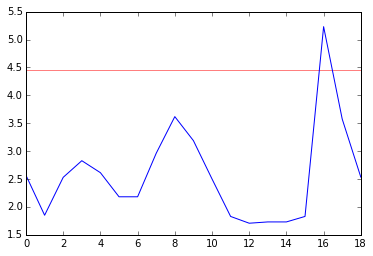

Name of Peptide Kv8.1
Base Energy 27.5027839935
Base Sequence ['D', 'D', 'F', 'W', 'F']

 Cycle number : 1

Lowest Energy 2.58479174867 Sequence ['L', 'Y', 'M', 'S', 'D']



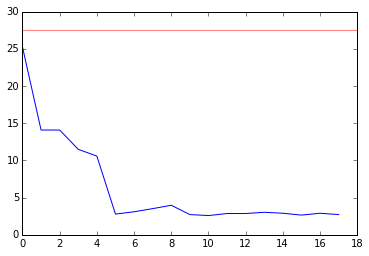

Name of Peptide Kv9.1
Base Energy 3.97213592363
Base Sequence ['K', 'S', 'H', 'S', 'Y']

 Cycle number : 1

Lowest Energy 1.05836797662 Sequence ['D', 'A', 'F', 'R', 'M']



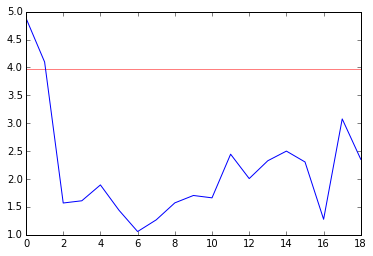

Name of Peptide KVLQT1
Base Energy 1.67987927109
Base Sequence ['P', 'D', 'E', 'G', 'S']

 Cycle number : 1

Lowest Energy 1.58151030722 Sequence ['S', 'R', 'Q', 'C', 'S']



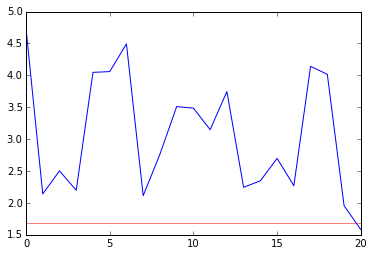

Name of Peptide AXL
Base Energy 4.69386807794
Base Sequence ['Q', 'E', 'D', 'G', 'A']

 Cycle number : 1

Lowest Energy 1.34103264447 Sequence ['R', 'Y', 'M', 'N', 'H']



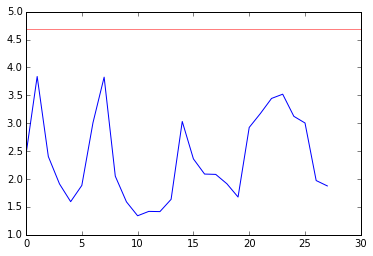

Name of Peptide CSF-1R
Base Energy 27.9868373633
Base Sequence ['N', 'Y', 'Q', 'F', 'C']

 Cycle number : 1

Lowest Energy 1.63865165744 Sequence ['M', 'K', 'D', 'L', 'N']



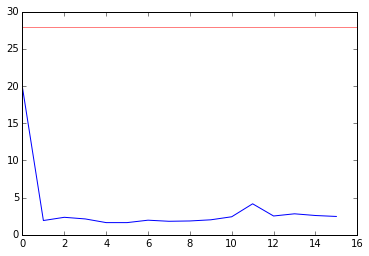

Name of Peptide DDR1
Base Energy 13.1696722075
Base Sequence ['A', 'L', 'N', 'T', 'V']

 Cycle number : 1

Lowest Energy 1.06071749511 Sequence ['C', 'D', 'V', 'I', 'S']



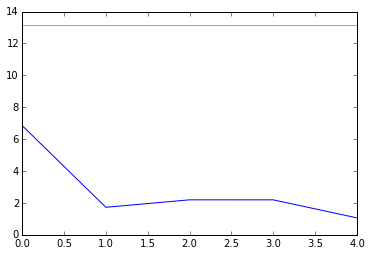

Name of Peptide DDR2
Base Energy 12.924611116
Base Sequence ['Q', 'Q', 'G', 'A', 'E']

 Cycle number : 1

Lowest Energy 2.26031297256 Sequence ['V', 'S', 'A', 'V', 'V']



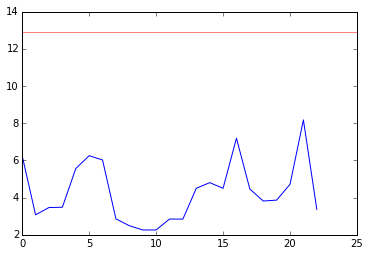

Name of Peptide EGFR
Base Energy 27.164750603
Base Sequence ['E', 'F', 'I', 'G', 'A']

 Cycle number : 1

Lowest Energy 7.00022042836 Sequence ['T', 'C', 'L', 'R', 'Q']



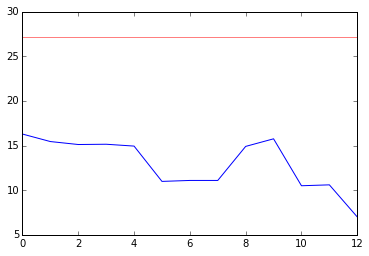

Name of Peptide EphA1
Base Energy 13.7057774191
Base Sequence ['Q', 'G', 'F', 'K', 'D']

 Cycle number : 1

Lowest Energy 1.53042530642 Sequence ['S', 'C', 'F', 'W', 'K']



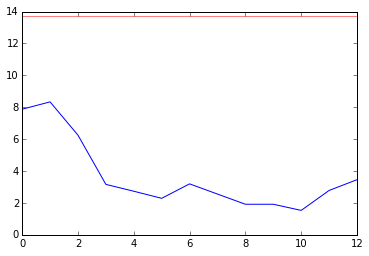

Name of Peptide EphA2
Base Energy 4.35489389959
Base Sequence ['V', 'G', 'I', 'P', 'I']

 Cycle number : 1

Lowest Energy 2.72134142171 Sequence ['T', 'I', 'M', 'Q', 'I']



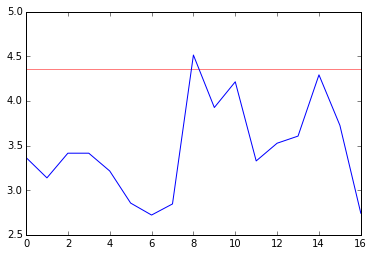

Name of Peptide EphA3
Base Energy 4.9768484043
Base Sequence ['G', 'P', 'V', 'P', 'V']

 Cycle number : 1

Lowest Energy 2.39397812319 Sequence ['W', 'V', 'F', 'T', 'I']



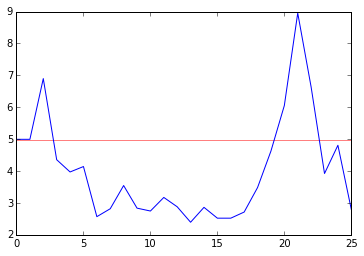

Name of Peptide EphA4
Base Energy 6.93802845937
Base Sequence ['R', 'M', 'V', 'P', 'V']

 Cycle number : 1

Lowest Energy 2.34101045486 Sequence ['T', 'M', 'W', 'L', 'F']



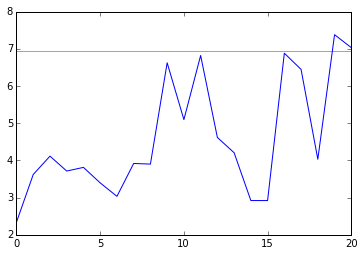

Name of Peptide EphA5
Base Energy 5.94518663308
Base Sequence ['G', 'M', 'V', 'P', 'V']

 Cycle number : 1

Lowest Energy 2.07140660352 Sequence ['D', 'D', 'D', 'R', 'A']



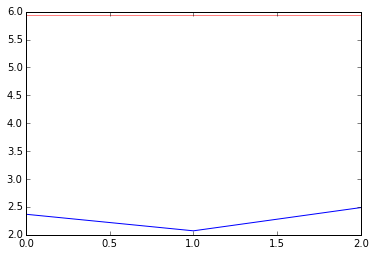

Name of Peptide EphA6
Base Energy 12.9677503712
Base Sequence ['K', 'G', 'F', 'H', 'V']

 Cycle number : 1

Lowest Energy 1.47704188222 Sequence ['D', 'E', 'W', 'A', 'H']



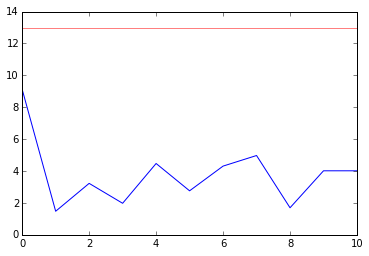

Name of Peptide EphA7_2
Base Energy 42.397382259
Base Sequence ['H', 'L', 'S', 'V', 'L']

 Cycle number : 1

Lowest Energy 1.8418569836 Sequence ['H', 'F', 'A', 'D', 'P']



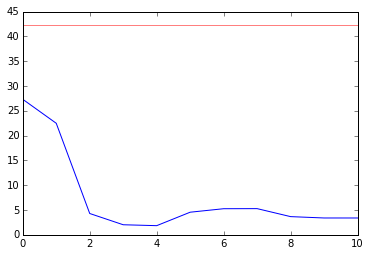

Name of Peptide EphB3
Base Energy 9.15036866847
Base Sequence ['L', 'P', 'V', 'Q', 'V']

 Cycle number : 1

Lowest Energy 8.37028116091 Sequence ['Q', 'M', 'S', 'Q', 'T']



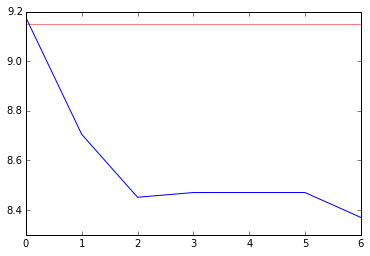

Name of Peptide EphB4
Base Energy 4.43990331423
Base Sequence ['P', 'A', 'Q', 'Q', 'F']

 Cycle number : 1

Lowest Energy 1.5083323372 Sequence ['Y', 'W', 'F', 'N', 'E']



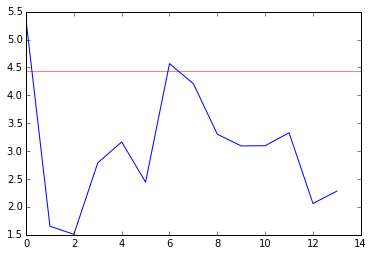

Name of Peptide EphB6_1
Base Energy 4.87191758259
Base Sequence ['G', 'S', 'V', 'E', 'V']

 Cycle number : 1

Lowest Energy 3.03825370044 Sequence ['C', 'E', 'K', 'K', 'P']



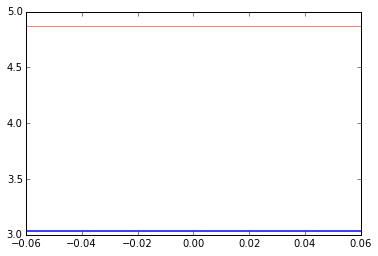

Name of Peptide EphB6_2
Base Energy 7.14839239305
Base Sequence ['R', 'P', 'E', 'V', 'C']

 Cycle number : 1

Lowest Energy 1.75437621368 Sequence ['N', 'G', 'N', 'D', 'D']



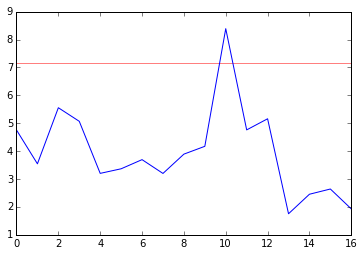

Name of Peptide EphB6_3
Base Energy 9.11135247955
Base Sequence ['S', 'S', 'Q', 'L', 'S']

 Cycle number : 1

Lowest Energy 1.8693793784 Sequence ['M', 'N', 'G', 'M', 'P']



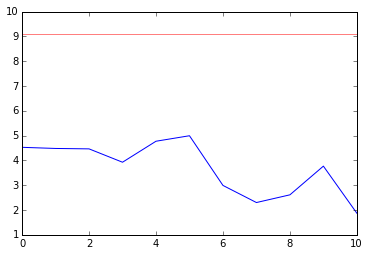

Name of Peptide ErbB2
Base Energy 3.37392946004
Base Sequence ['L', 'D', 'V', 'P', 'V']

 Cycle number : 1

Lowest Energy 2.40846469612 Sequence ['I', 'V', 'Q', 'Q', 'M']



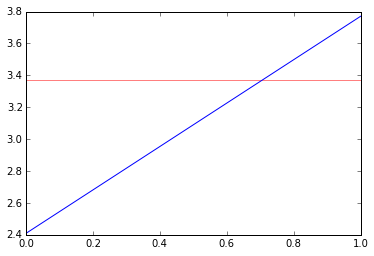

Name of Peptide FGFR2
Base Energy 14.8043063507
Base Sequence ['G', 'S', 'V', 'K', 'T']

 Cycle number : 1

Lowest Energy 1.53748756214 Sequence ['V', 'Y', 'W', 'E', 'V']



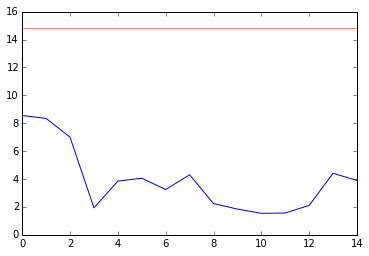

Name of Peptide FGFR3
Base Energy 7.55171969977
Base Sequence ['G', 'G', 'P', 'R', 'T']

 Cycle number : 1

Lowest Energy 1.2565286512 Sequence ['T', 'M', 'K', 'R', 'G']



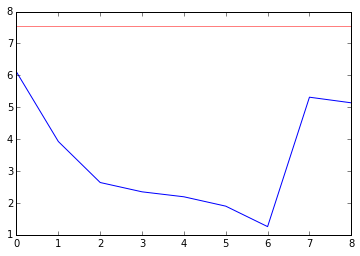

Name of Peptide FGFR4
Base Energy 6.66798799824
Base Sequence ['D', 'S', 'Q', 'T', 'T']

 Cycle number : 1

Lowest Energy 1.72120013374 Sequence ['I', 'C', 'F', 'I', 'N']



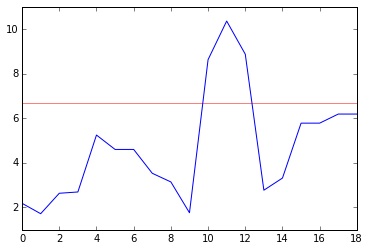

Name of Peptide IRR
Base Energy 2.29432742564
Base Sequence ['G', 'G', 'P', 'G', 'H']

 Cycle number : 1

Lowest Energy 1.49092830921 Sequence ['I', 'T', 'W', 'S', 'C']



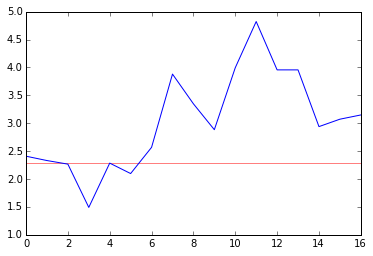

Name of Peptide PDGFRa_1
Base Energy 19.0699112588
Base Sequence ['E', 'D', 'S', 'F', 'L']

 Cycle number : 1

Lowest Energy 1.80582796586 Sequence ['F', 'I', 'H', 'K', 'E']



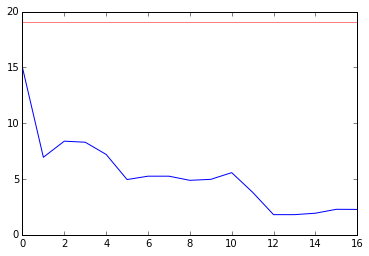

Name of Peptide PDGFRa_2
Base Energy 35.5844940228
Base Sequence ['D', 'L', 'S', 'V', 'V']

 Cycle number : 1

Lowest Energy 2.34224657382 Sequence ['R', 'N', 'V', 'M', 'R']



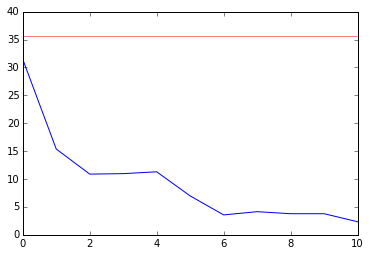

Name of Peptide PTK7
Base Energy 2.51343384822
Base Sequence ['A', 'D', 'S', 'K', 'Q']

 Cycle number : 1

Lowest Energy 1.58614140106 Sequence ['T', 'K', 'E', 'S', 'G']



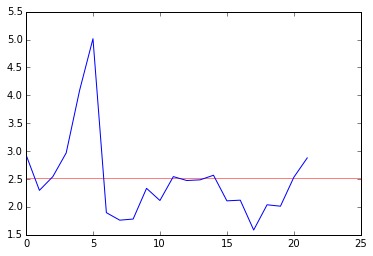

Name of Peptide RET
Base Energy 8.16719510563
Base Sequence ['D', 'T', 'F', 'D', 'S']

 Cycle number : 1

Lowest Energy 1.99155836101 Sequence ['K', 'H', 'E', 'C', 'F']



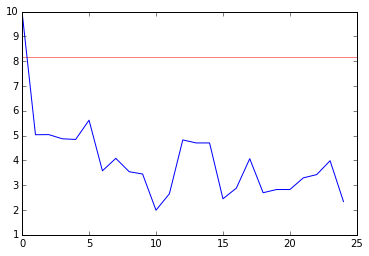

Name of Peptide ROR1
Base Energy 18.9445423206
Base Sequence ['I', 'S', 'A', 'E', 'V']

 Cycle number : 1

Lowest Energy 4.57043628311 Sequence ['N', 'D', 'V', 'D', 'D']



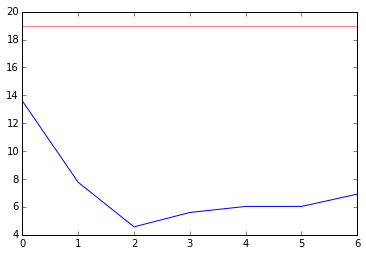

Name of Peptide ROR2
Base Energy 4.80516020003
Base Sequence ['V', 'Q', 'L', 'E', 'A']

 Cycle number : 1

Lowest Energy 1.54559652725 Sequence ['I', 'N', 'P', 'P', 'W']



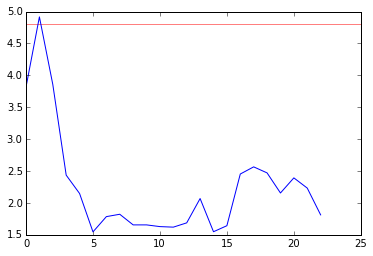

Name of Peptide Ros-1
Base Energy 2.15532631391
Base Sequence ['G', 'D', 'V', 'S', 'E']

 Cycle number : 1

Lowest Energy 1.77461613486 Sequence ['I', 'W', 'C', 'P', 'W']



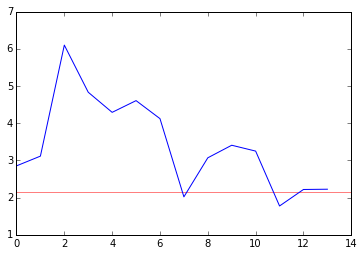

Name of Peptide RYK
Base Energy 32.5043649678
Base Sequence ['L', 'G', 'A', 'Y', 'V']

 Cycle number : 1

Lowest Energy 21.9458461752 Sequence ['A', 'P', 'M', 'E', 'M']



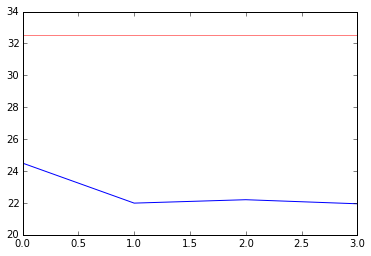

Name of Peptide TIE1
Base Energy 5.76766266737
Base Sequence ['T', 'A', 'E', 'E', 'A']

 Cycle number : 1

Lowest Energy 1.60773030725 Sequence ['W', 'F', 'K', 'F', 'I']



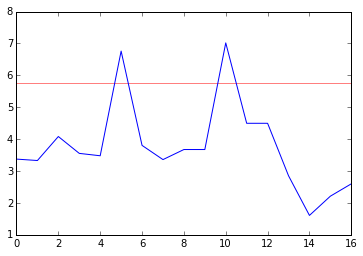

Name of Peptide TIE2
Base Energy 1.69020681995
Base Sequence ['A', 'E', 'E', 'A', 'A']

 Cycle number : 1

Lowest Energy 2.22419836699 Sequence ['T', 'G', 'Y', 'V', 'L']



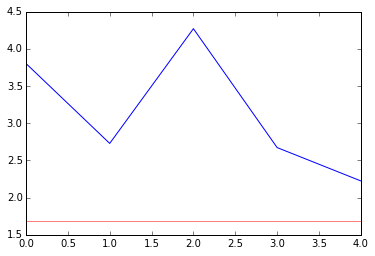

Name of Peptide TrkA
Base Energy 5.16138709518
Base Sequence ['L', 'D', 'V', 'L', 'G']

 Cycle number : 1

Lowest Energy 1.92462043742 Sequence ['L', 'T', 'Y', 'H', 'Y']



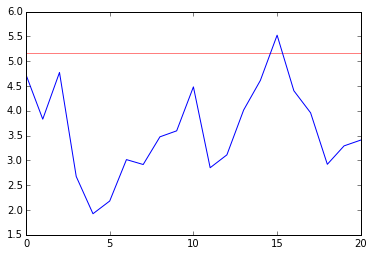

Name of Peptide TYRO3
Base Energy 2.26349868579
Base Sequence ['P', 'H', 'S', 'S', 'C']

 Cycle number : 1

Lowest Energy 1.9114289228 Sequence ['A', 'D', 'V', 'M', 'F']



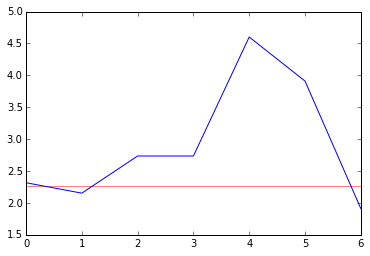

Name of Peptide VEGFR2
Base Energy 7.31991604772
Base Sequence ['R', 'S', 'P', 'P', 'V']

 Cycle number : 1

Lowest Energy 2.31075136459 Sequence ['Y', 'K', 'S', 'W', 'C']



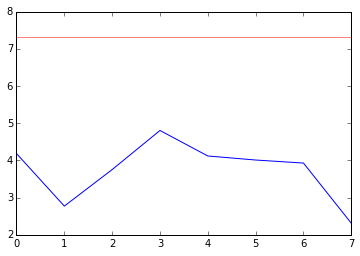

Name of Peptide VEGFR3
Base Energy 2.12671995926
Base Sequence ['A', 'D', 'S', 'S', 'Y']

 Cycle number : 1

Lowest Energy 1.20486769923 Sequence ['F', 'N', 'C', 'C', 'S']



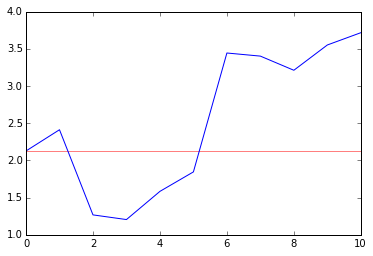

Name of Peptide Sema3a
Base Energy 1.76355662237
Base Sequence ['A', 'P', 'R', 'S', 'V']

 Cycle number : 1

Lowest Energy 1.32665374936 Sequence ['D', 'W', 'D', 'D', 'P']



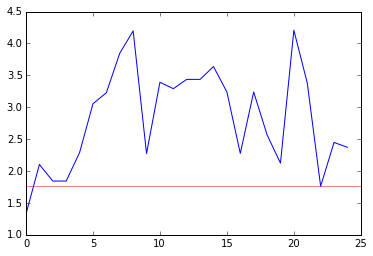

Name of Peptide Sema3b
Base Energy 24.4329755693
Base Sequence ['S', 'A', 'A', 'H', 'W']

 Cycle number : 1

Lowest Energy 1.731642146 Sequence ['C', 'T', 'N', 'T', 'G']



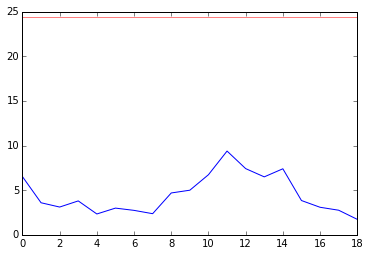

Name of Peptide Sema3f
Base Energy 1.87853901145
Base Sequence ['H', 'P', 'P', 'D', 'T']

 Cycle number : 1

Lowest Energy 2.11366609237 Sequence ['F', 'N', 'G', 'M', 'G']



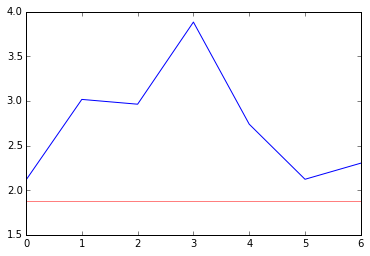

Name of Peptide Sema4a
Base Energy 2.74675035872
Base Sequence ['G', 'A', 'E', 'V', 'A']

 Cycle number : 1

Lowest Energy 1.4688463636 Sequence ['K', 'I', 'P', 'L', 'G']



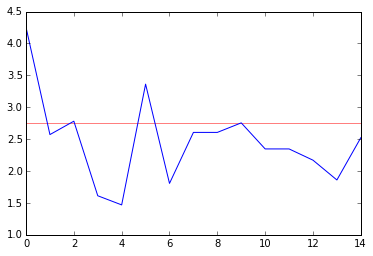

Name of Peptide Sema4b
Base Energy 6.92508036435
Base Sequence ['R', 'D', 'S', 'V', 'V']

 Cycle number : 1

Lowest Energy 22.6469729339 Sequence ['P', 'H', 'E', 'M', 'F']



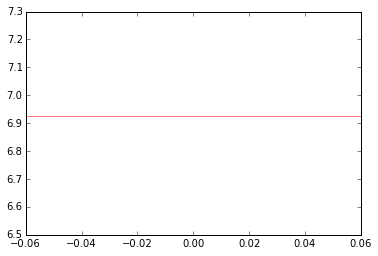

Name of Peptide Sema4c
Base Energy 7.01506486644
Base Sequence ['E', 'E', 'S', 'S', 'V']

 Cycle number : 1

Lowest Energy 6.36685565537 Sequence ['D', 'Q', 'W', 'E', 'I']



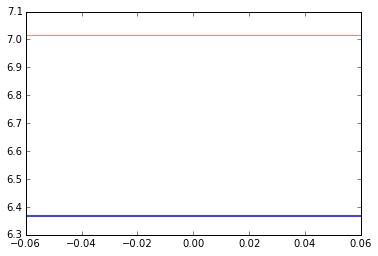

Name of Peptide Sema4f
Base Energy 53.9419732546
Base Sequence ['D', 'E', 'T', 'S', 'I']

 Cycle number : 1

Lowest Energy 71.7144034243 Sequence ['L', 'C', 'G', 'C', 'L']



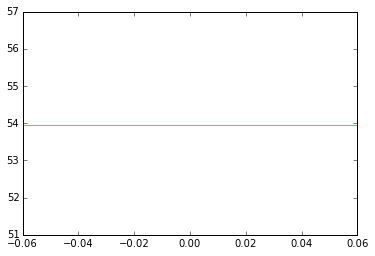

Name of Peptide Sema5a
Base Energy 5.62150826743
Base Sequence ['N', 'Y', 'D', 'E', 'Y']

 Cycle number : 1

Lowest Energy 1.49859277403 Sequence ['C', 'G', 'L', 'A', 'E']



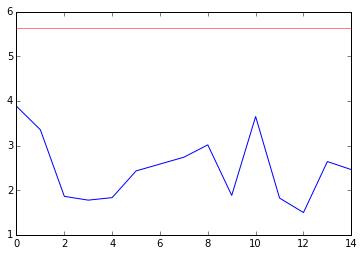

Name of Peptide Sema6a
Base Energy 1.89189243365
Base Sequence ['N', 'D', 'A', 'C', 'T']

 Cycle number : 1

Lowest Energy 1.61478010705 Sequence ['P', 'A', 'Q', 'N', 'T']



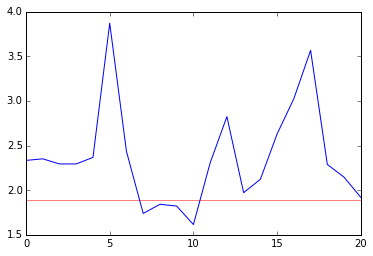

Name of Peptide Sema6b
Base Energy 2.94159456006
Base Sequence ['A', 'P', 'P', 'V', 'P']

 Cycle number : 1

Lowest Energy 1.34884953906 Sequence ['W', 'C', 'E', 'A', 'Q']



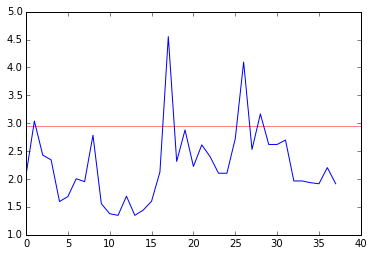

Name of Peptide Sema6c
Base Energy 5.67437897601
Base Sequence ['G', 'H', 'F', 'N', 'F']

 Cycle number : 1

Lowest Energy 11.7061021588 Sequence ['K', 'R', 'F', 'W', 'C']



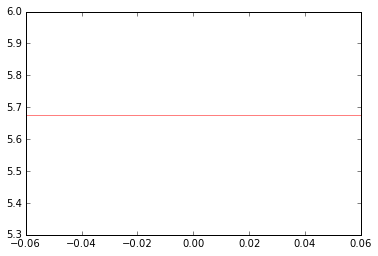

Name of Peptide Nav1.6
Base Energy 3.23100381901
Base Sequence ['R', 'E', 'S', 'K', 'C']

 Cycle number : 1

Lowest Energy 1.84938568892 Sequence ['Y', 'L', 'S', 'W', 'V']



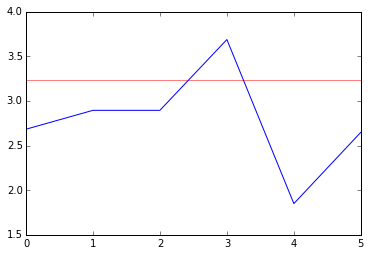

Name of Peptide Nav1.9b
Base Energy 14.835114099
Base Sequence ['K', 'V', 'H', 'C', 'D']

 Cycle number : 1

Lowest Energy 1.35157728503 Sequence ['F', 'K', 'S', 'F', 'K']



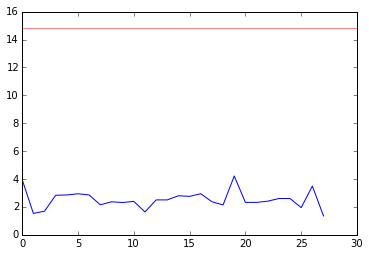

Name of Peptide Nav2
Base Energy 56.9535282708
Base Sequence ['I', 'Q', 'T', 'Q', 'I']

 Cycle number : 1

Lowest Energy 5.57943051755 Sequence ['C', 'T', 'G', 'N', 'N']



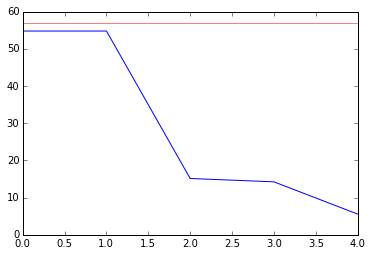

Name of Peptide NHE1
Base Energy 2.22458252069
Base Sequence ['I', 'P', 'K', 'G', 'Q']

 Cycle number : 1

Lowest Energy 1.85912073712 Sequence ['N', 'F', 'N', 'F', 'L']



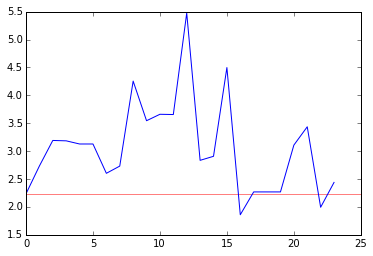

Name of Peptide Syndecan3
Base Energy 20.1300898057
Base Sequence ['E', 'E', 'F', 'Y', 'A']

 Cycle number : 1

Lowest Energy 3.78710057171 Sequence ['G', 'E', 'E', 'W', 'D']



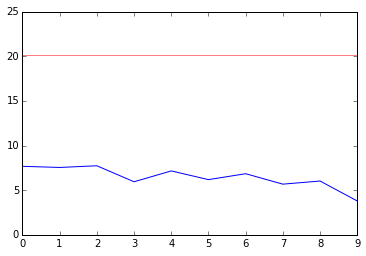

Name of Peptide TRPC1
Base Energy 36.789497232
Base Sequence ['F', 'Y', 'P', 'R', 'N']

 Cycle number : 1

Lowest Energy 1.64202485039 Sequence ['Q', 'E', 'Y', 'G', 'P']



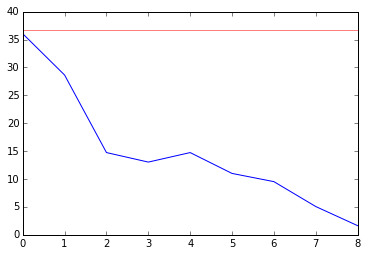

Name of Peptide TRPC2
Base Energy 9.77446519791
Base Sequence ['T', 'K', 'G', 'E', 'S']

 Cycle number : 1

Lowest Energy 1.10748329469 Sequence ['I', 'D', 'G', 'F', 'Y']



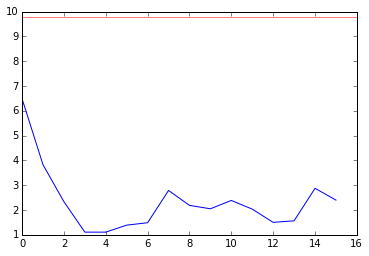

Name of Peptide TRPC3
Base Energy 8.96632131009
Base Sequence ['V', 'L', 'R', 'C', 'E']

 Cycle number : 1

Lowest Energy 2.7563689789 Sequence ['S', 'G', 'Q', 'G', 'G']



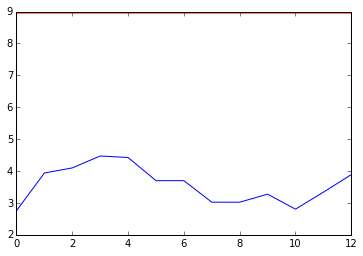

Name of Peptide TRPC5
Base Energy 7.89449491044
Base Sequence ['V', 'T', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 22.2668821683 Sequence ['D', 'L', 'M', 'Q', 'W']



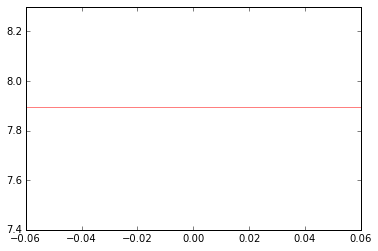

Name of Peptide TRPC6
Base Energy 10.7906794919
Base Sequence ['E', 'E', 'S', 'R', 'R']

 Cycle number : 1

Lowest Energy 1.46305190592 Sequence ['A', 'W', 'E', 'R', 'M']



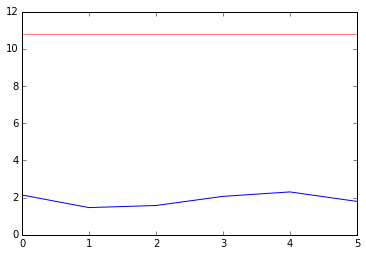

Name of Peptide TRPM3
Base Energy 1.65087662663
Base Sequence ['P', 'F', 'Y', 'S', 'V']

 Cycle number : 1

Lowest Energy 1.55702111899 Sequence ['D', 'H', 'D', 'M', 'V']



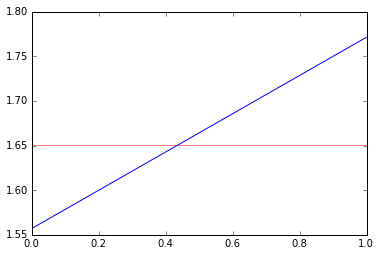

Name of Peptide TRPM4
Base Energy 2.81761761982
Base Sequence ['Q', 'S', 'G', 'S', 'C']

 Cycle number : 1

Lowest Energy 2.12529862303 Sequence ['L', 'D', 'W', 'S', 'A']



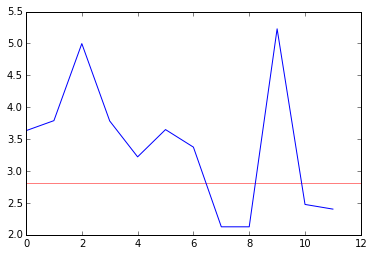

Name of Peptide TRPM5
Base Energy 5.02106119189
Base Sequence ['E', 'T', 'G', 'S', 'T']

 Cycle number : 1

Lowest Energy 0.916506267541 Sequence ['H', 'M', 'Q', 'W', 'P']



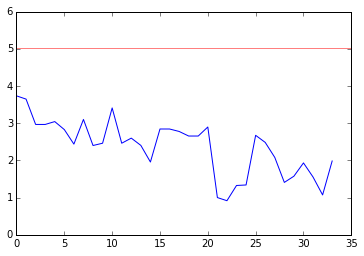

Name of Peptide TRPM6
Base Energy 5.1352907197
Base Sequence ['D', 'H', 'T', 'R', 'L']

 Cycle number : 1

Lowest Energy 7.27640830746 Sequence ['I', 'C', 'H', 'H', 'F']



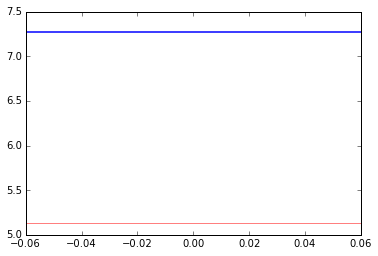

Name of Peptide TRPM7
Base Energy 17.1852674661
Base Sequence ['V', 'R', 'L', 'M', 'L']

 Cycle number : 1

Lowest Energy 1.14803871574 Sequence ['F', 'T', 'Y', 'S', 'C']



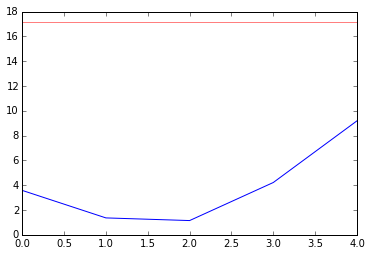

Name of Peptide TRPM8
Base Energy 26.3419147983
Base Sequence ['A', 'N', 'N', 'I', 'K']

 Cycle number : 1

Lowest Energy 1.82150441685 Sequence ['M', 'I', 'W', 'P', 'K']



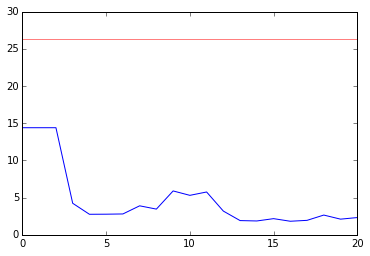

Name of Peptide TRPP2
Base Energy 8.33813906522
Base Sequence ['A', 'N', 'V', 'H', 'A']

 Cycle number : 1

Lowest Energy 1.09477563994 Sequence ['F', 'S', 'I', 'C', 'R']



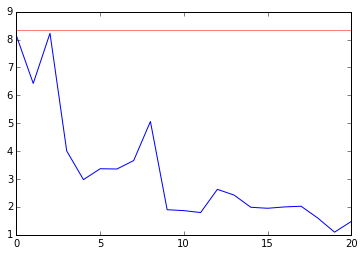

Name of Peptide TRPV3
Base Energy 29.4803613356
Base Sequence ['P', 'E', 'T', 'S', 'V']

 Cycle number : 1

Lowest Energy 34.6180477334 Sequence ['G', 'M', 'E', 'C', 'K']



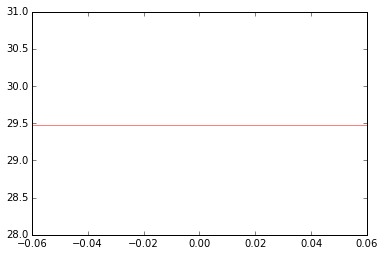

Name of Peptide TRPV4
Base Energy 5.59171498635
Base Sequence ['D', 'D', 'A', 'P', 'L']

 Cycle number : 1

Lowest Energy 1.99533323965 Sequence ['N', 'C', 'R', 'H', 'K']



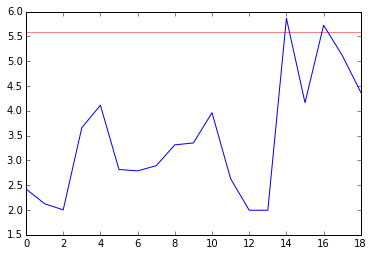

Name of Peptide TRPV6
Base Energy 16.0655743909
Base Sequence ['W', 'E', 'Y', 'Q', 'I']

 Cycle number : 1

Lowest Energy 1.448869325 Sequence ['N', 'S', 'H', 'D', 'D']



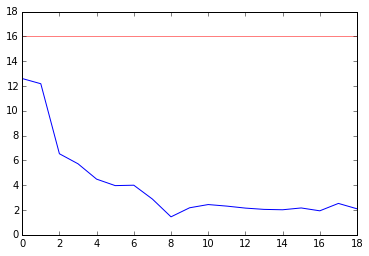

In [136]:
for i in range(len(PDZ_Data.peptides)):
    results = run_mc(100, PDZ_Data.peptides[i], temp=1.0,nb_cycles = 1, plot=True, verbose=False)

Name of Peptide AN2
Base Energy 32.7714922253
Base Sequence ['G', 'Q', 'Y', 'W', 'V']

 Cycle number : 1

Lowest Energy 1.00987706207 Sequence ['V', 'M', 'I', 'W', 'K']



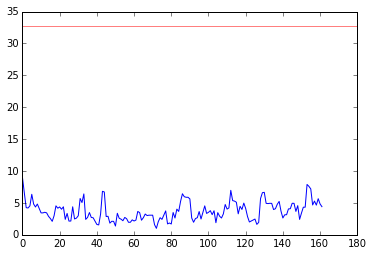


 Cycle number : 2

Lowest Energy 1.4105537934 Sequence ['F', 'D', 'N', 'V', 'Y']



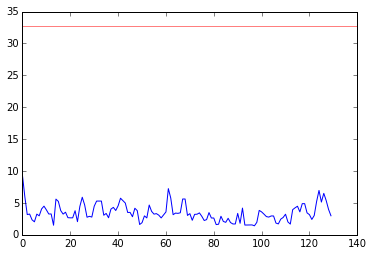


 Cycle number : 3

Lowest Energy 1.30464947057 Sequence ['E', 'V', 'G', 'C', 'D']



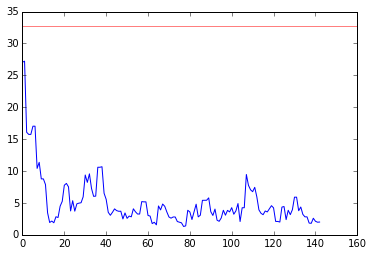


 Cycle number : 4

Lowest Energy 1.35336918126 Sequence ['H', 'E', 'I', 'V', 'T']



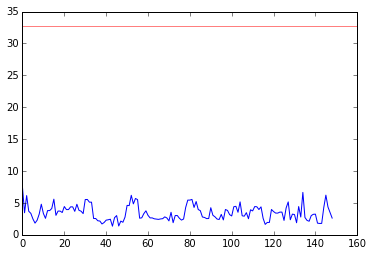


 Cycle number : 5

Lowest Energy 1.14937374501 Sequence ['W', 'G', 'K', 'T', 'G']



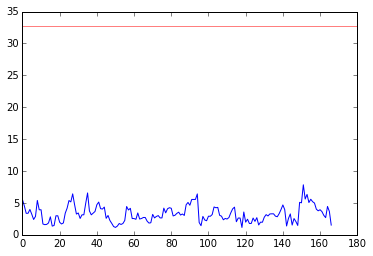


 Cycle number : 6

Lowest Energy 1.22718030488 Sequence ['F', 'C', 'G', 'P', 'H']



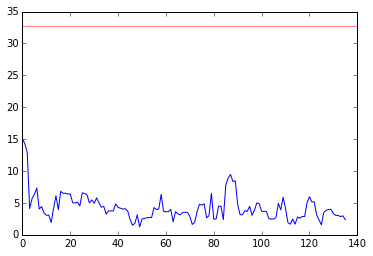


 Cycle number : 7

Lowest Energy 0.929380764227 Sequence ['F', 'D', 'L', 'M', 'C']



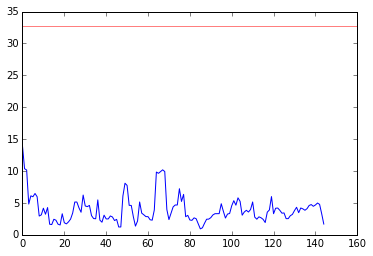


 Cycle number : 8

Lowest Energy 1.29358928891 Sequence ['I', 'T', 'R', 'I', 'C']



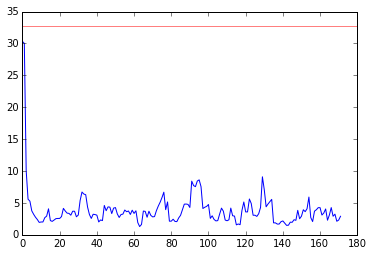


 Cycle number : 9

Lowest Energy 1.48562932369 Sequence ['N', 'N', 'K', 'F', 'A']



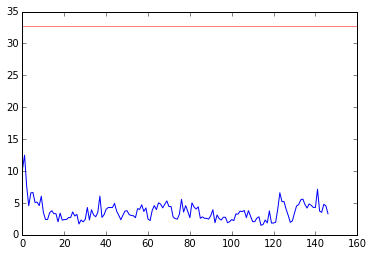


 Cycle number : 10

Lowest Energy 1.35727379316 Sequence ['W', 'K', 'K', 'W', 'P']



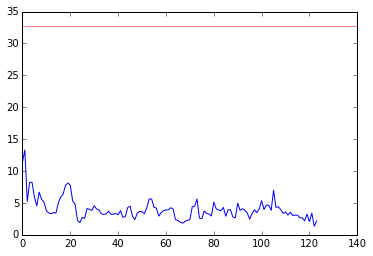

In [139]:
demo = run_mc(1000, PDZ_Data.peptides[0], temp = 1.0,nb_cycles=10, plot = True, verbose = False)

Name of Peptide Aquaporin4
Base Energy 34.688018304
Base Sequence ['V', 'L', 'S', 'S', 'V']

 Cycle number : 1

Run number: 0

Uniform 0.402933962786 Ratio 33718.0051089 Prob_Trans 1 
Accepted [17, 3, 9, 9, 2] 24.2622310541 ['H', 'L', 'S', 'S', 'V'] 

Run number: 1

Uniform 0.180680861769 Ratio 1151.18421626 Prob_Trans 1 
Accepted [17, 3, 9, 19, 2] 17.2136846093 ['H', 'L', 'S', 'E', 'V'] 

Run number: 3

Uniform 0.25779016607 Ratio 7.84728396218 Prob_Trans 1 
Accepted [17, 3, 9, 2, 16] 15.1535171295 ['H', 'L', 'S', 'V', 'R'] 

Run number: 4

Uniform 0.83025861913 Ratio 111.214766435 Prob_Trans 1 
Accepted [17, 3, 9, 19, 16] 10.4420539648 ['H', 'L', 'S', 'E', 'R'] 

Run number: 62

Uniform 0.0704017709011 Ratio 0.625697670593 Prob_Trans 0.625697670593 
Accepted [15, 3, 6, 15, 12] 10.9109419437 ['K', 'L', 'P', 'K', 'Q'] 

Run number: 63

Uniform 0.150897117364 Ratio 1.35275539542 Prob_Trans 1 
Accepted [15, 3, 6, 15, 16] 10.6087983976 ['K', 'L', 'P', 'K', 'R'] 

Run number: 71

Uniform 0

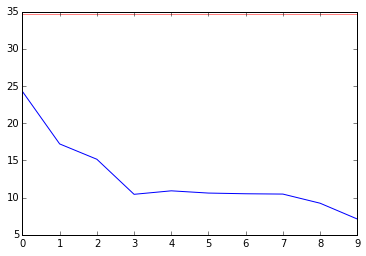

In [140]:
demo2 = run_mc(100, PDZ_Data.peptides[2], temp = 1.0, nb_cycles=1, plot=True, verbose=True)

In [141]:
len(demo2)

1

In [145]:
energies = demo2[0]['Mutated Energies']
sequences = demo2[0]['Mutated sequences']

In [146]:
energies[0:5]

[24.262231054107019,
 17.213684609311393,
 25.10791820834844,
 15.153517129465753,
 10.442053964785746]

In [149]:
res = demo2[0]['Results']

Name of Peptide Aquaporin4
Base Energy 34.688018304
Base Sequence ['V', 'L', 'S', 'S', 'V']

 Cycle number : 1

Last sequence seen [2, 3, 9, 9, 2]
Sequence after mutation [2, 3, 9, 9, 2]
Run number 0 Uniform 0.539424429008 Ratio 9.09479940522e-06 Prob_Trans 9.09479940522e-06 
Rejected [2, 3, 9, 11, 2] 46.2958261057 ['V', 'L', 'S', 'N', 'V'] ['V', 'L', 'S', 'N', 'V']

Last sequence seen [2, 3, 9, 11, 2]
Sequence after mutation [2, 3, 9, 11, 2]
Run number: 1

Uniform 0.592149489337 Ratio 1552107.44584 Prob_Trans 1 
Accepted [2, 3, 9, 14, 2] 20.4328940961 ['V', 'L', 'S', 'C', 'V'] ['V', 'L', 'S', 'C', 'V'] 

Last sequence seen [2, 3, 9, 14, 2]
Sequence after mutation [2, 3, 9, 14, 2]
Run number: 2

Uniform 0.149788345811 Ratio 8146.38050249 Prob_Trans 1 
Accepted [2, 15, 9, 14, 2] 11.4275650986 ['V', 'K', 'S', 'C', 'V'] ['V', 'K', 'S', 'C', 'V'] 

Last sequence seen [2, 15, 9, 14, 2]
Sequence after mutation [2, 15, 9, 14, 2]
Run number 3 Uniform 0.649030337692 Ratio 0.0546128535407 Prob_T

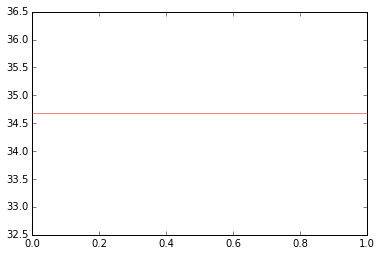

In [171]:
demo3 = run_mc(100, PDZ_Data.peptides[2], temp = 1.0, nb_cycles=1, plot=True, verbose=True)

In [174]:
temp_seq = [2,3,5]
mut_seq = (6,7,8)
temp_seq = list(mut_seq)
temp_seq[2] = 156
print mut_seq
print temp_seq

(6, 7, 8)
[6, 7, 156]


In [173]:
z = 2
y = z
y = 3
print y
print z

3
2
